In [1]:


import os
from pathlib import Path

# Third-Party Library Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from skimage.morphology import skeletonize
from skimage.graph import route_through_array
from skimage.measure import label as sklabel, regionprops
from skan import Skeleton

from scipy.spatial import distance


# Detecting seeds


def extract_petri_dish(image):
    # Read the image
    input_img = image.copy()

    if input_img is None:
        print(f"Error: Unable to load image from {image}")
        return None, None, None, (0, 0)
    print(input_img.shape)
    # Convert to grayscale
    gray_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)

    # Apply binary thresholding with a lower threshold to better capture edges
    _, binary = cv2.threshold(gray_img, 100, 255, cv2.THRESH_BINARY)  # Lowered threshold from 127

    # Apply morphological operations to clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # Find contours of the main dish
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return input_img, binary, input_img, (0, 0)

    # Find the largest rectangular contour (should be the Petri dish)
    main_contour = max(contours, key=cv2.contourArea)

    # Get the bounding rectangle with increased padding
    x, y, w, h = cv2.boundingRect(main_contour)
    padding = 30  # Increased padding to ensure we capture the full dish

    # Add extra validation
    aspect_ratio = float(w) / h
    if not (0.9 <= aspect_ratio <= 1.1):  # Check if it's roughly square
        print(f"Warning: Unusual aspect ratio detected: {aspect_ratio}")
        # Adjust to make it square
        max_dim = max(w, h)
        w = h = max_dim

    # Ensure we capture the full square dish
    largest_side = max(w, h) + 2 * padding
    center_x = x + w // 2
    center_y = y + h // 2

    # Calculate the crop coordinates
    half_side = largest_side // 2
    x_min = max(0, center_x - half_side)
    y_min = max(0, center_y - half_side)
    x_max = min(input_img.shape[1], center_x + half_side)
    y_max = min(input_img.shape[0], center_y + half_side)

    # Add symmetry check
    if (x_max - x_min) != (y_max - y_min):
        # Ensure square crop by taking the larger dimension
        size = max(x_max - x_min, y_max - y_min)
        center_x = (x_min + x_max) // 2
        center_y = (y_min + y_max) // 2
        half_size = size // 2

        x_min = max(0, center_x - half_size)
        y_min = max(0, center_y - half_size)
        x_max = min(input_img.shape[1], center_x + half_size)
        y_max = min(input_img.shape[0], center_y + half_size)

    # Extract the ROI
    cropped_roi = input_img[y_min:y_max, x_min:x_max]

    return cropped_roi, {
        'y': y_min,
        'y+h': y_max,
        'x': x_min,
        'x+w': x_max,
    }


from scipy.spatial import distance

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.spatial import distance
from skimage.measure import label as sklabel, regionprops
import numpy as np
import cv2


def detect_seeds_refined_with_margin(image_path, root_centroids=None, margin=450, distance_threshold=400,
                                     original_images_folder='kaggle_images', display_intermediate=False):
    """
    Refined seed detection with coordinate mapping back to original image space.
    """
    # Read and preprocess image
    image_path = str(image_path).replace('testingpredictions',
                                         original_images_folder).replace('predictions', original_images_folder).replace(
        '_mask', '')

    original_img = cv2.imread(image_path)
    cropped_img, cropping_coords = extract_petri_dish(original_img)

    # Store the offsets for later use
    x_offset = cropping_coords['x']
    y_offset = cropping_coords['y']

    gray = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)

    # Create a mask for darker regions
    _, dark_mask = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY_INV)
    blurred = cv2.bilateralFilter(gray, d=7, sigmaColor=50, sigmaSpace=50)
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 3)
    combined_mask = cv2.bitwise_and(binary, dark_mask)

    # Morphological operations
    kernel = np.ones((2, 2), np.uint8)
    cleaned = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel)

    # Label connected components
    labeled_img = sklabel(cleaned)

    # Adjust root centroids to cropped coordinate system if they exist
    cropped_root_centroids = None
    if root_centroids:
        cropped_root_centroids = [(rx - x_offset, ry - y_offset) for rx, ry in root_centroids]

    # Collect initial candidates
    candidates = []
    height, width = gray.shape
    for region in regionprops(labeled_img):
        if 30 < region.area < 500:  # Size constraints
            circularity = (4 * np.pi * region.area / (region.perimeter ** 2)
                           if region.perimeter > 0 else 0)
            mean_intensity = np.mean(gray[region.coords[:, 0], region.coords[:, 1]])
            intensity_std = np.std(gray[region.coords[:, 0], region.coords[:, 1]])
            centroid = region.centroid  # (y, x)

            if margin <= centroid[0] <= (height - margin) and margin <= centroid[1] <= (width - margin):
                if (0.1 < circularity < 1.4 and
                        mean_intensity < 100 and
                        intensity_std < 25 and
                        region.eccentricity < 0.8):

                    # Calculate coordinates in cropped space
                    seed_x_cropped, seed_y_cropped = int(centroid[1]), int(centroid[0])

                    # Calculate coordinates in original space
                    seed_x_original = seed_x_cropped + x_offset
                    seed_y_original = seed_y_cropped + y_offset

                    # Exclude seeds near root centroids
                    if cropped_root_centroids:
                        distances = [distance.euclidean((seed_x_cropped, seed_y_cropped), (rx, ry))
                                     for rx, ry in cropped_root_centroids]
                        if any(d <= distance_threshold for d in distances):
                            continue

                    candidates.append({
                        'x': seed_x_original,  # Store original coordinates
                        'y': seed_y_original,
                        'x_cropped': seed_x_cropped,  # Store cropped coordinates
                        'y_cropped': seed_y_cropped,
                        'area': region.area,
                        'mean_intensity': mean_intensity,
                        'circularity': circularity
                    })

    # Visualization on original image
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    ax.set_title("Seed Detection with Exclusions")

    # Plot seeds using original coordinates
    for seed in candidates:
        ax.plot(seed['x'], seed['y'], "ro", markersize=5)

    # Plot root centroids and exclusion zones using original coordinates
    if root_centroids:
        for rx, ry in root_centroids:
            circle = plt.Circle((rx, ry), distance_threshold, color='blue', fill=False, linestyle='--')
            ax.add_patch(circle)

    ax.set_axis_off()
    plt.show()

    return len(candidates), candidates


def load_img(path):
    """Load image from path and binarize."""
    img = cv2.imread(path, 0)
    img = (img > 0).astype('uint8')
    return img


def show_img(img, cmap='gray', title=None):
    """Display an image using matplotlib."""
    plt.figure(dpi=300)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.imshow(img, cmap=cmap)
    plt.show()


def preprocess_mask(mask, close_kernel_size=7, dilate_kernel_size=3):  # Increased close_kernel_size
    """
    Preprocess the mask to close gaps and clean noise.
    """
    # Apply closing operation with larger kernel to close gaps
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_kernel_size, close_kernel_size))
    mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_close)

    # Apply dilation with slightly larger kernel
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (dilate_kernel_size, dilate_kernel_size))
    mask_dilated = cv2.dilate(mask_closed, kernel_dilate, iterations=2)  # Increased iterations

    # Final closing to ensure connectivity
    mask_final = cv2.morphologyEx(mask_dilated, cv2.MORPH_CLOSE, kernel_close)

    return mask_final


def get_component_features(stats, img_height):
    """
    Calculate component features for classification.
    """
    x, y, width, height, area = stats

    # Calculate features
    height_ratio = height / img_height
    aspect_ratio = height / width if width > 0 else float('inf')
    vertical_position = (y + height) / img_height

    return height_ratio, aspect_ratio, vertical_position


def classify_component(stats, img_height, img_width):
    """
    Classify components based on size categories and their specific criteria
    """
    x, y, width, height, area = stats

    height_ratio = height / img_height
    aspect_ratio = height / width if width > 0 else float('inf')
    vertical_position = (y + height) / img_height
    print('X , y : ', x, ', ', y)
    print('Area of this root is : ', area)

    print('is_tall_enough: ', height_ratio, )

    print(' is_somewhat_vertical: ', aspect_ratio)
    print('Vertical positon: ', vertical_position, )

    print('=' * 50)
    # Size-based classification

    if area <= 1500:  # Tiny roots

        is_tall_enough = height_ratio >= 0.005  # Reduced from 0.05
        is_somewhat_vertical = aspect_ratio > 0.15  # Reduced from 0.5
        extends_down = vertical_position > 0.01  # Reduced from 0.15

        return is_tall_enough and is_somewhat_vertical and extends_down
    elif area <= 2500:  # Small roots
        is_tall_enough = height_ratio >= 0.05
        is_somewhat_vertical = aspect_ratio > 0.5
        extends_down = vertical_position > 0.15
    elif 1500 < area <= 4500:  # Medium roots

        is_tall_enough = height_ratio >= 0.1
        is_somewhat_vertical = aspect_ratio > 0.8
        extends_down = vertical_position > 0.2
    else:  # Large roots

        is_tall_enough = height_ratio >= 0.15

        extends_down = vertical_position > 0.20
        if height_ratio < 0.25:
            is_somewhat_vertical = aspect_ratio > 1.0
        else:
            is_somewhat_vertical = aspect_ratio > 1.8

    # return is_tall_enough and is_somewhat_vertical and extends_down
    return (is_tall_enough or extends_down) and is_somewhat_vertical


def find_root_tip_and_centroid(labels, component_idx):
    """
    Find both the root tip (top point) and the centroid for a component.
    
    Args:
        labels: Label matrix from connected components
        component_idx: Index of the component to analyze
        
    Returns:
        tuple: ((centroid_x, centroid_y), (tip_x, tip_y))
    """
    component_mask = (labels == component_idx)
    y_coords, x_coords = np.nonzero(component_mask)

    if len(x_coords) == 0 or len(y_coords) == 0:
        return ((0, 0), (0, 0))

    # Find the top point (root tip)
    top_idx = np.argmin(y_coords)
    tip_x = x_coords[top_idx]
    tip_y = y_coords[top_idx]

    # Calculate weighted centroid, giving more importance to upper part
    weights = np.exp(-(y_coords - tip_y) / 100)  # Exponential decay from tip
    centroid_x = int(np.average(x_coords, weights=weights))
    centroid_y = int(np.average(y_coords, weights=weights))

    return ((centroid_x, centroid_y), (tip_x, tip_y))


def filter_components(labels, stats, min_cut_off=50, max_cut_off=1600):
    """
    Filter components with adaptive size thresholds and improved centroid calculation
    """
    img_height, img_width = labels.shape

    # Find the largest component size to determine which category we're dealing with
    component_areas = stats[1:, cv2.CC_STAT_AREA]  # Skip background (index 0)
    if len(component_areas) > 0:
        largest_area = np.max(component_areas)
        print('Largest area: ', largest_area)
        print('Smallest area', np.min(component_areas))

        # Set size thresholds based on the largest component
        if largest_area <= 1500:  # tiny roots:
            min_size = 30
            max_size = 1500
            max_cut_off = 1050
        elif largest_area <= 2500:  # Small roots image
            min_size = 150
            max_size = 2500
        elif largest_area <= 7000:  # Medium roots image
            min_size = 600
            max_size = 7000
        else:  # Large roots image
            min_size = 5000
            max_size = None

    else:
        min_size = 500
        max_size = None

    filtered_output = np.zeros((*labels.shape, 3), dtype=np.uint8)
    filtered_mask = np.zeros(labels.shape, dtype=np.uint8)

    num_labels = stats.shape[0]
    colors = np.random.randint(0, 256, size=(num_labels, 3), dtype=np.uint8)

    valid_components = []
    valid_centroids = []

    # Collect valid components
    for i in range(1, num_labels):
        component_area = stats[i, cv2.CC_STAT_AREA]
        if ((max_size is None or component_area <= max_size) and
                component_area >= min_size and
                min_cut_off < stats[i, cv2.CC_STAT_TOP] < max_cut_off and
                classify_component(stats[i], img_height, img_width)):
            # Get both centroid and tip
            (centroid, tip) = find_root_tip_and_centroid(labels, i)

            valid_components.append((i, stats[i, cv2.CC_STAT_LEFT]))
            # Use the tip coordinates instead of centroid for exclusion zones
            valid_centroids.append(tip)

    # Sort by horizontal position
    valid_components.sort(key=lambda x: x[1])

    # Apply colors and create filtered mask
    for idx, (comp_idx, _) in enumerate(valid_components, 1):
        filtered_output[labels == comp_idx] = colors[idx]
        filtered_mask[labels == comp_idx] = 255

    print(f"Processing with size range: {min_size} - {max_size if max_size else 'unlimited'}")
    print(f"Root tips found at: {valid_centroids}")

    return filtered_output, filtered_mask, len(valid_components), valid_centroids


def segment_roots(img_path, output_folder):
    """
    Segment roots with adjusted preprocessing and filtering.
    """
    # Load mask
    predicted_root_mask = load_img(img_path)
    # show_img(predicted_root_mask, title="Original Mask")

    # Enhanced preprocessing with adjusted parameters
    mask_processed = preprocess_mask(
        predicted_root_mask,
        close_kernel_size=5,
        dilate_kernel_size=3
    )

    # show_img(mask_processed, title="Preprocessed Mask")

    # Connected components analysis
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(
        mask_processed, connectivity=8, ltype=cv2.CV_32S
    )

    filtered_output, filtered_mask, num_components, root_centroids = filter_components(
        labels,
        stats,

        min_cut_off=50,
        max_cut_off=1600
    )
    print(f"Filtered roots: {num_components} components detected.")
    print(f"Root centroids: {root_centroids}")

    # Detect seeds while excluding seeds near the roots
    seed_count, seeds = detect_seeds_refined_with_margin(
        img_path,
        root_centroids=root_centroids,
        display_intermediate=True,
        margin=400
    )

    print(f"Detected seeds: {seeds}")
    print(f"Seeds near roots are excluded. Remaining seed count: {seed_count}")

    # show_img(filtered_output, title=f"Detected Components: {num_components}")

    # Skeletonization
    skeleton = skeletonize_mask(filtered_mask)
    # show_img(skeleton)

    # Extract individual roots
    individual_roots = extract_individual_roots(skeleton, img_path, seeds=seeds)

    if len(individual_roots) == 0:
        print(f"No individual roots found for {img_path}.")
        return individual_roots

    save_individual_roots(individual_roots, output_folder, img_path)

    return individual_roots






In [2]:









def save_individual_roots(individual_roots, output_folder, img_path):
    """
    Save individual root skeletons and seeds as images to the specified folder, sorted by X coordinate.
    
    Parameters:
    - individual_roots: List of dictionaries, each containing root/seed data.
    - output_folder: Path to the folder where the images will be saved.
    - img_path: Path to the original image file (used for naming output files).
    """
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Sort individual_roots by X coordinate
    individual_roots = sorted(individual_roots, key=lambda root: root['x'])

    # Extract image name for consistent output naming
    img_name = Path(img_path).stem

    # Save each root/seed
    for idx, root in enumerate(individual_roots, start=1):
        if root["root_segment"] is not None:
            # Save root skeleton
            root_image = (root["root_segment"] * 255).astype(np.uint8)  # Scale binary mask to 0-255
            file_name = os.path.join(output_folder, f"{img_name}_root_{idx}.png")
            cv2.imwrite(file_name, root_image)
            print(f"Saved root: {file_name}")
        else:
            # Save seed as a placeholder text file
            file_name = os.path.join(output_folder, f"{img_name}_seed_{idx}.txt")
            with open(file_name, "w") as f:
                f.write(f"Seed at X: {root['x']}, Y: {root['y']}\n")
            print(f"Saved seed info: {file_name}")


def skeletonize_mask(filtered_mask):
    """Skeletonize the filtered binary mask."""
    skeleton = skeletonize(filtered_mask > 0)
    skeleton = (skeleton * 255).astype(np.uint8)
    return skeleton


def debug_intermediate_steps(skeleton, labels, stats, img_path):
    """Debug by visualizing intermediate steps."""
    # Visualize skeleton
    plt.figure(dpi=300)
    plt.title("Skeleton")
    plt.imshow(skeleton, cmap='gray')
    plt.show()

    # Visualize connected components
    plt.figure(dpi=300)
    plt.title(f"Connected Components - {img_path}")
    labeled_image = (labels / labels.max() * 255).astype(np.uint8)
    plt.imshow(labeled_image, cmap='nipy_spectral')
    plt.show()

    # Visualize bounding boxes
    for i in range(1, len(stats)):
        x, y, w, h, area = stats[i]
        print(f"Component {i}: Area={area}, BBox=({x},{y},{w},{h})")


def extract_individual_roots(skeleton, img_path, seeds=None):
    """
    Extract individual skeletonized roots as separate images and include seeds with root length = 0,
    ensuring a unified format for all roots and seeds.

    Parameters:
    - skeleton: Skeletonized root mask.
    - img_path: Path to the original image.
    - seeds: List of seed properties (x, y, etc.).

    Returns:
    - individual_roots: List of dictionaries, each representing a root or a seed.
    """
    # Perform connected components analysis on the skeleton
    retval, skeleton_labels, stats, centroids = cv2.connectedComponentsWithStats(
        skeleton, connectivity=8, ltype=cv2.CV_32S
    )

    debug_intermediate_steps(skeleton, skeleton_labels, stats, img_path)

    individual_roots = []

    # Process the skeletonized roots
    for i in range(1, retval):  # Start from 1 to skip the background
        x, y, w, h, area = stats[i]
        # Filter out very small components if needed
        if area < 10:
            continue

        root_segment = skeleton_labels[y:y + h, x:x + w] == i
        root_length = np.sum(root_segment)  # Calculate root length from the binary mask
        centroid_x = int(stats[i, cv2.CC_STAT_LEFT] + stats[i, cv2.CC_STAT_WIDTH] / 2)
        centroid_y = int(stats[i, cv2.CC_STAT_TOP] + stats[i, cv2.CC_STAT_HEIGHT] / 2)

        individual_roots.append({
            'root_segment': root_segment,
            'root_length': root_length,
            'x': centroid_x,
            'y': centroid_y
        })

    # Include seeds as individual components with root length = 0
    if seeds:

        for seed in seeds:
            individual_roots.append({
                'root_segment': None,  # No segment for seeds
                'root_length': 0,  # Root length is 0 for seeds
                'x': seed['x'],
                'y': seed['y']
            })

    print('Seed testing123', individual_roots)

    return individual_roots



In [3]:



def segment_predictions(output_folder, predictions_dir='./predictions', ):
    predictions_dir = Path(predictions_dir)
    path_to_strs = [str(img_path) for img_path in list(predictions_dir.iterdir())]
    print(path_to_strs)

    path_to_strs = sorted(path_to_strs, key=lambda x: int(x.split('_')[2]))

    for pred_file in path_to_strs:
        print(pred_file)

        # Call segment_roots on each predicted mask file
        segment_roots(str(pred_file), output_folder=output_folder)




['predictions\\test_image_10_mask.png', 'predictions\\test_image_11_mask.png', 'predictions\\test_image_12_mask.png', 'predictions\\test_image_13_mask.png', 'predictions\\test_image_14_mask.png', 'predictions\\test_image_15_mask.png', 'predictions\\test_image_16_mask.png', 'predictions\\test_image_17_mask.png', 'predictions\\test_image_18_mask.png', 'predictions\\test_image_1_mask.png', 'predictions\\test_image_2_mask.png', 'predictions\\test_image_3_mask.png', 'predictions\\test_image_4_mask.png', 'predictions\\test_image_5_mask.png', 'predictions\\test_image_6_mask.png', 'predictions\\test_image_7_mask.png', 'predictions\\test_image_8_mask.png', 'predictions\\test_image_9_mask.png']
predictions\test_image_1_mask.png
Largest area:  4656
Smallest area 58
X , y :  1179 ,  527
Area of this root is :  4656
is_tall_enough:  0.1739853626081171
 is_somewhat_vertical:  7.366197183098592
Vertical positon:  0.34930139720558884
X , y :  2146 ,  543
Area of this root is :  1954
is_tall_enough:  0

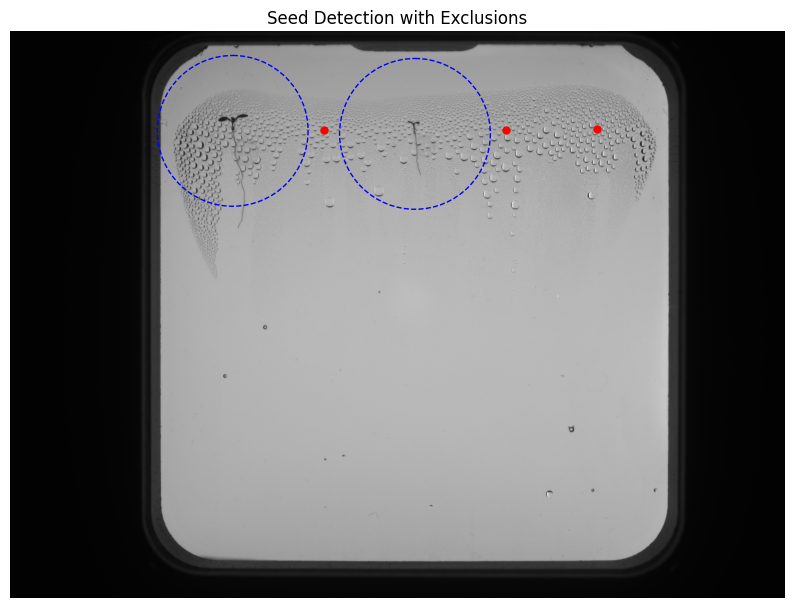

Detected seeds: [{'x': 3116, 'y': 517, 'x_cropped': 2369, 'y_cropped': 476, 'area': 48.0, 'mean_intensity': 56.916666666666664, 'circularity': 1.133223860012313}, {'x': 1663, 'y': 521, 'x_cropped': 916, 'y_cropped': 480, 'area': 34.0, 'mean_intensity': 57.44117647058823, 'circularity': 1.250364543402942}, {'x': 2632, 'y': 521, 'x_cropped': 1885, 'y_cropped': 480, 'area': 53.0, 'mean_intensity': 56.54716981132076, 'circularity': 1.0595954152819045}]
Seeds near roots are excluded. Remaining seed count: 3


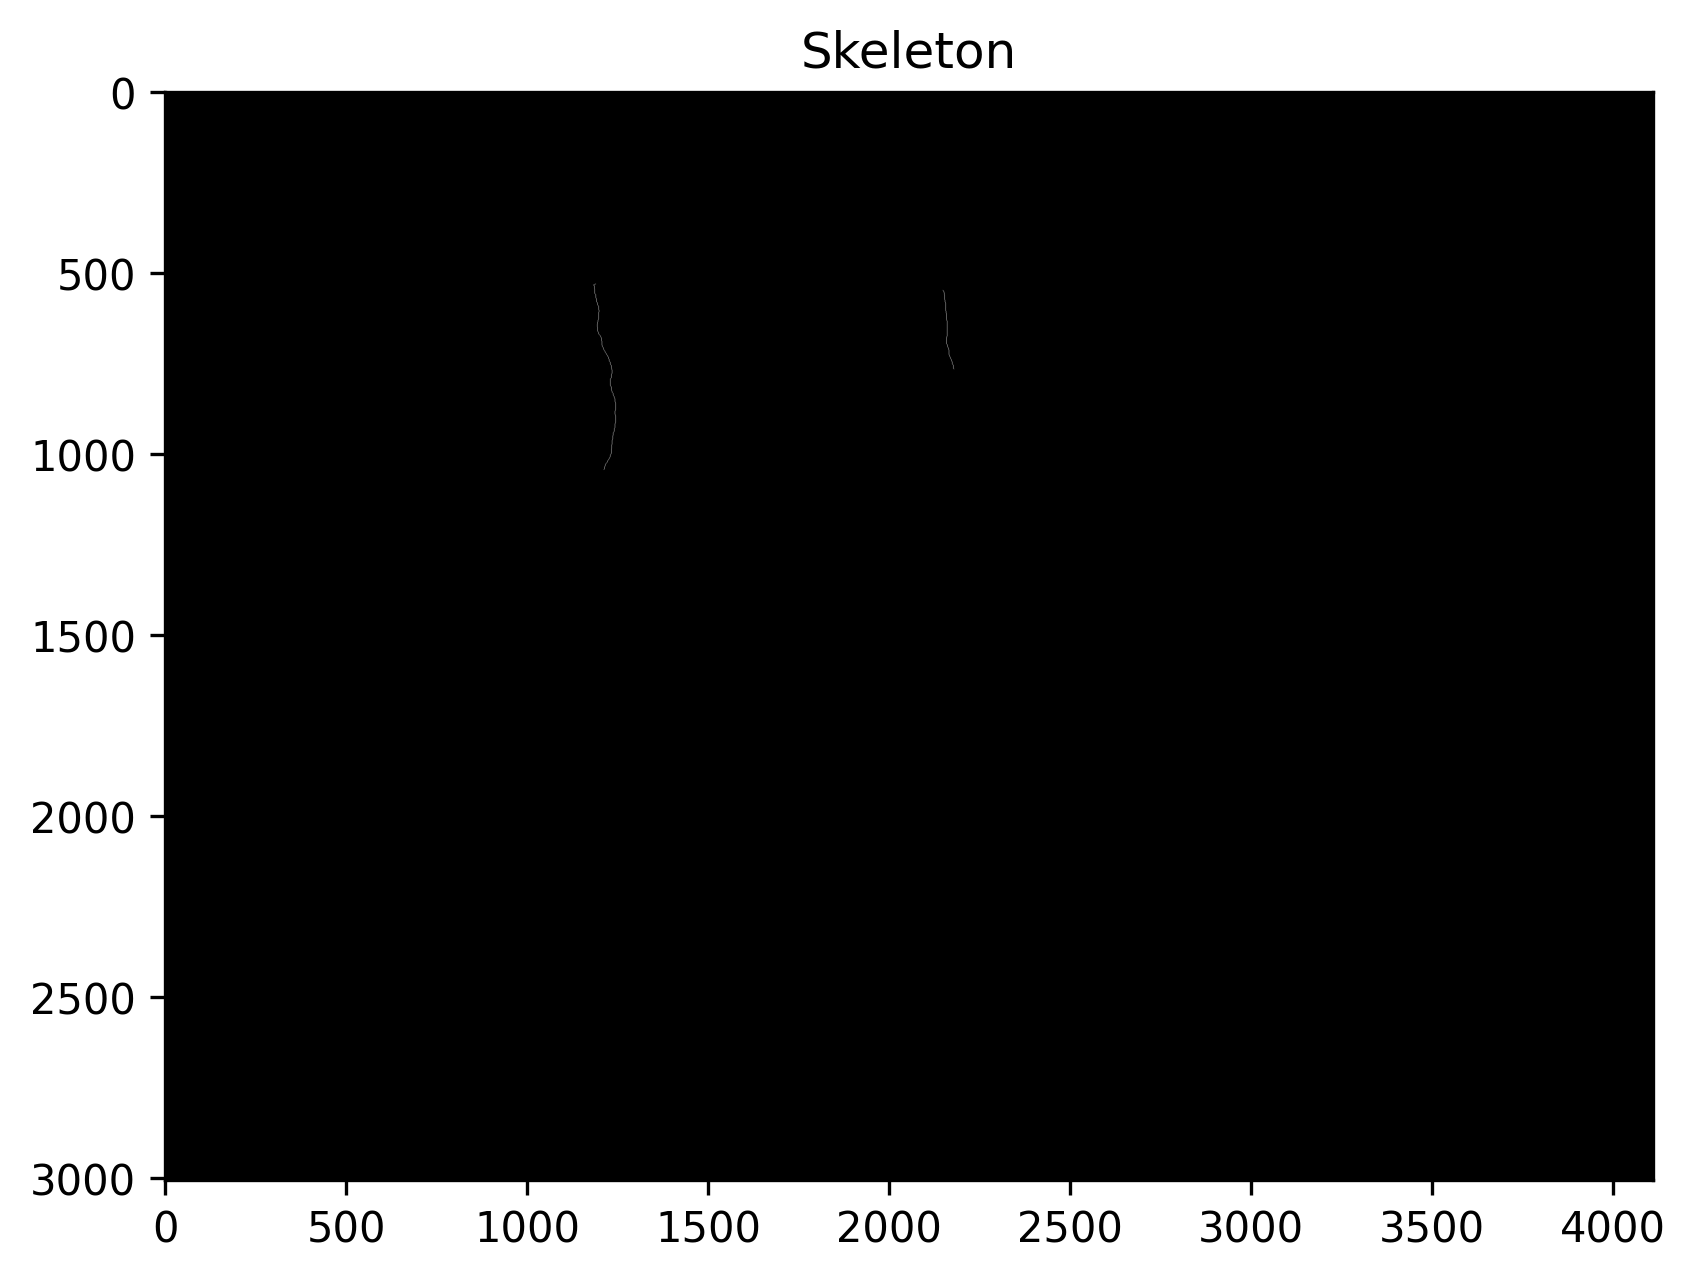

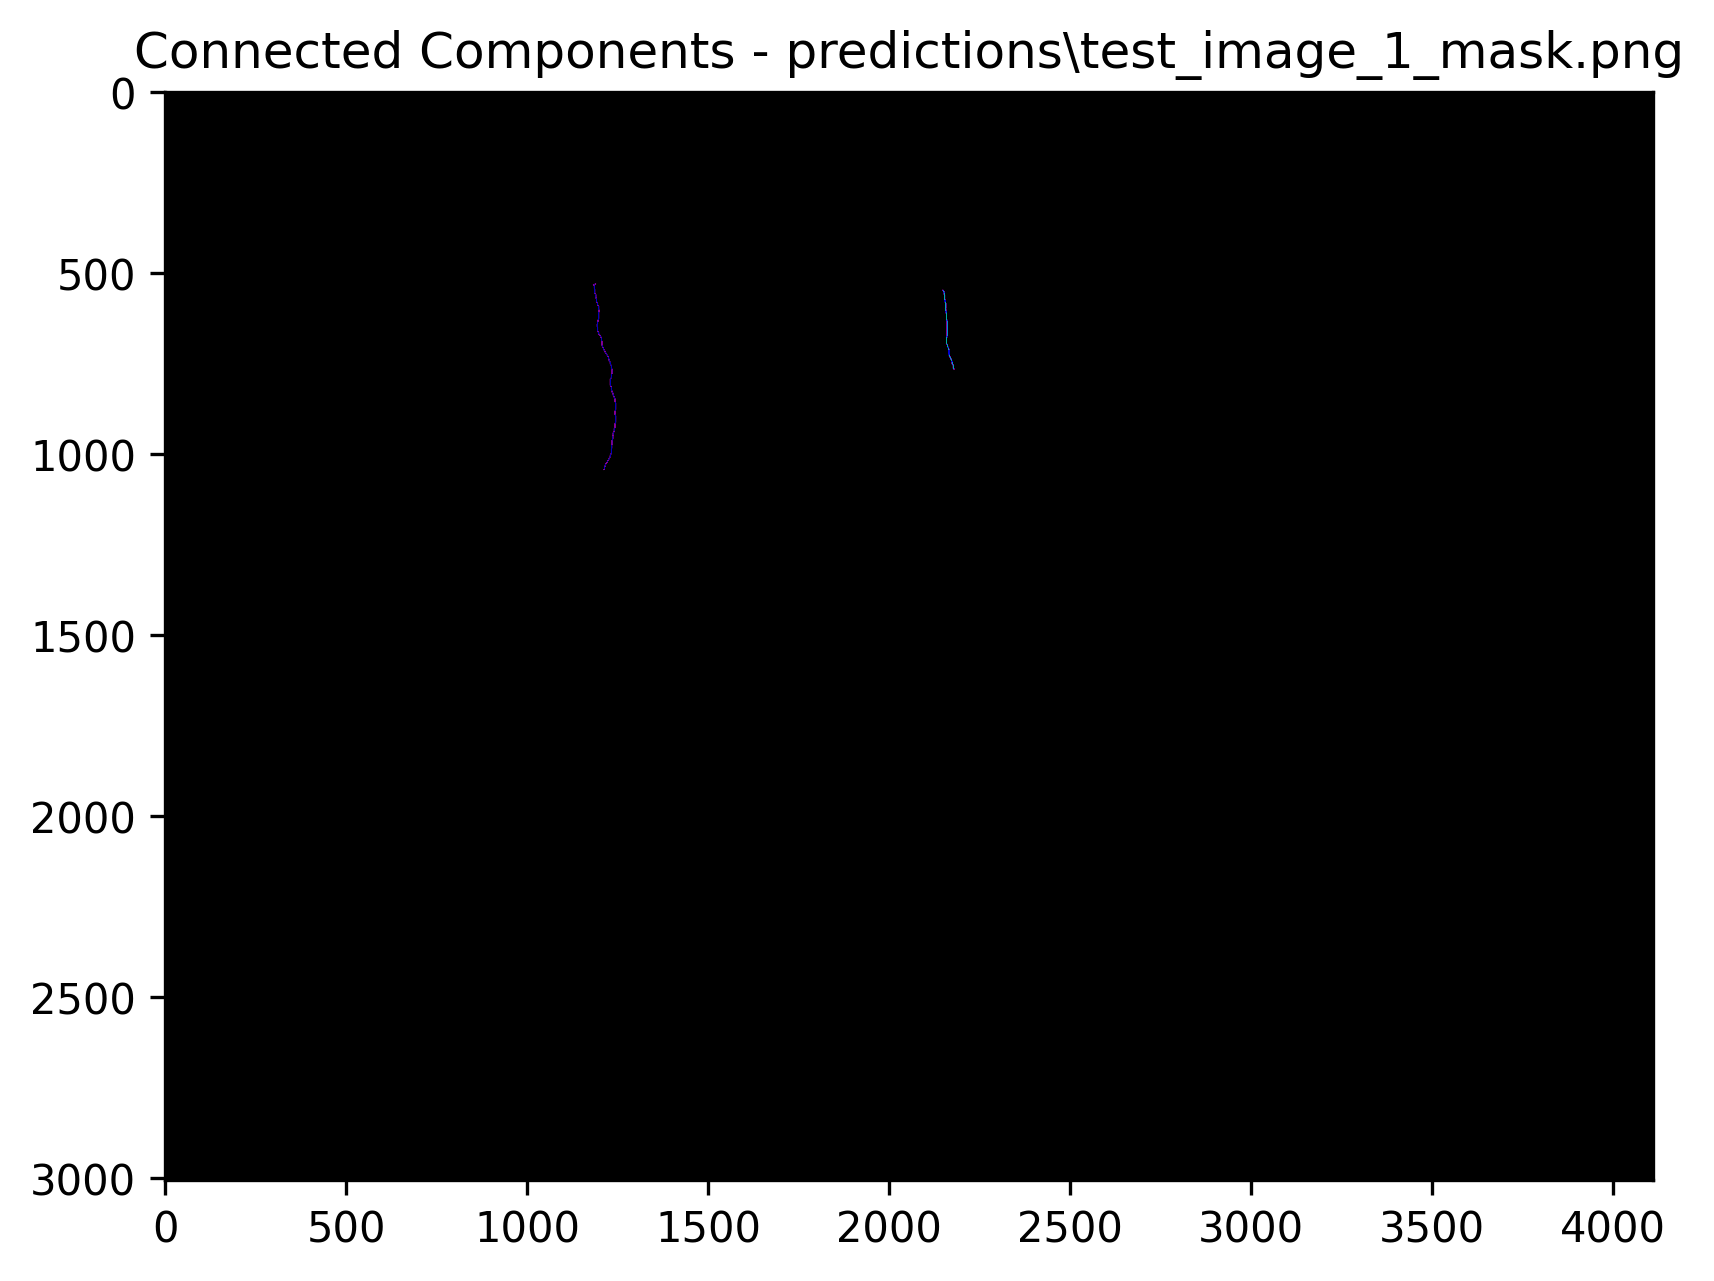

Component 1: Area=518, BBox=(1183,530,63,514)
Component 2: Area=219, BBox=(2149,547,32,219)
Seed testing123 [{'root_segment': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'root_length': 518, 'x': 1214, 'y': 787}, {'root_segment': array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]]), 'root_length': 219, 'x': 2165, 'y': 656}, {'root_segment': None, 'root_length': 0, 'x': 3116, 'y': 517}, {'root_seg

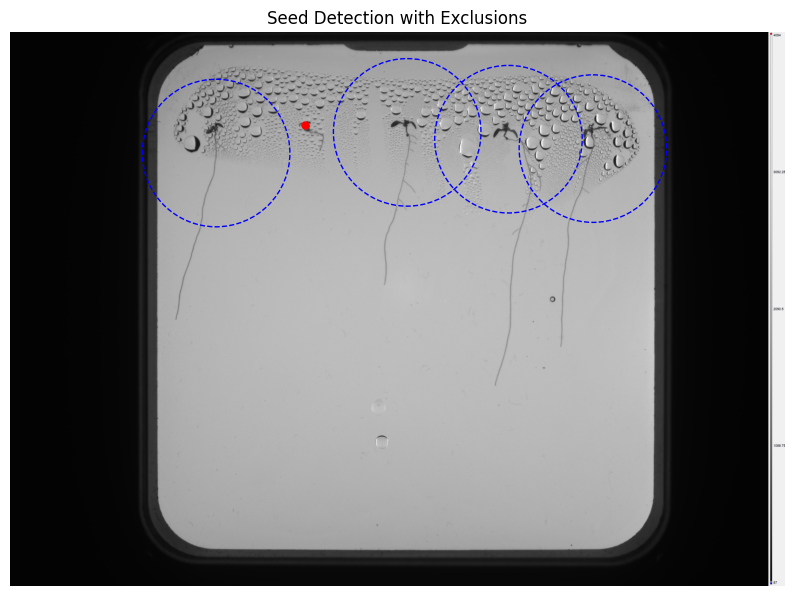

Detected seeds: [{'x': 1598, 'y': 508, 'x_cropped': 851, 'y_cropped': 467, 'area': 312.0, 'mean_intensity': 49.69871794871795, 'circularity': 0.2766446277703298}]
Seeds near roots are excluded. Remaining seed count: 1


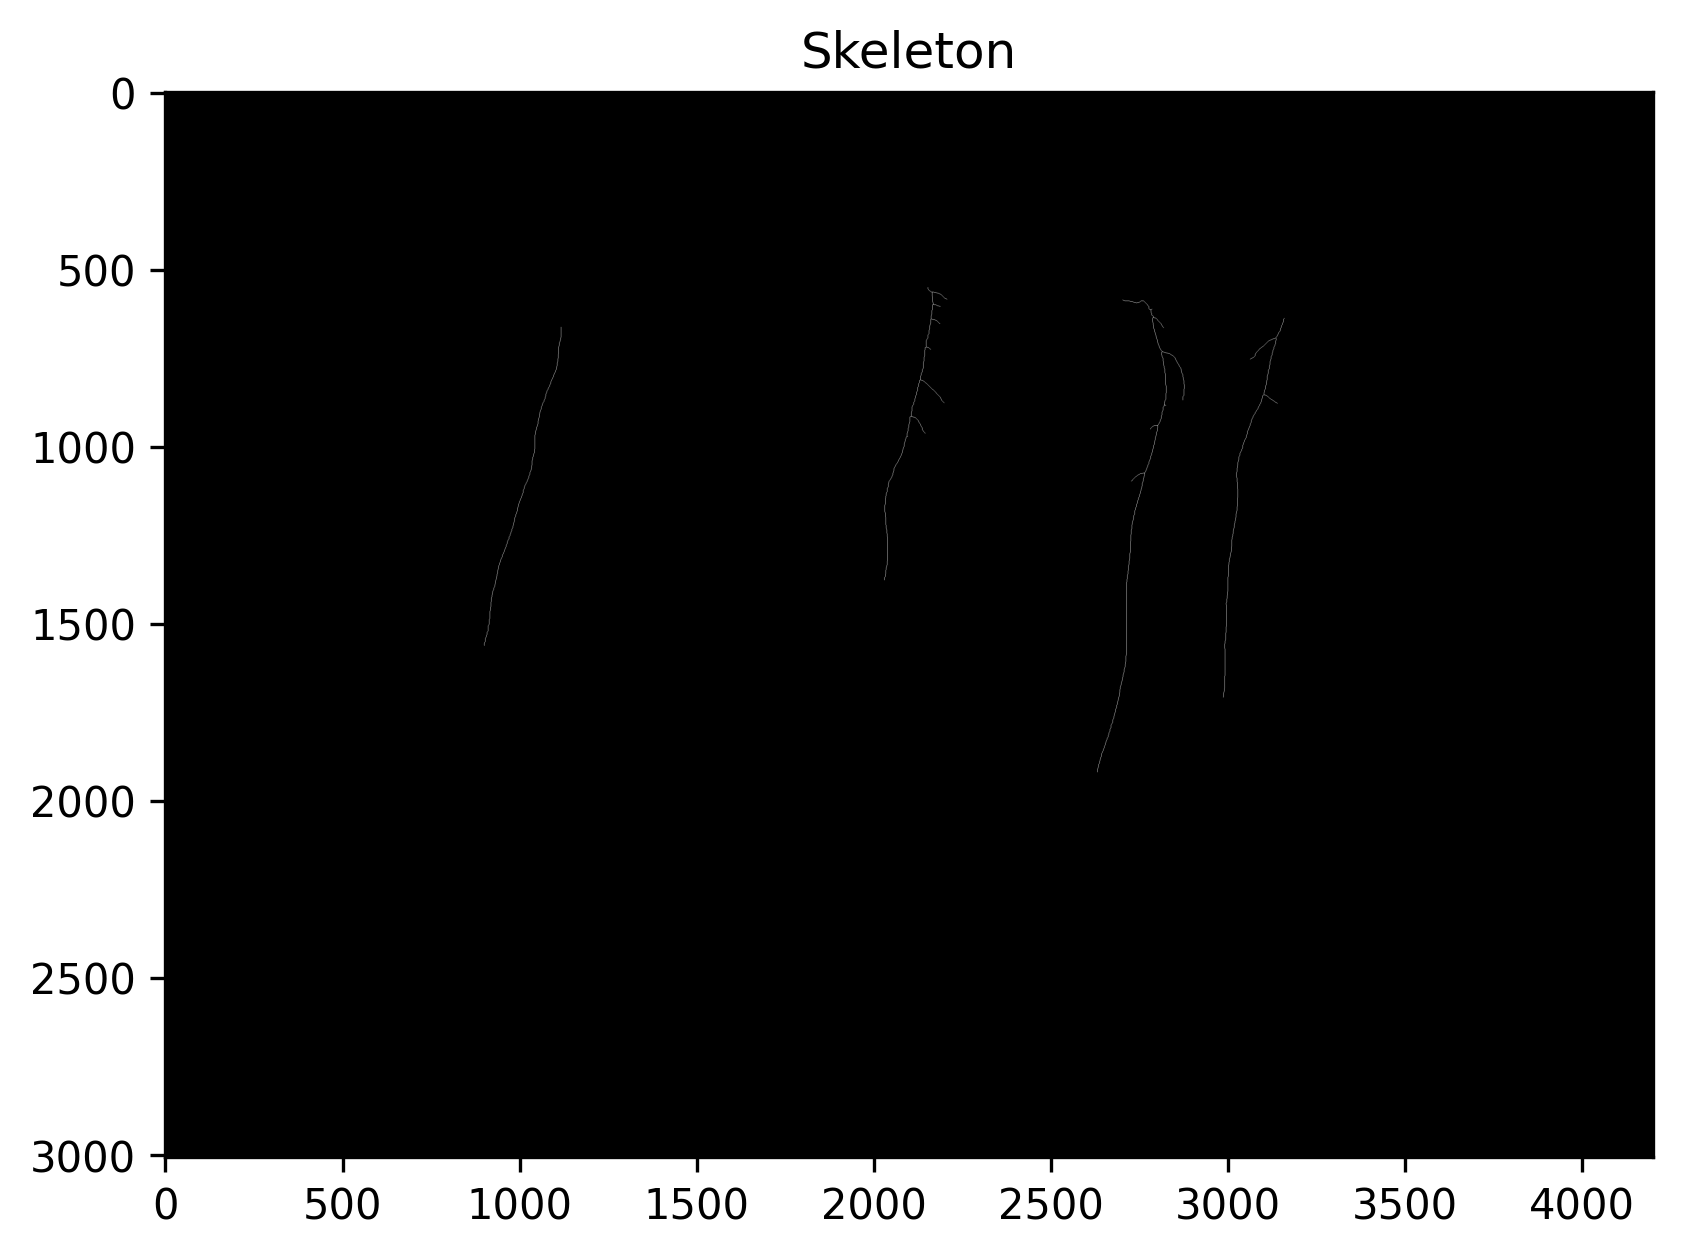

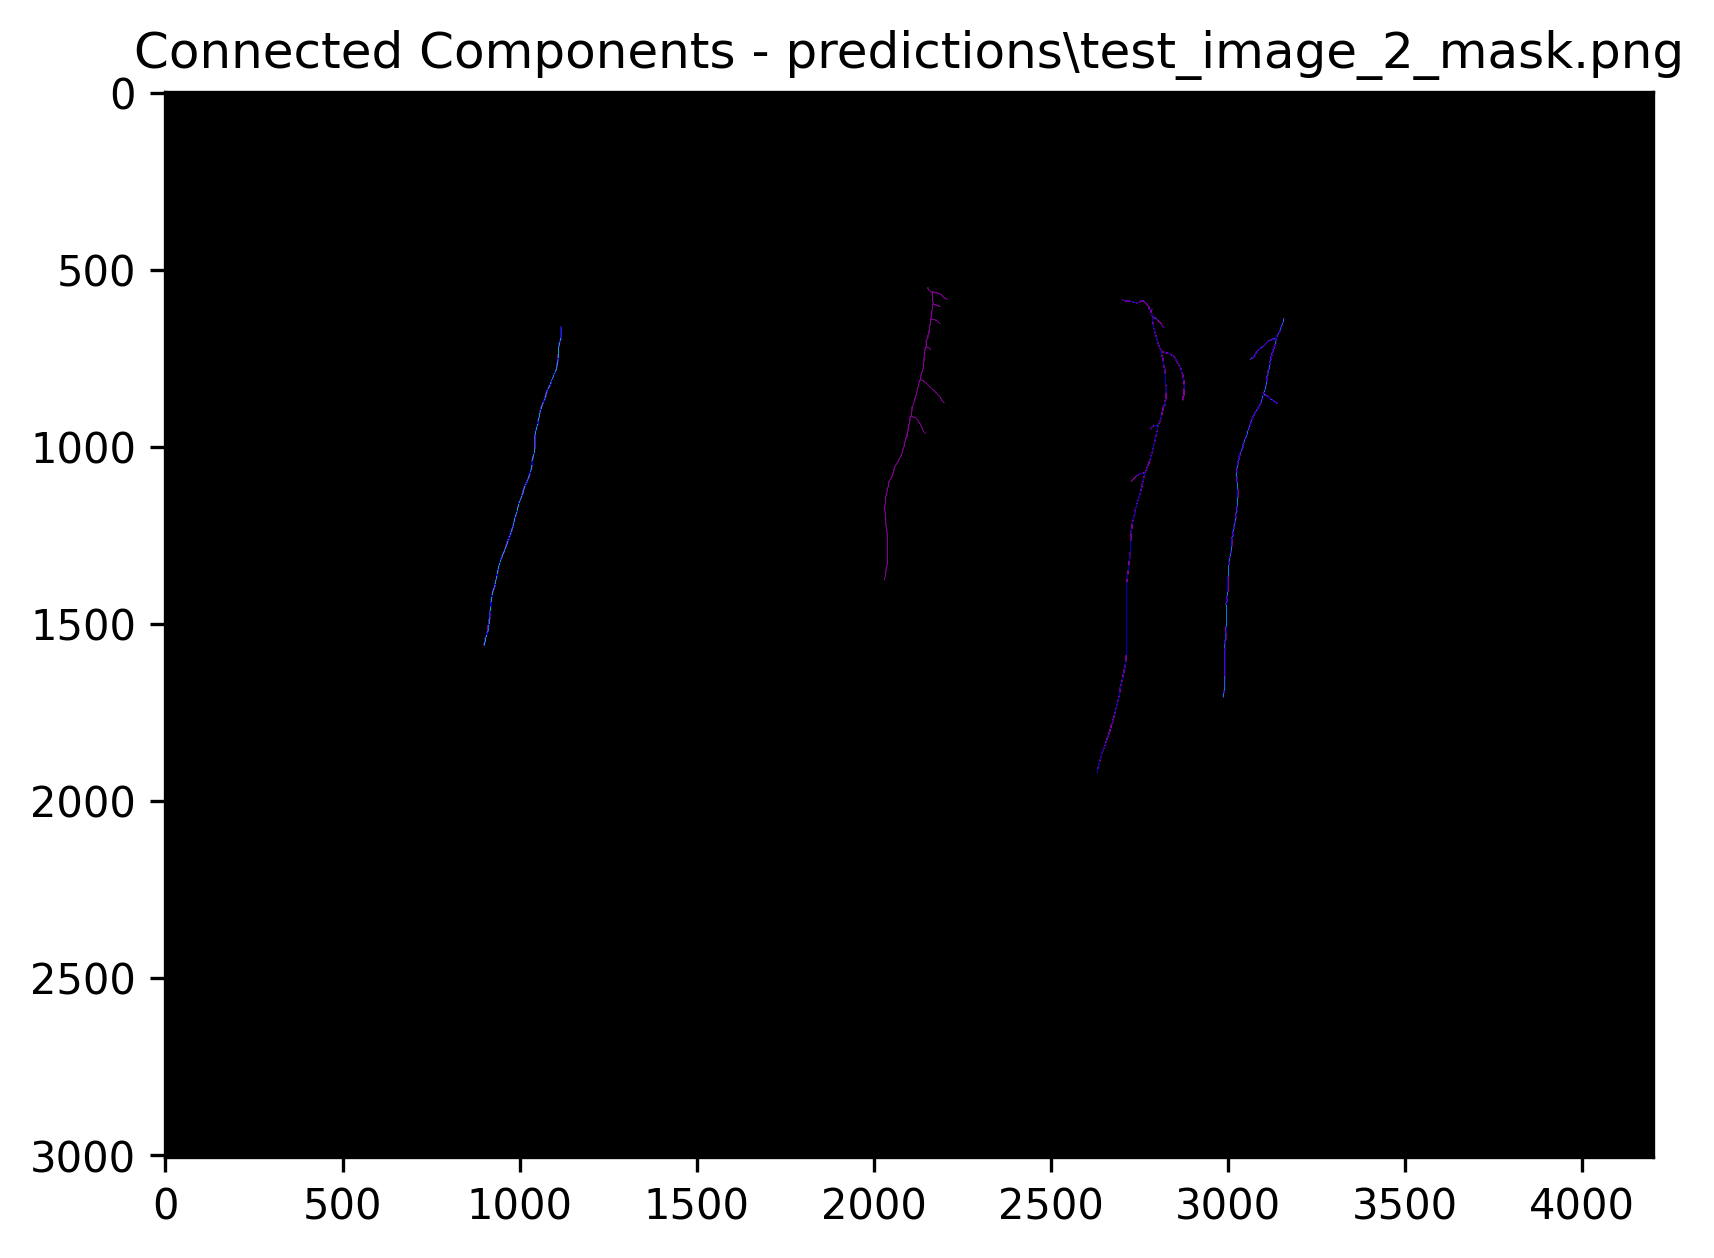

Component 1: Area=1067, BBox=(2031,551,178,827)
Component 2: Area=1654, BBox=(2633,586,246,1334)
Component 3: Area=1189, BBox=(2988,638,174,1071)
Component 4: Area=900, BBox=(901,663,218,900)
Seed testing123 [{'root_segment': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False]]), 'root_length': 1067, 'x': 2120, 'y': 964}, {'root_segment': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False]]), 'root_length':

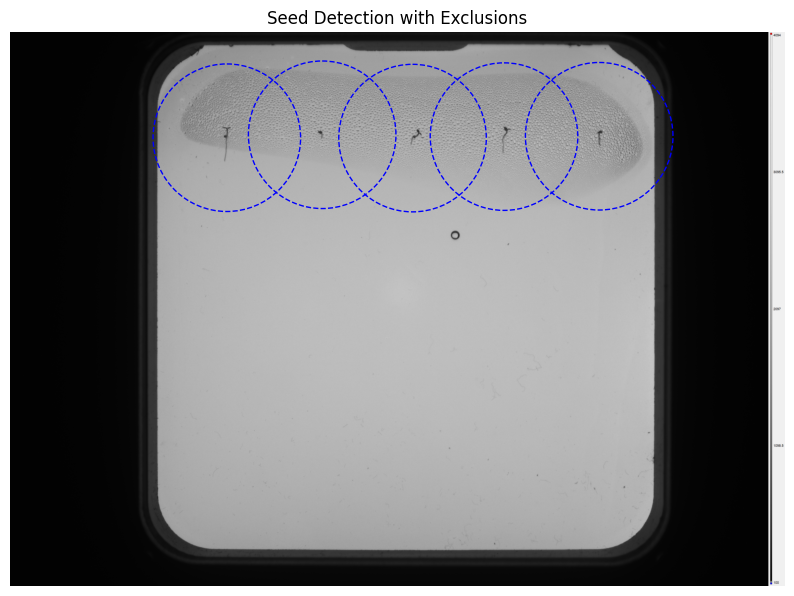

Detected seeds: []
Seeds near roots are excluded. Remaining seed count: 0


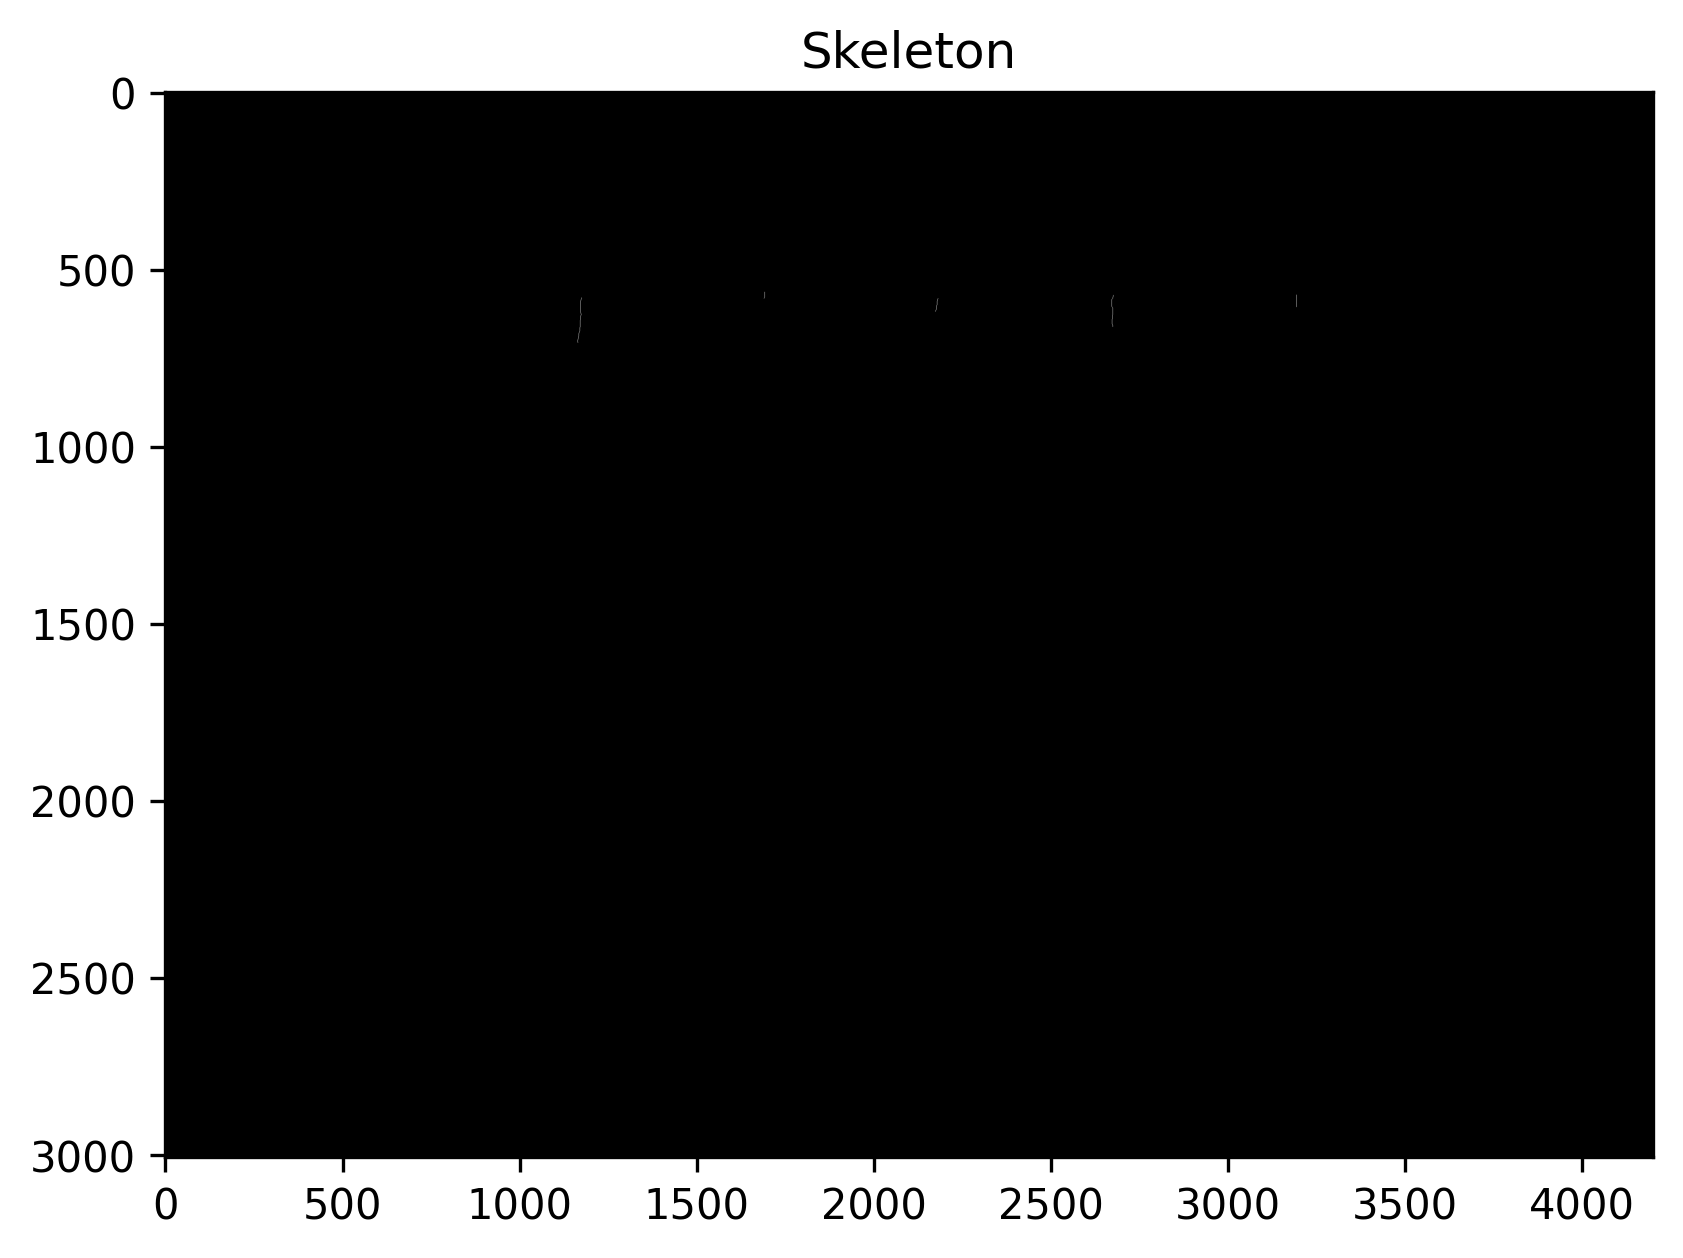

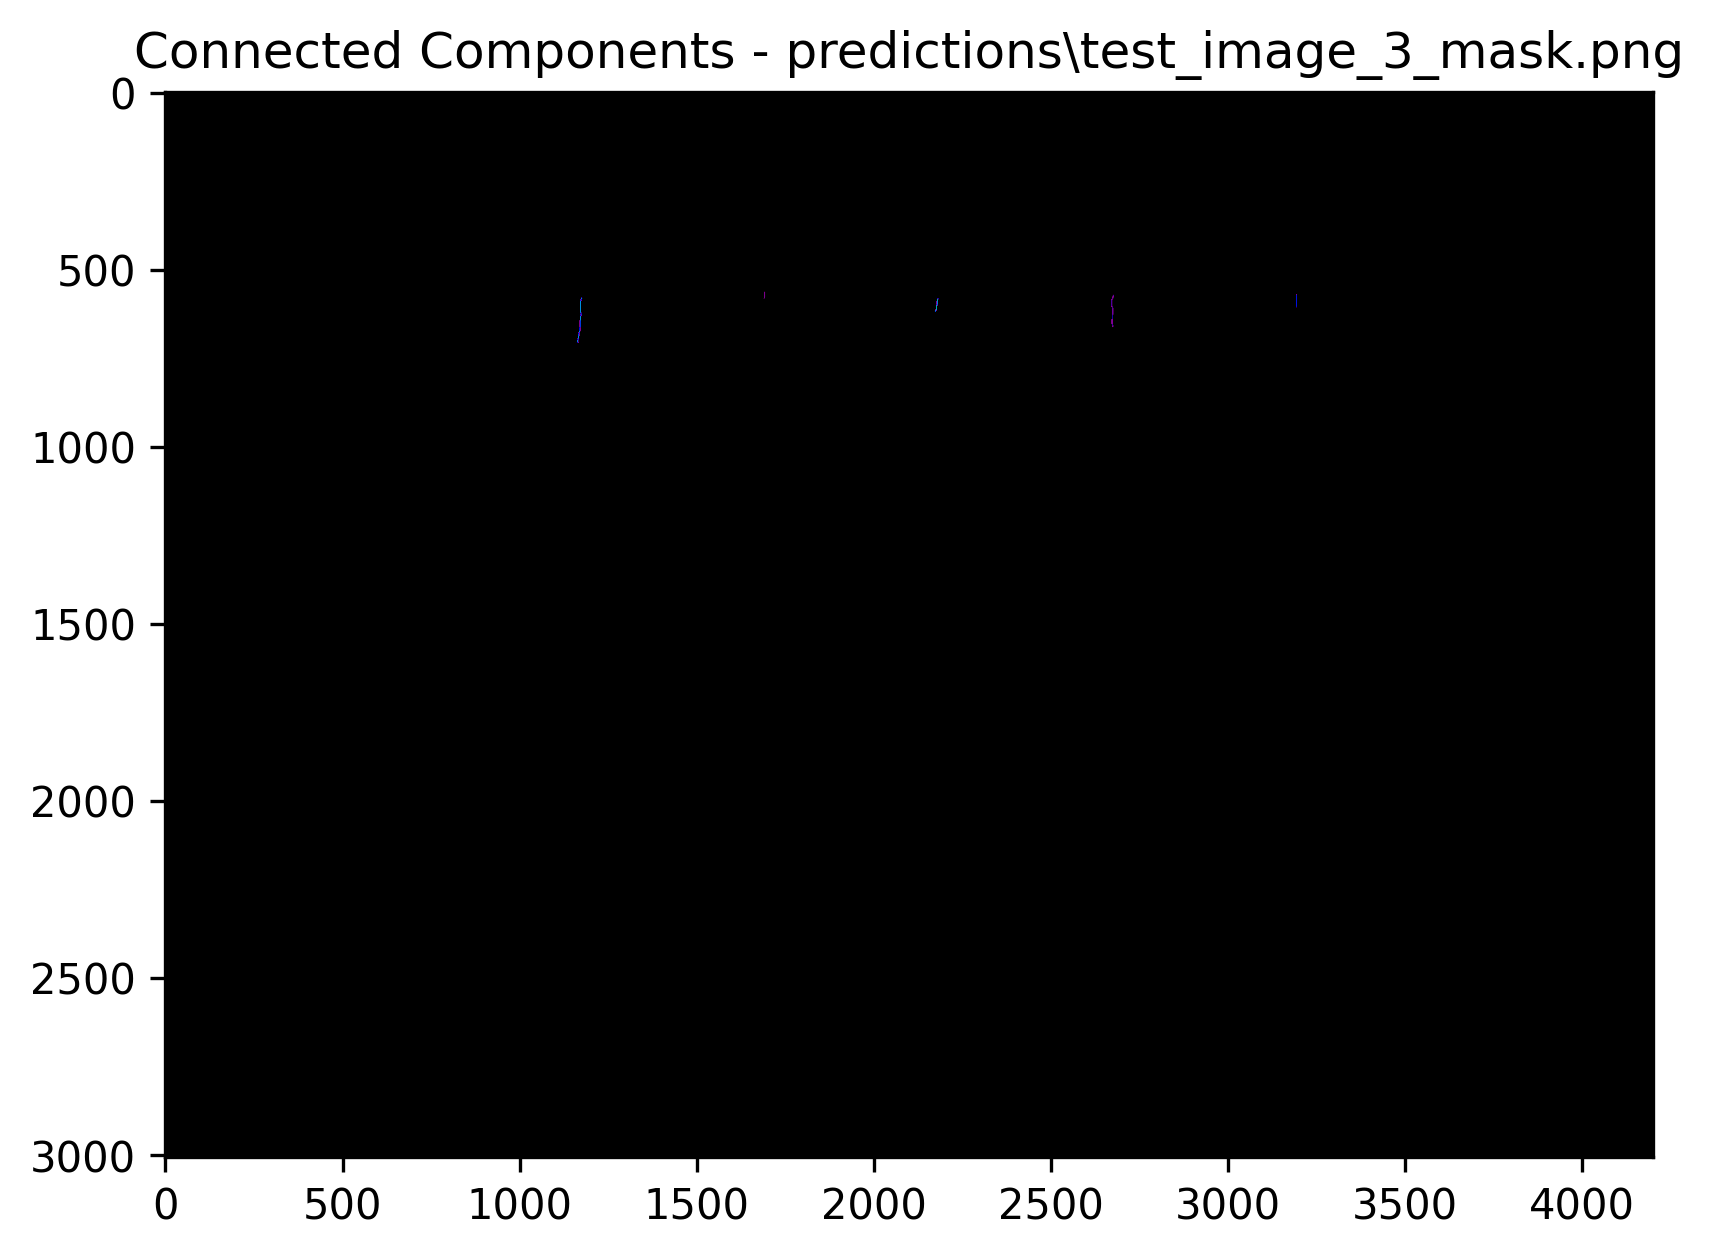

Component 1: Area=19, BBox=(1691,564,3,19)
Component 2: Area=90, BBox=(2673,573,6,90)
Component 3: Area=35, BBox=(3195,572,1,35)
Component 4: Area=128, BBox=(1165,580,12,128)
Component 5: Area=38, BBox=(2175,582,9,38)
Seed testing123 [{'root_segment': array([[False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False,  True, False],
       [False,  True, False],
       [False,  True, False],
       [ True, False, False]]), 'root_length': 19, 'x': 1692, 'y': 573}, {'root_segment': array([[False, False, False, False, False,  True],
       [False, False, False, False, False,  True],
       [False, F

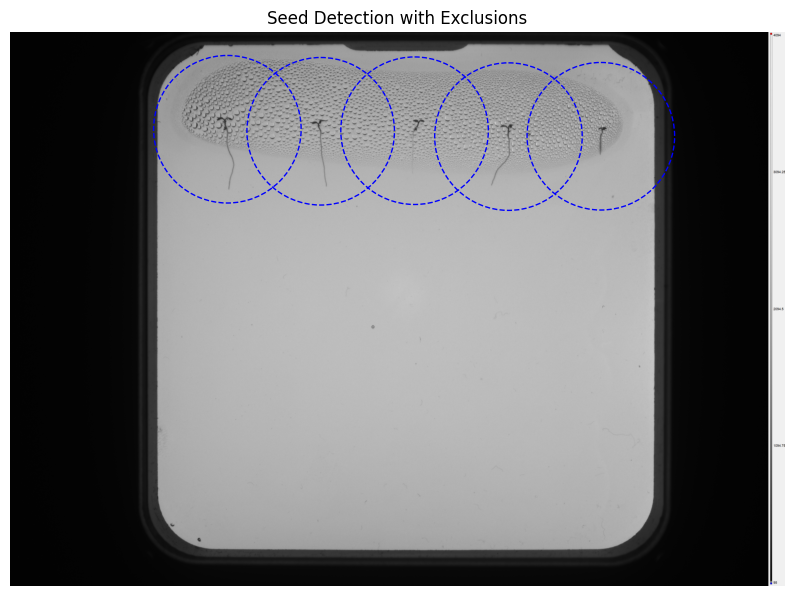

Detected seeds: []
Seeds near roots are excluded. Remaining seed count: 0


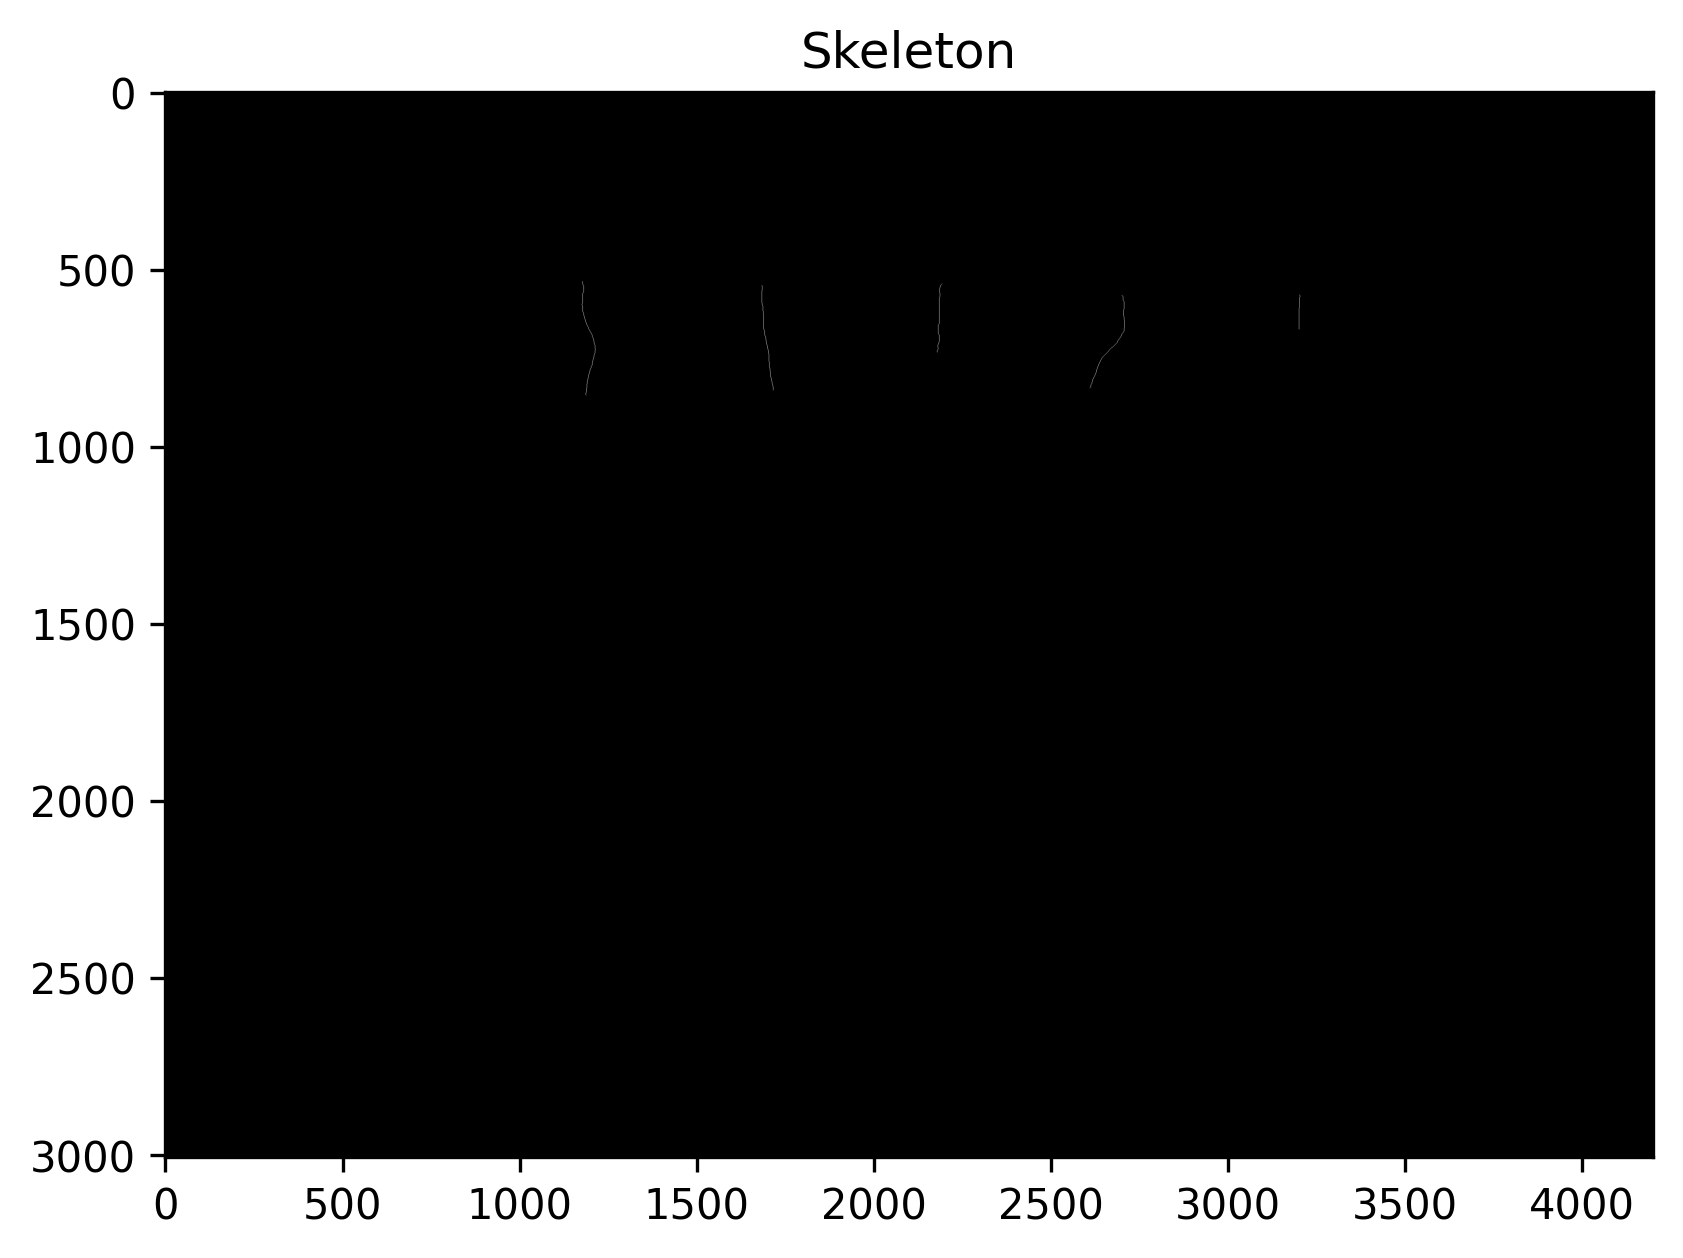

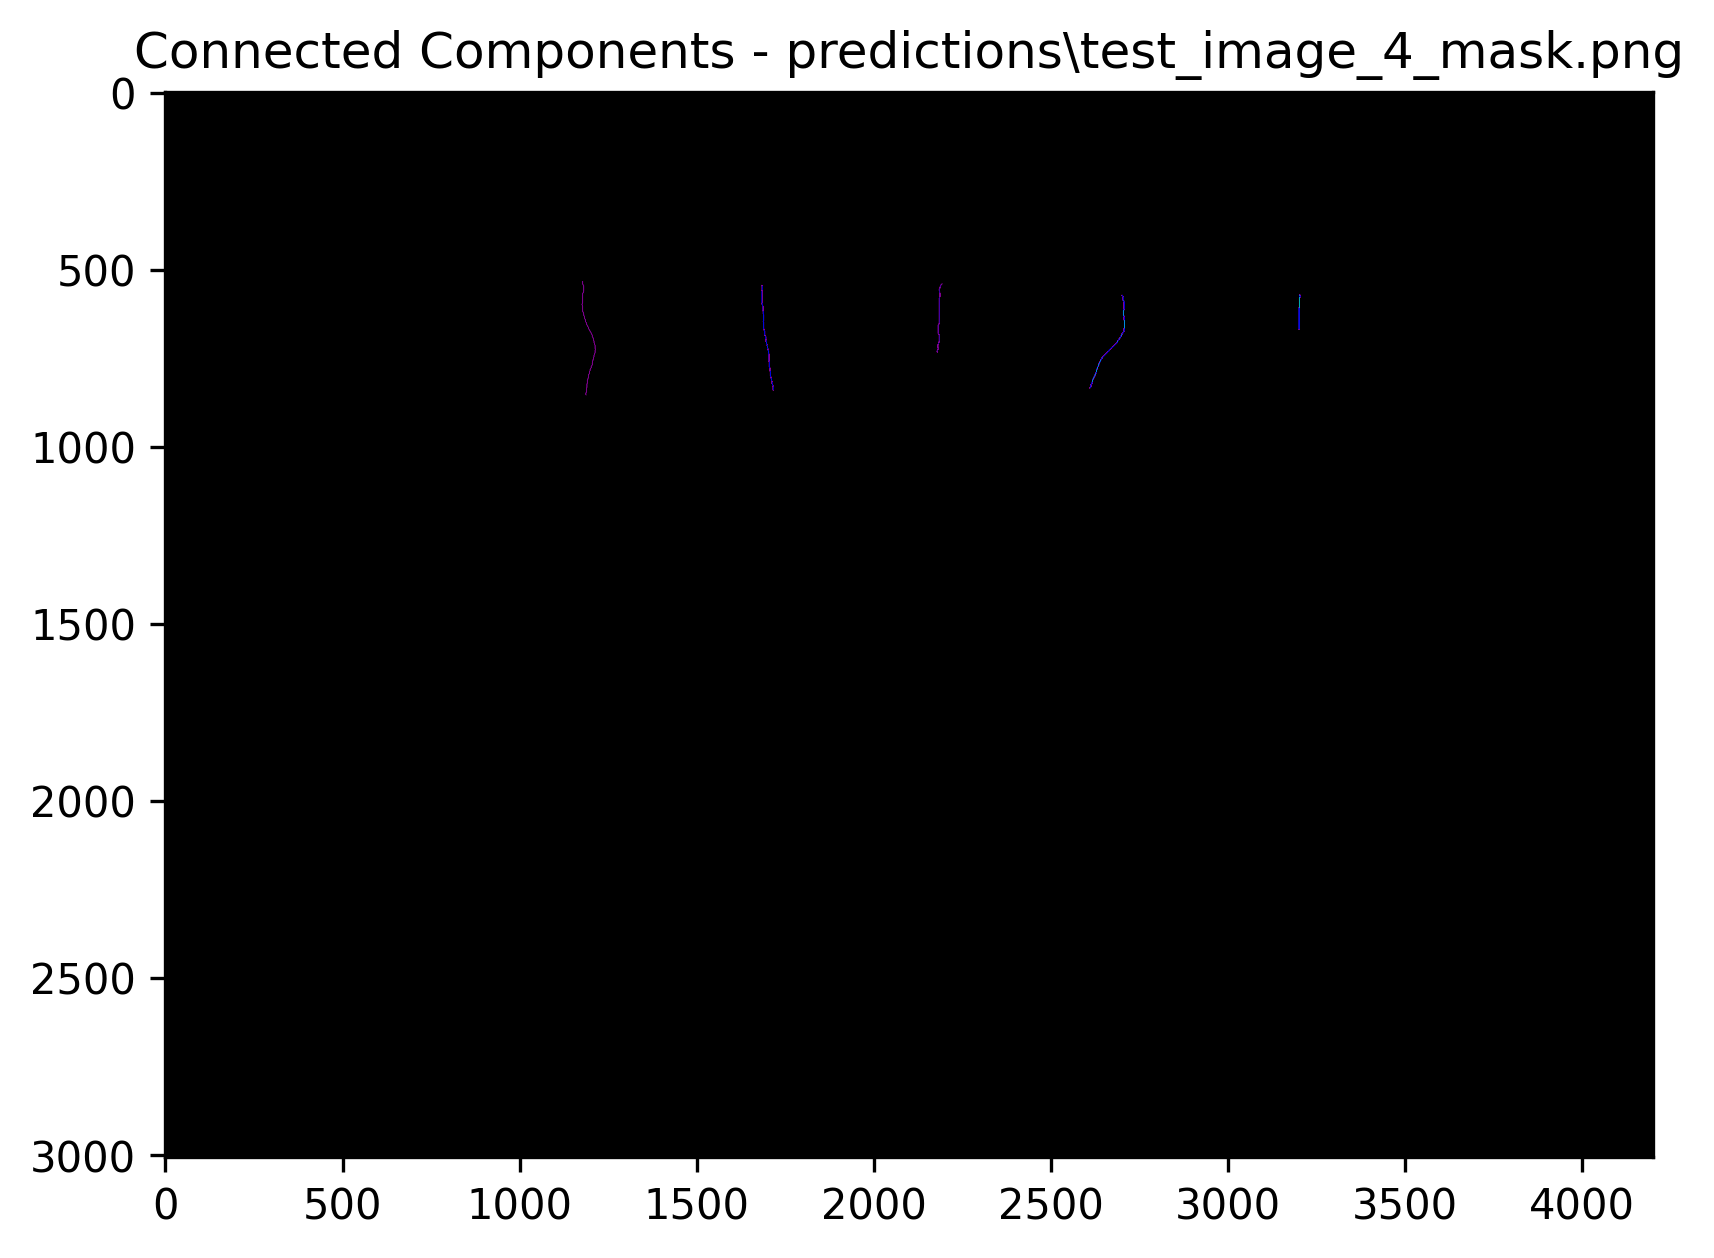

Component 1: Area=322, BBox=(1177,534,39,322)
Component 2: Area=194, BBox=(2180,541,15,194)
Component 3: Area=297, BBox=(1685,545,33,297)
Component 4: Area=264, BBox=(2611,573,99,263)
Component 5: Area=98, BBox=(3202,572,4,98)
Seed testing123 [{'root_segment': array([[False, False,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'root_length': 322, 'x': 1196, 'y': 695}, {'root_segment': array([[False, False, False, ..., False, False,  True],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ...,  True, False, False],
       ...,
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [False,  True, False, ..., Fals

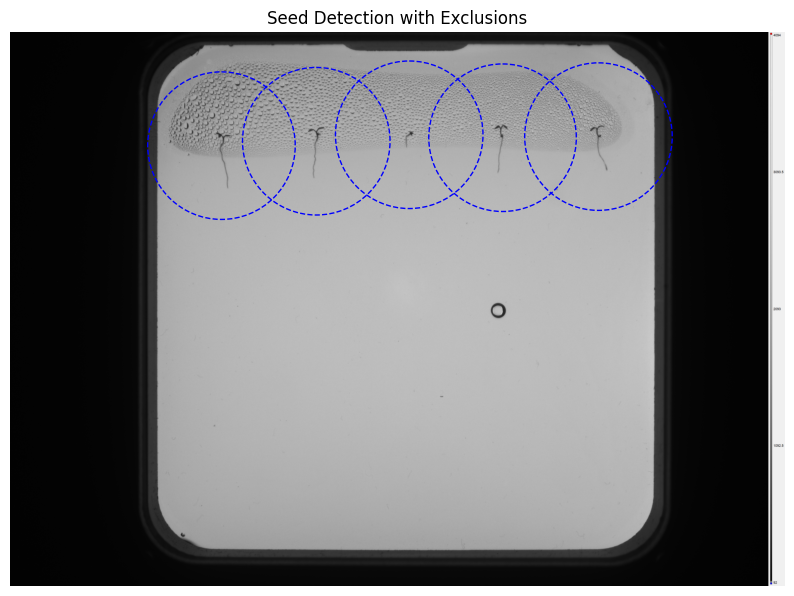

Detected seeds: []
Seeds near roots are excluded. Remaining seed count: 0


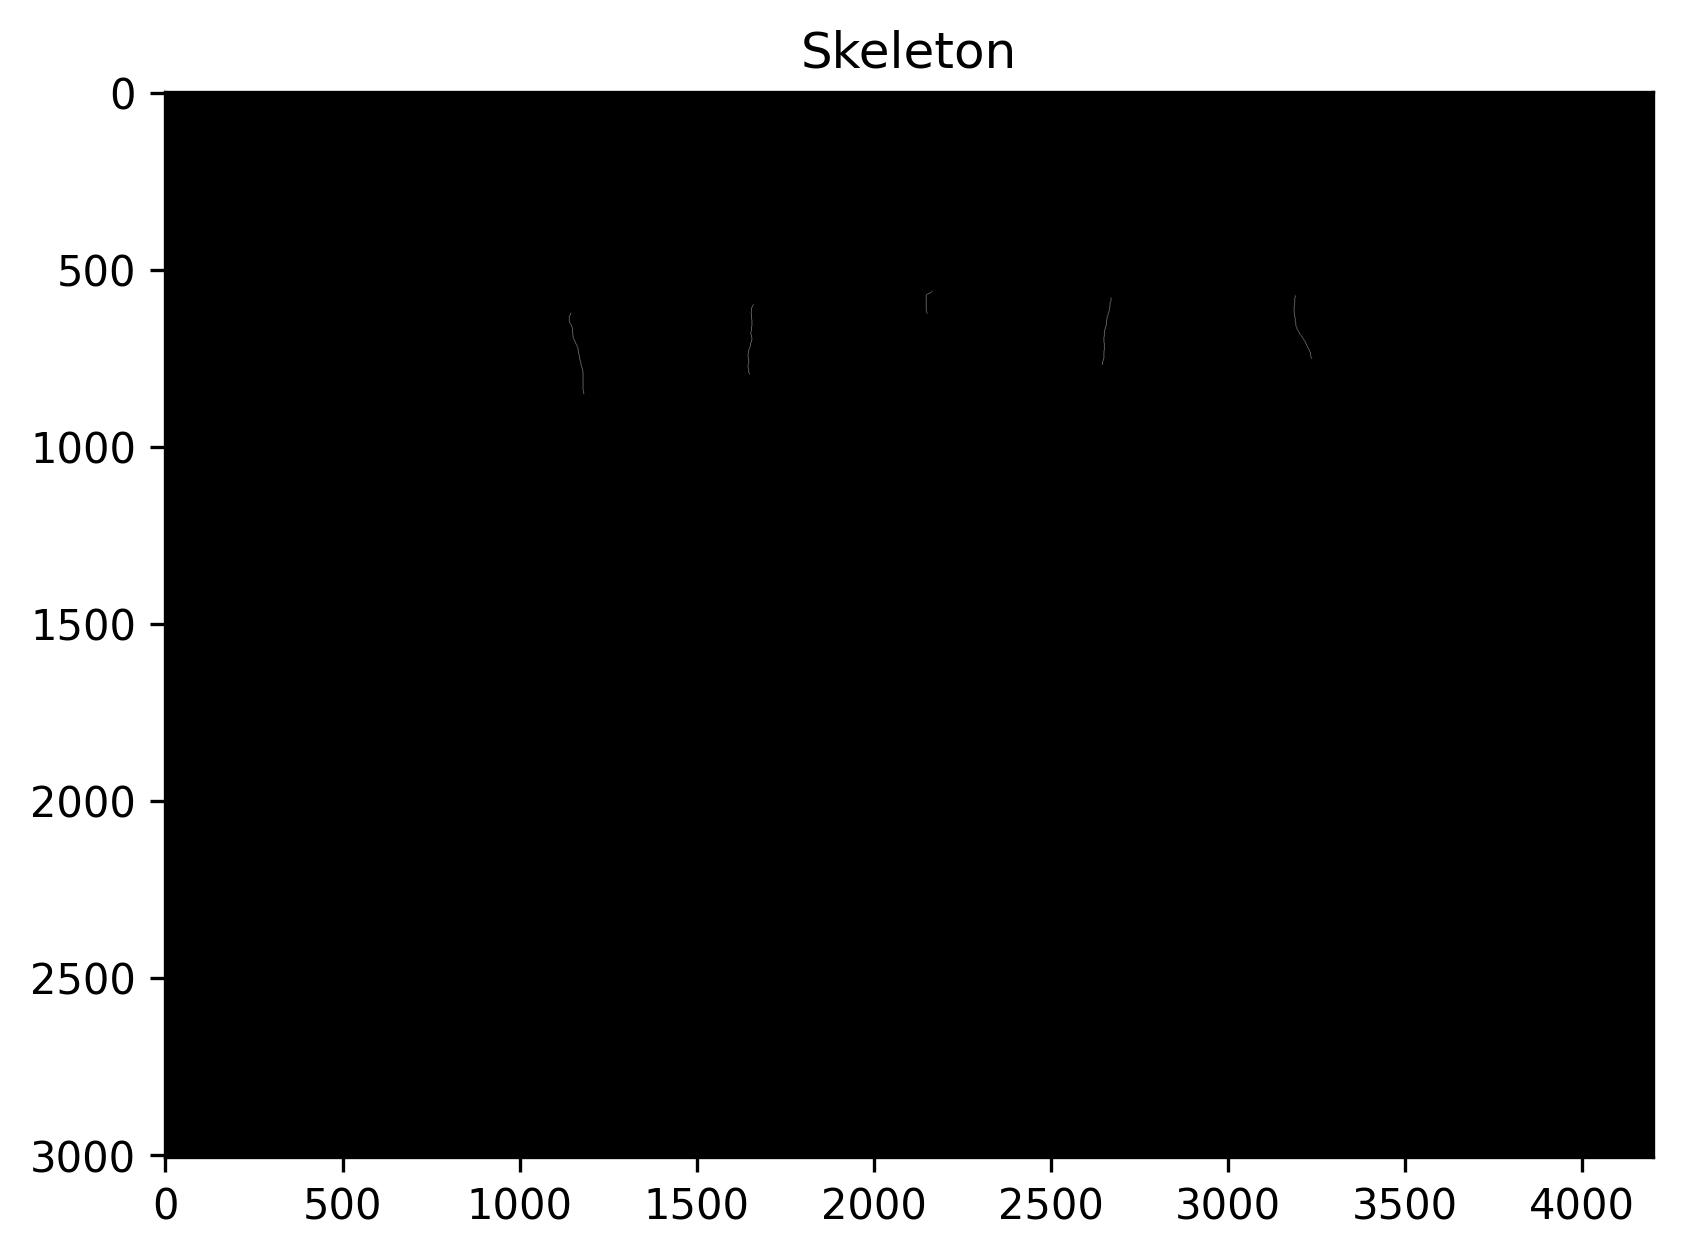

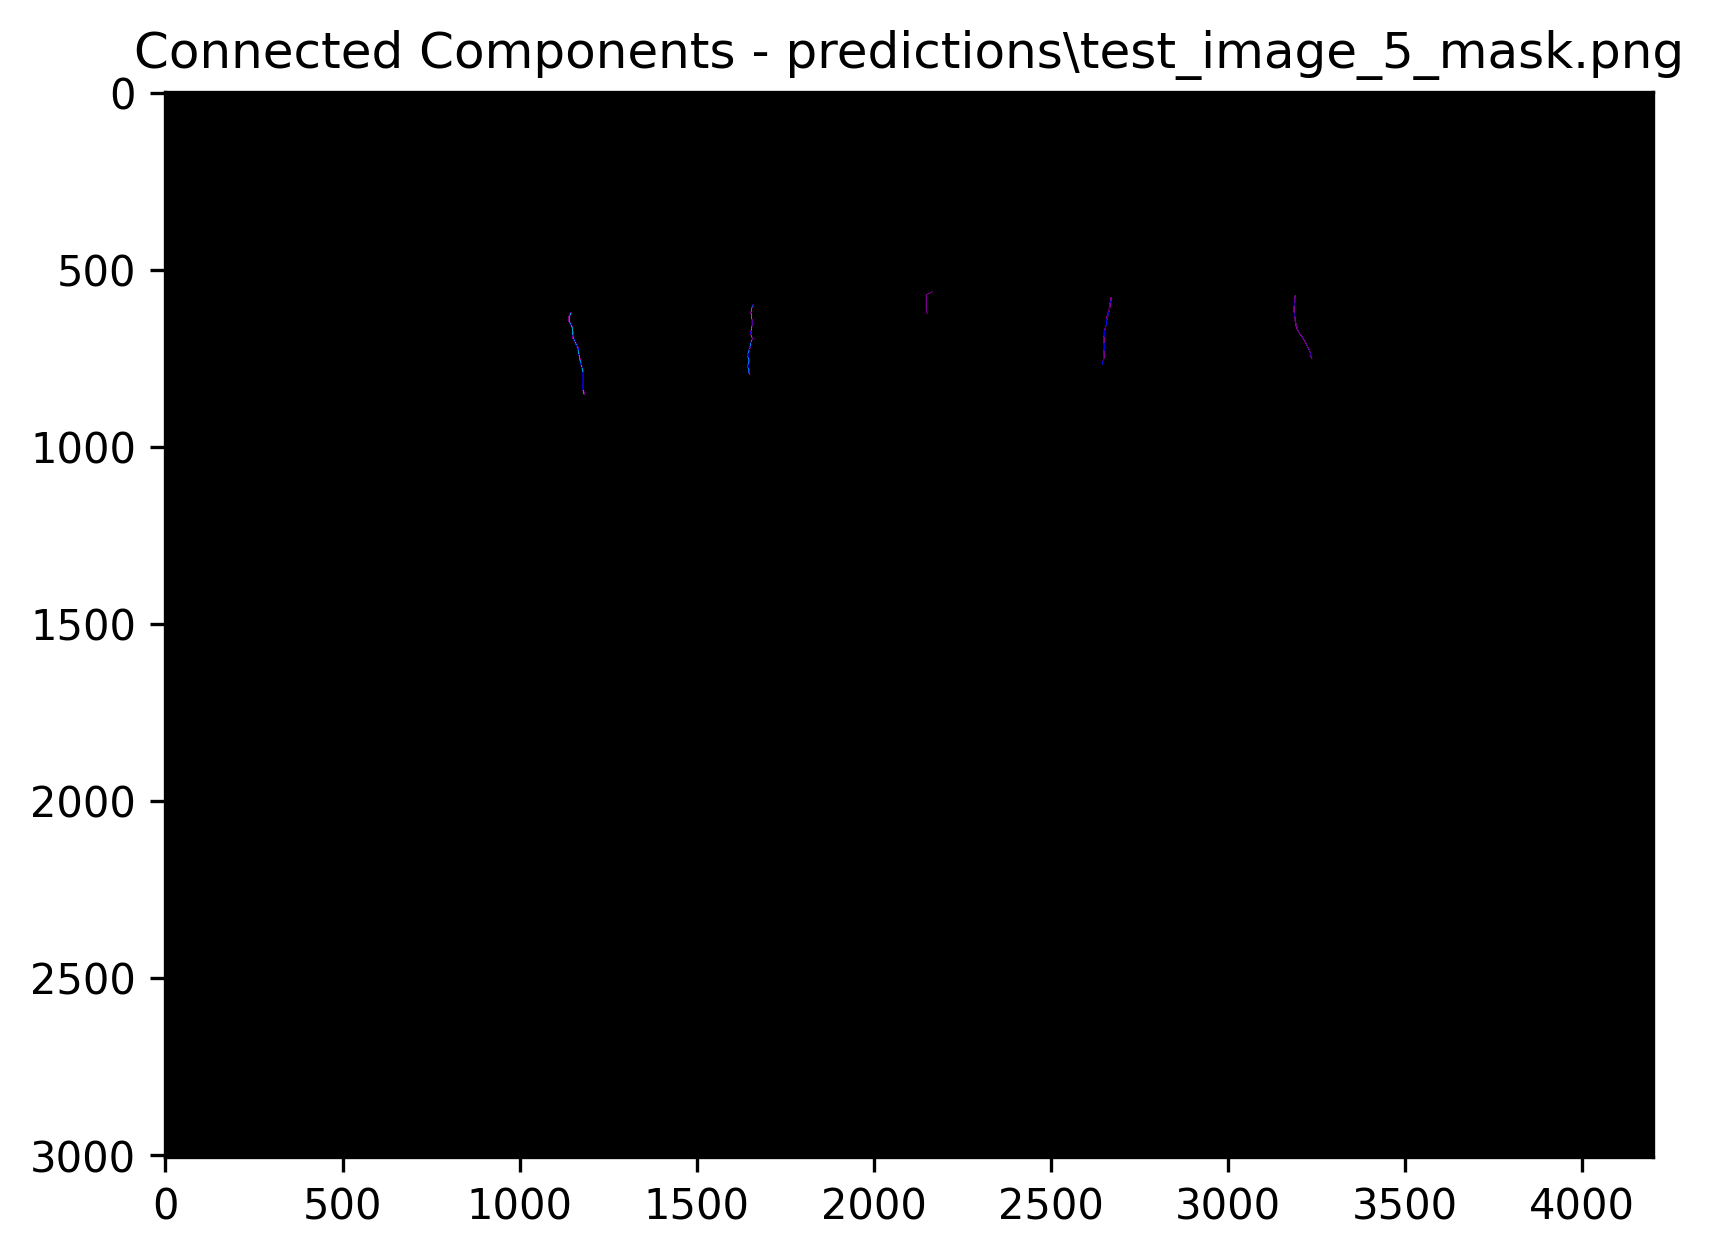

Component 1: Area=71, BBox=(2149,561,18,65)
Component 2: Area=179, BBox=(3188,574,51,179)
Component 3: Area=190, BBox=(2647,580,25,190)
Component 4: Area=198, BBox=(1646,599,16,198)
Component 5: Area=230, BBox=(1141,623,43,230)
Seed testing123 [{'root_segment': array([[False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False,  True, False],
       ...,
       [False, False,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'root_length': 71, 'x': 2158, 'y': 593}, {'root_segment': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., Fals

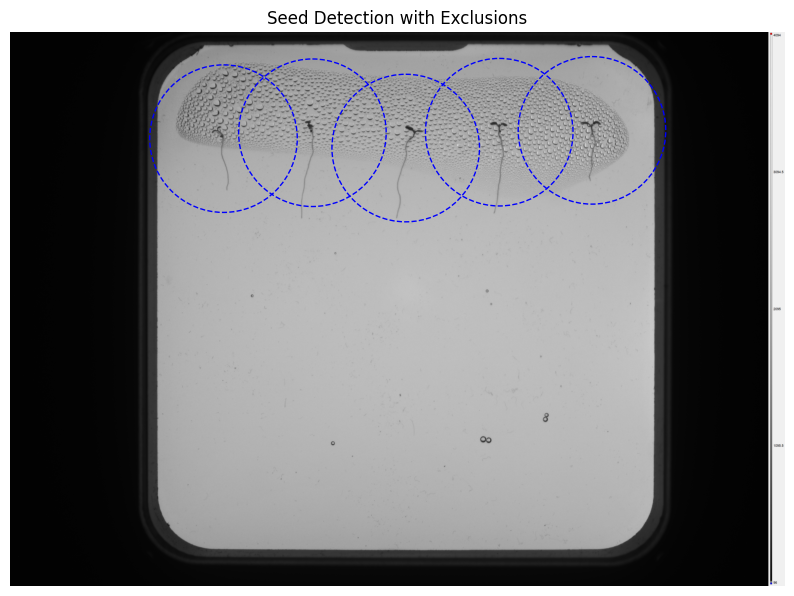

Detected seeds: []
Seeds near roots are excluded. Remaining seed count: 0


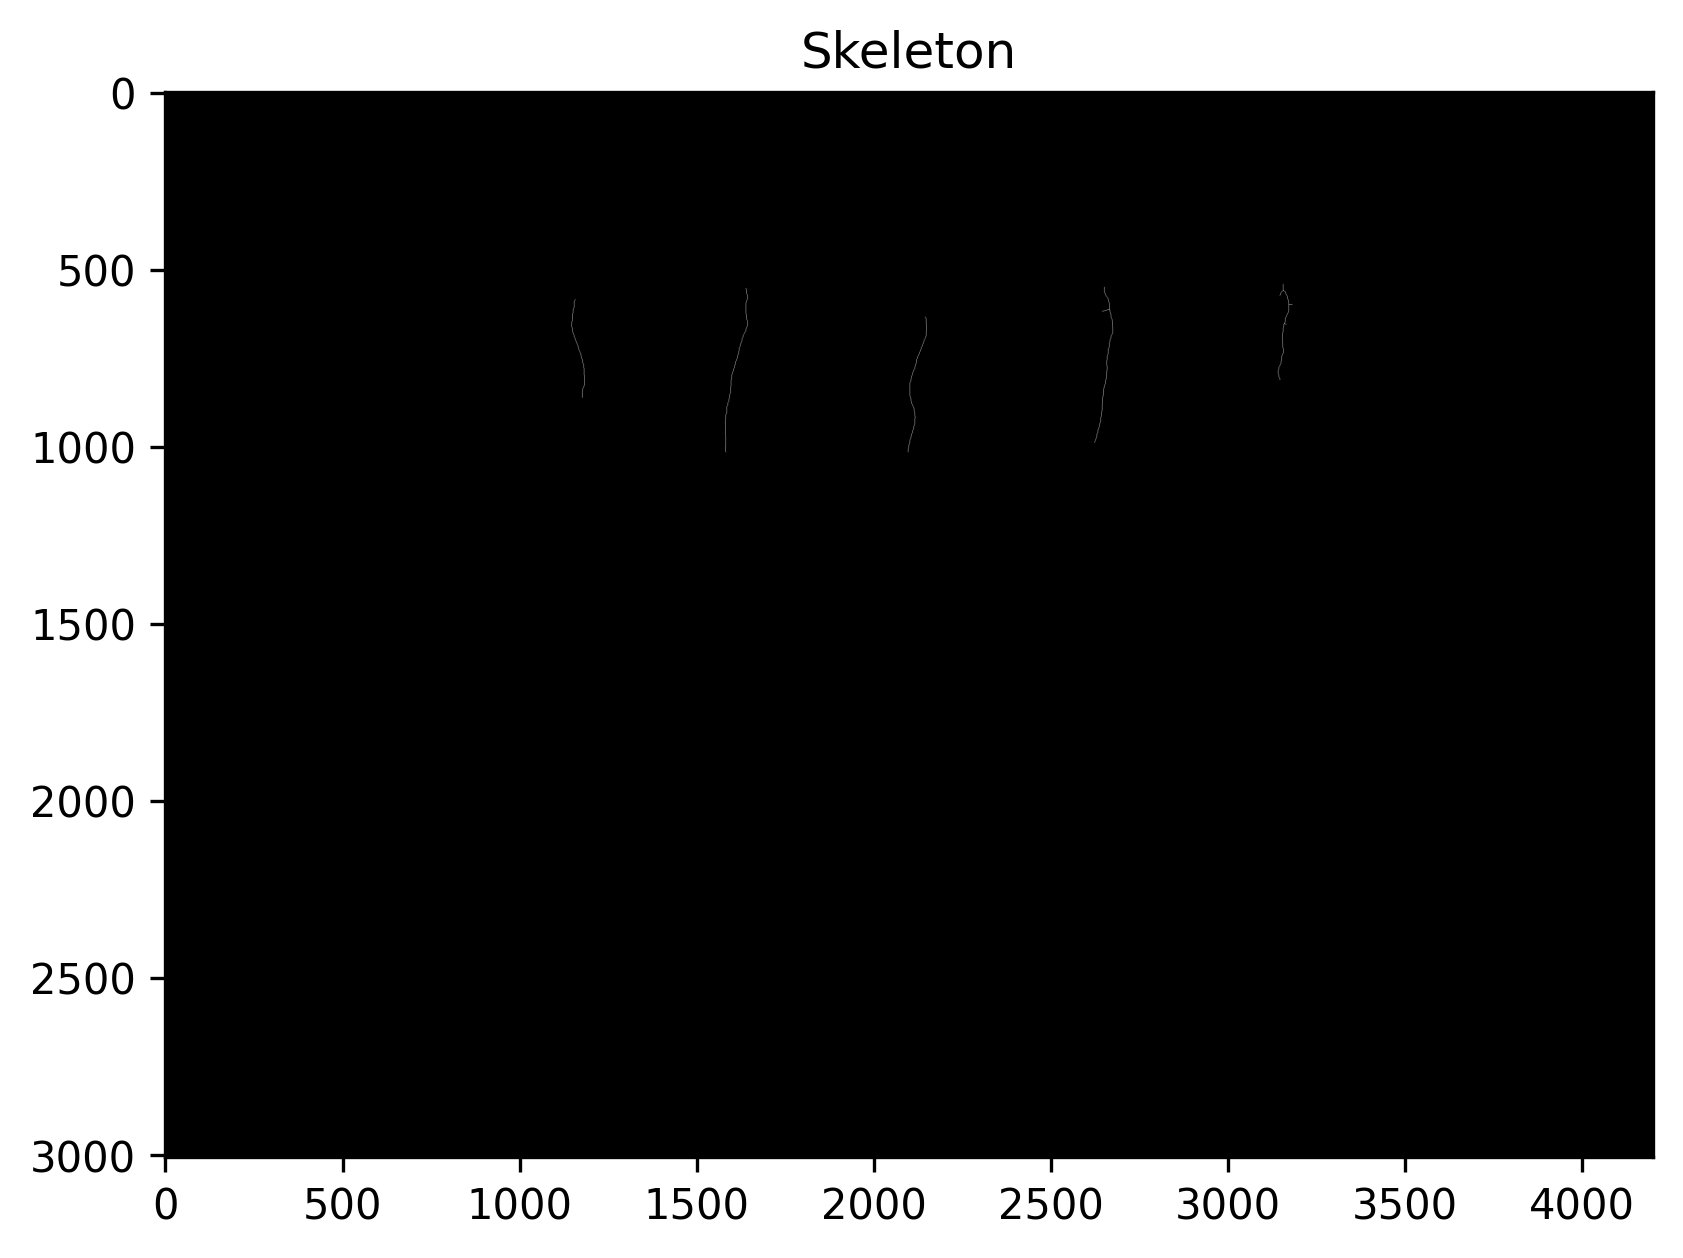

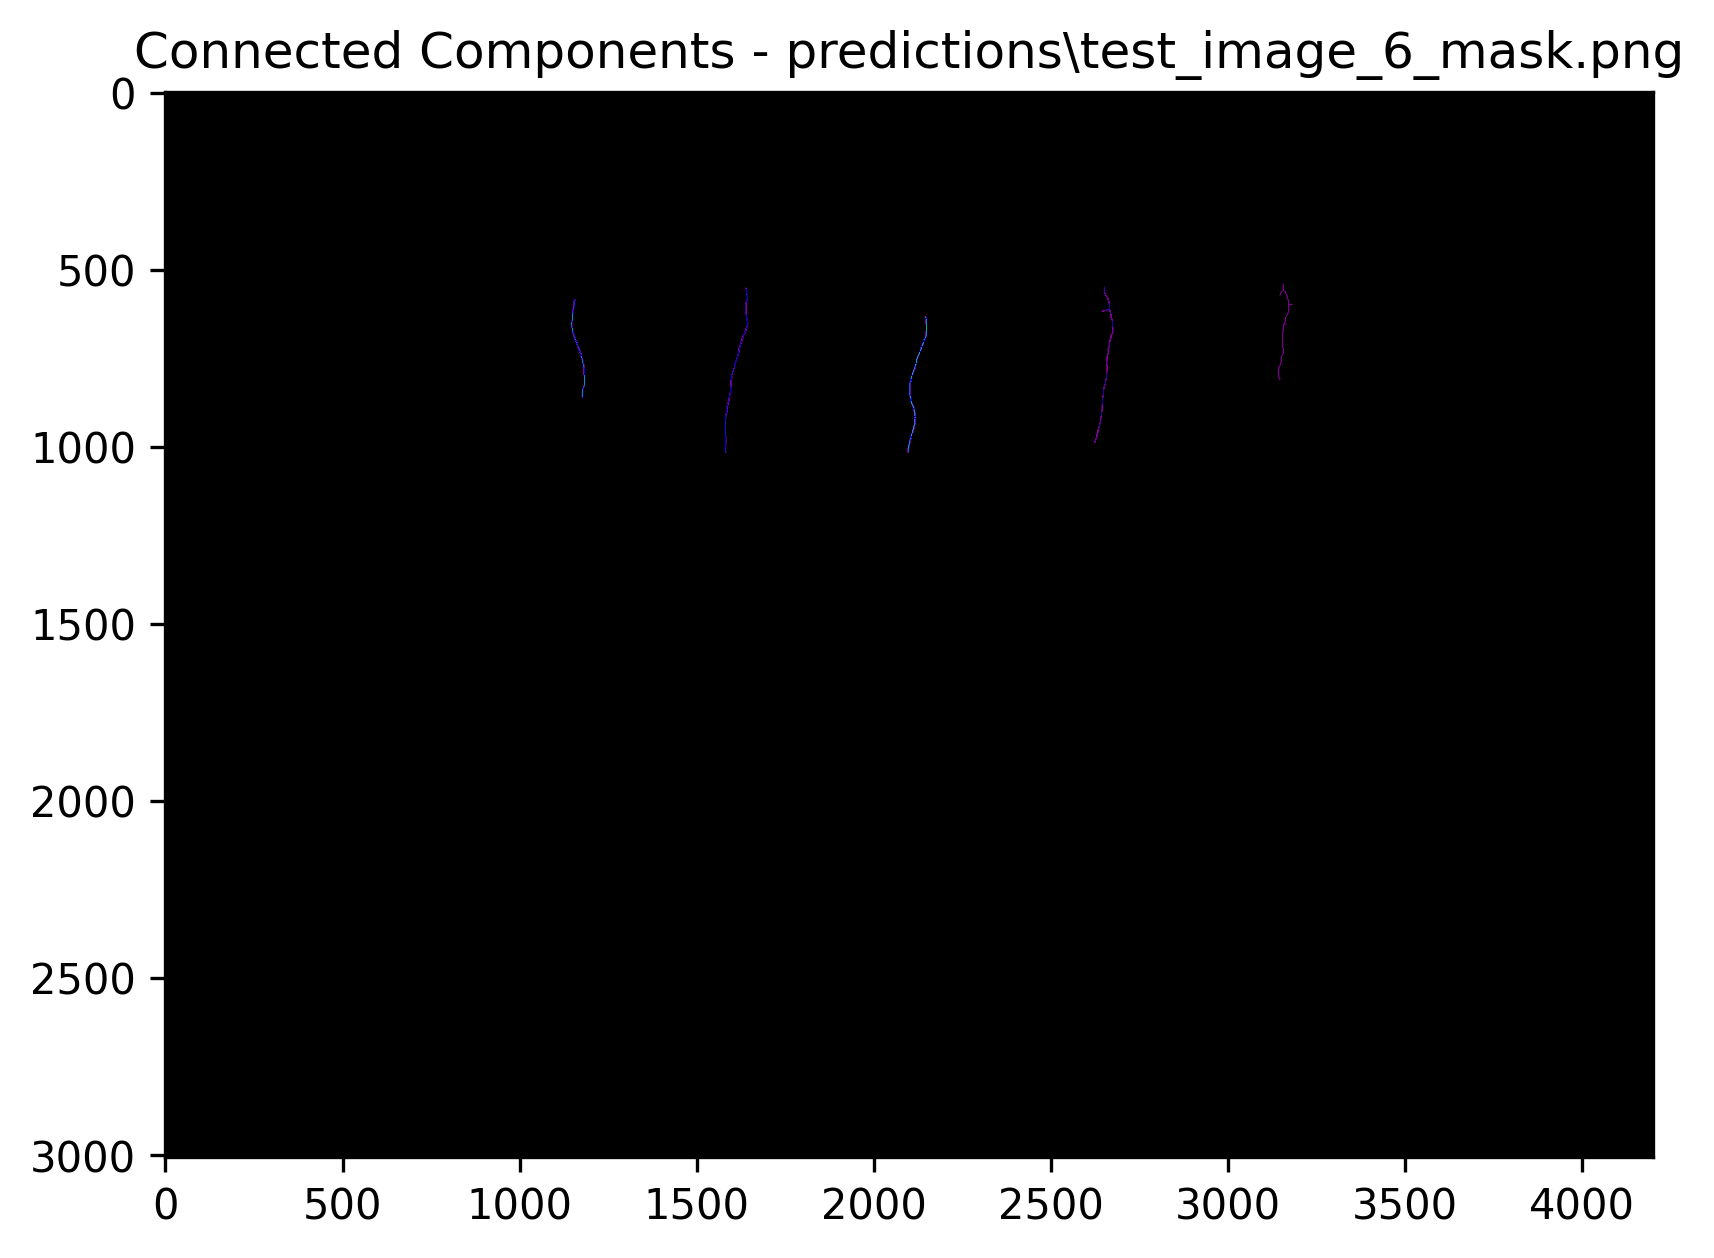

Component 1: Area=305, BBox=(3143,542,41,271)
Component 2: Area=461, BBox=(2625,550,52,440)
Component 3: Area=464, BBox=(1582,553,64,464)
Component 4: Area=278, BBox=(1148,585,37,278)
Component 5: Area=383, BBox=(2098,634,53,383)
Seed testing123 [{'root_segment': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'root_length': 305, 'x': 3163, 'y': 677}, {'root_segment': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [False,  True, False, ..., F

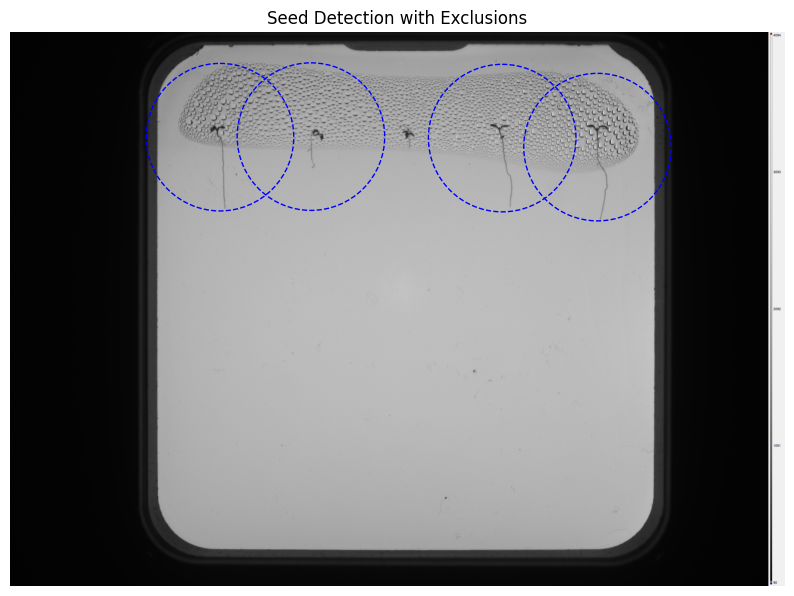

Detected seeds: []
Seeds near roots are excluded. Remaining seed count: 0


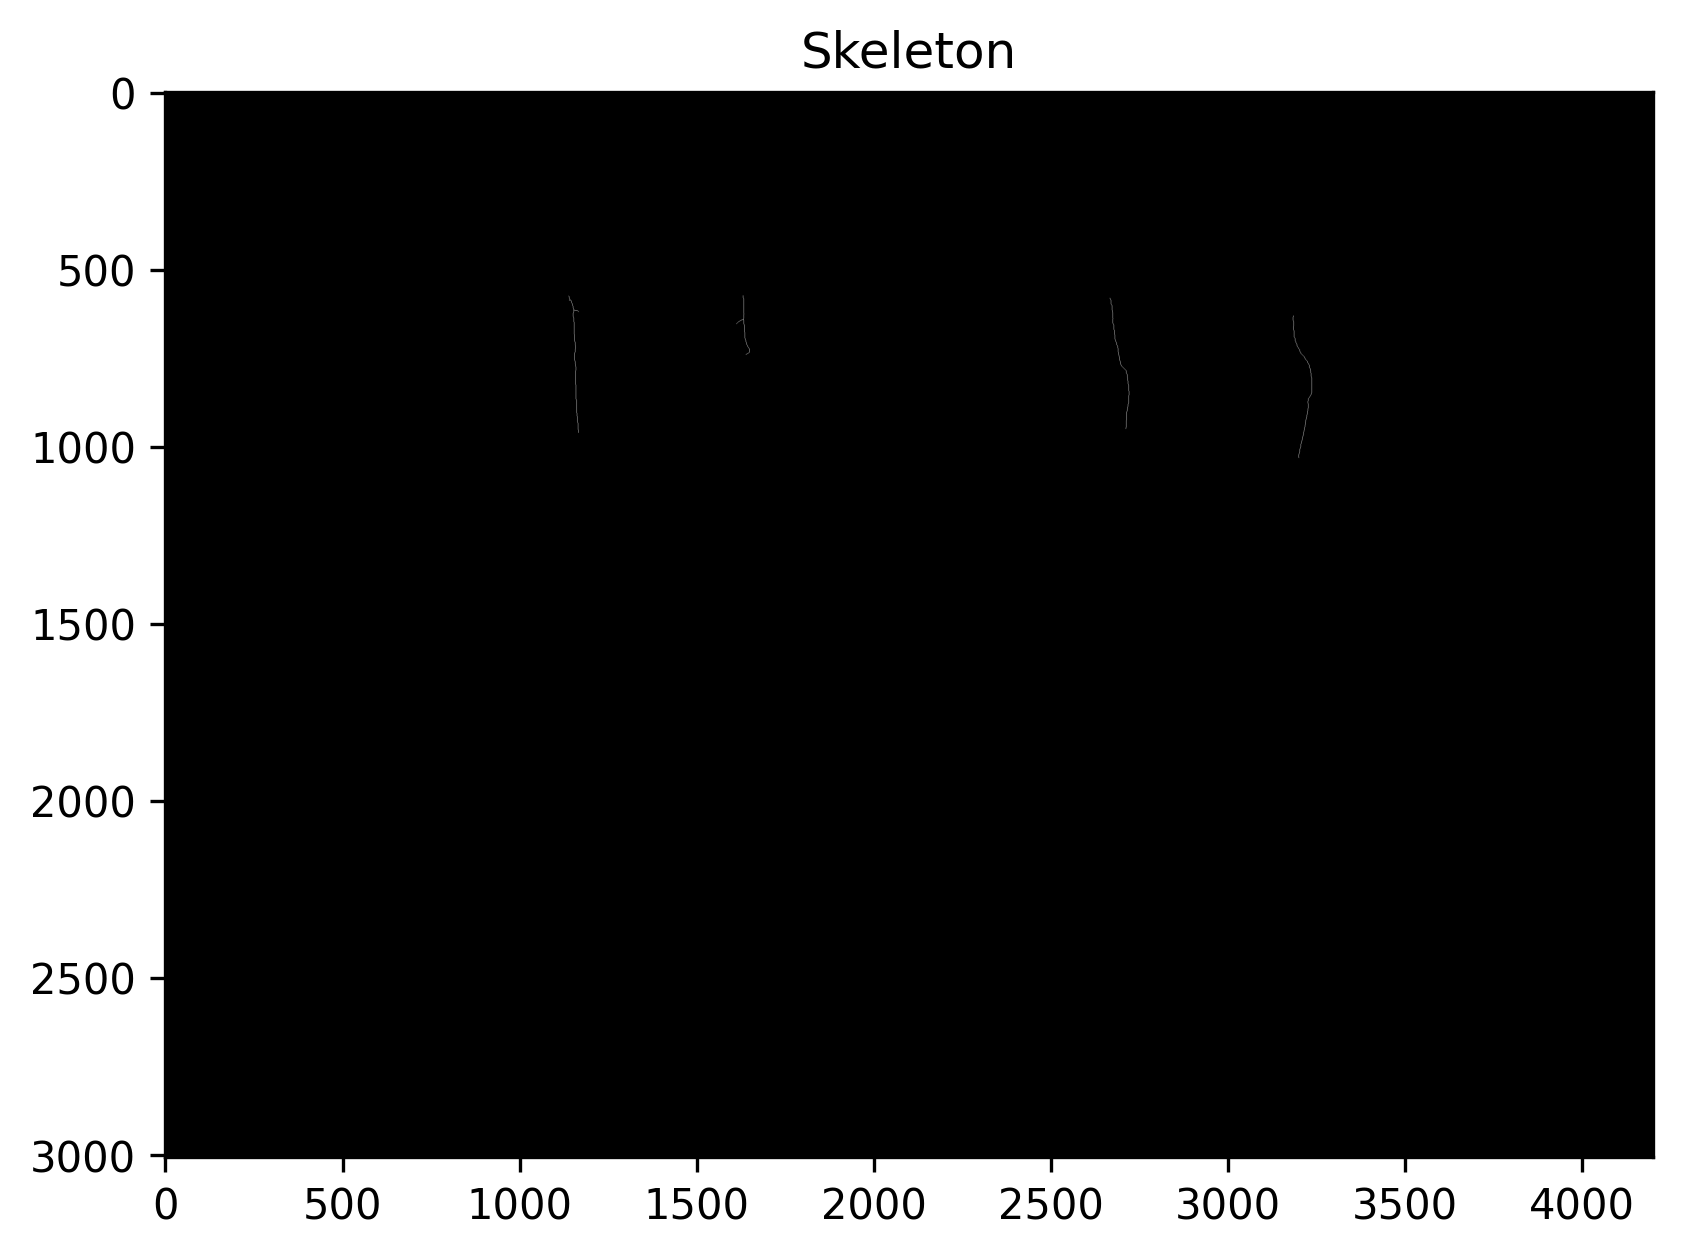

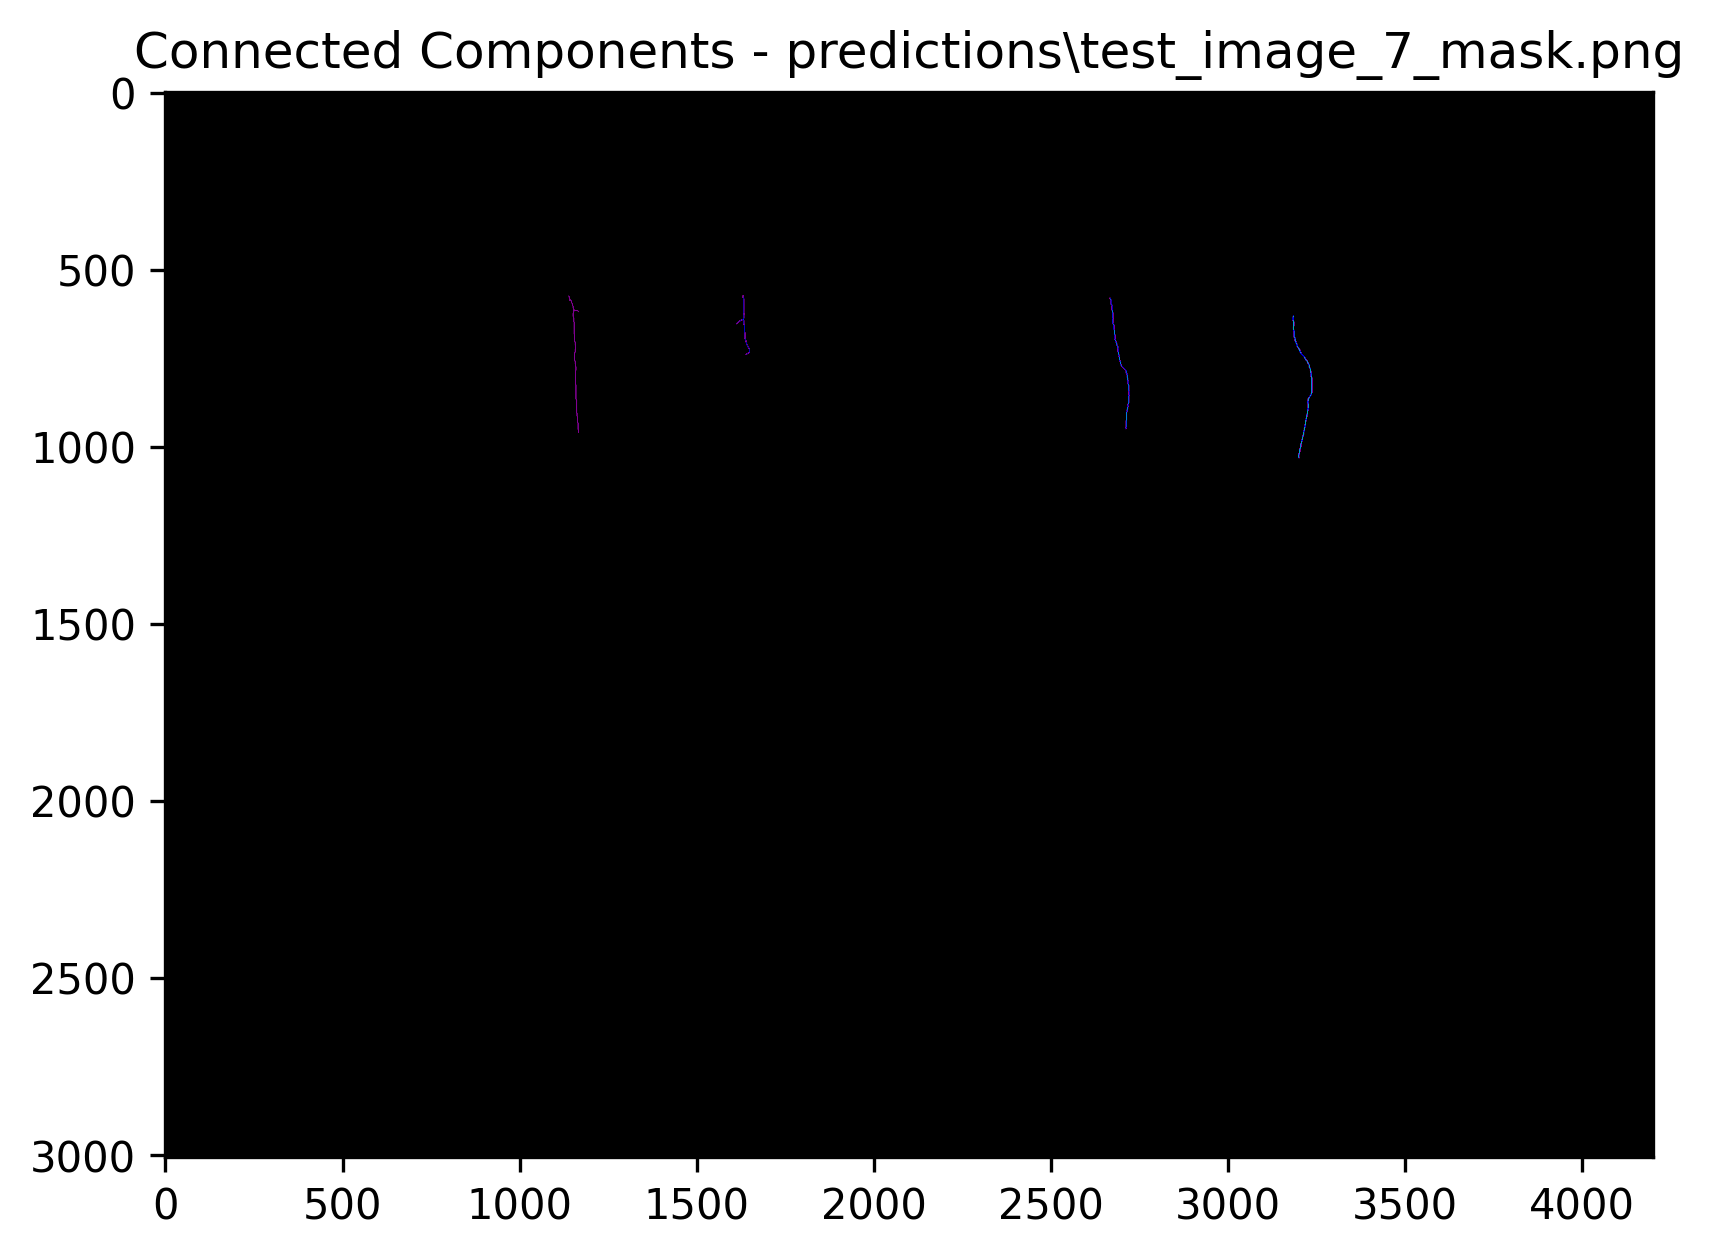

Component 1: Area=405, BBox=(1139,575,30,387)
Component 2: Area=191, BBox=(1613,574,38,168)
Component 3: Area=370, BBox=(2668,581,55,370)
Component 4: Area=402, BBox=(3185,631,54,402)
Seed testing123 [{'root_segment': array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False,  True, False]]), 'root_length': 405, 'x': 1154, 'y': 768}, {'root_segment': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'root_length': 191, 'x'

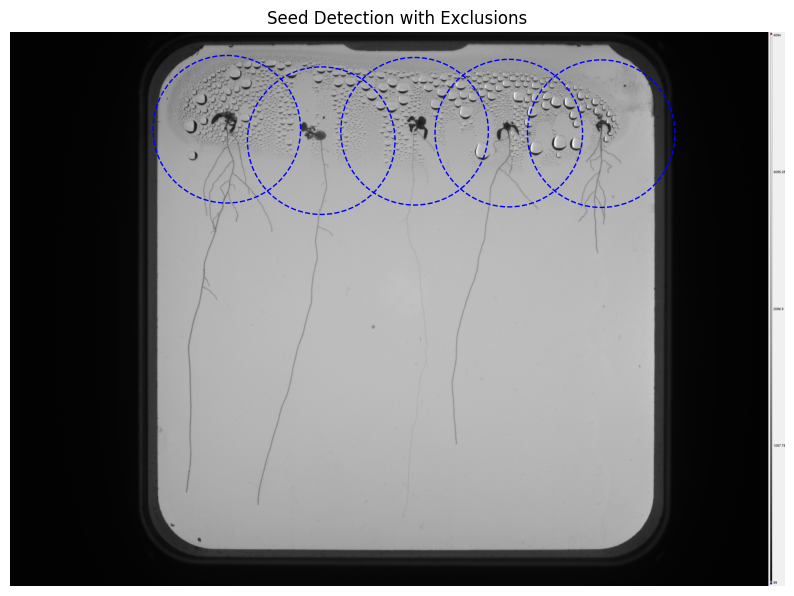

Detected seeds: []
Seeds near roots are excluded. Remaining seed count: 0


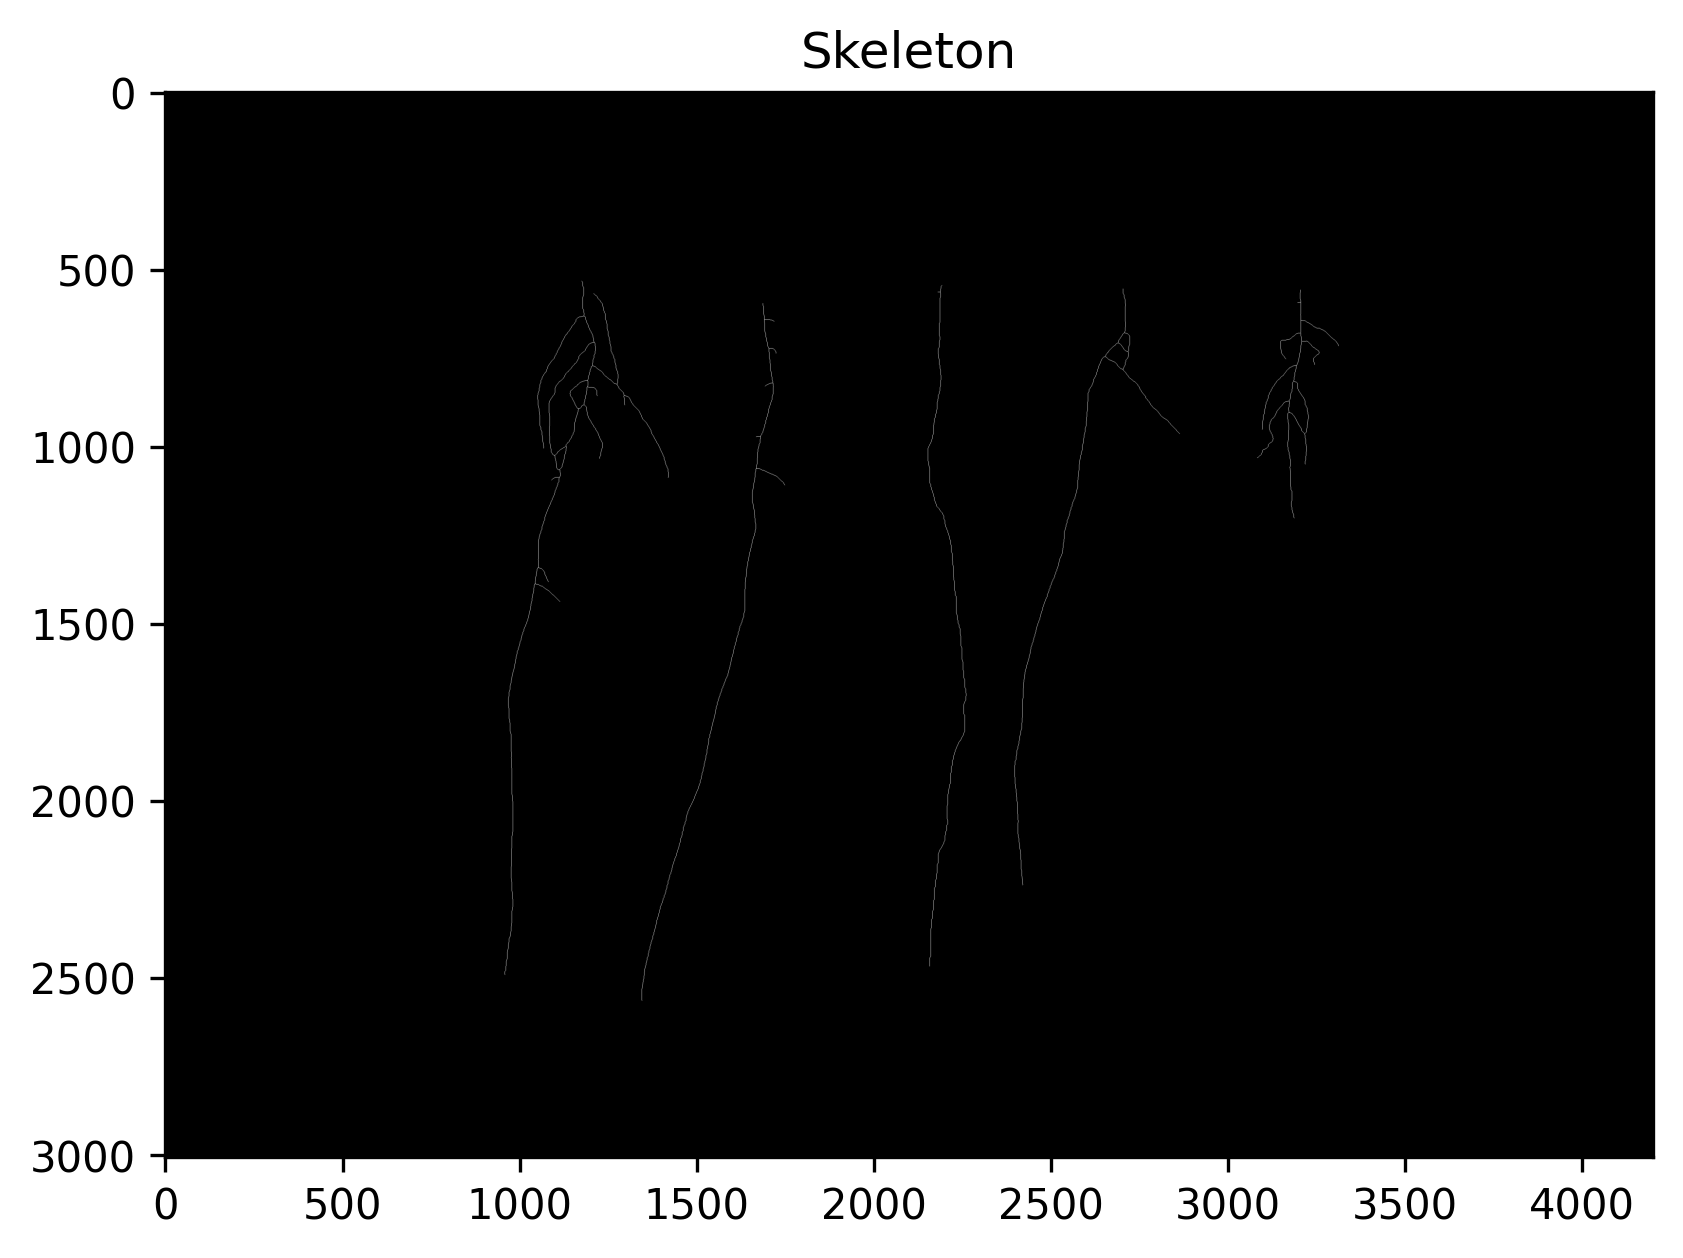

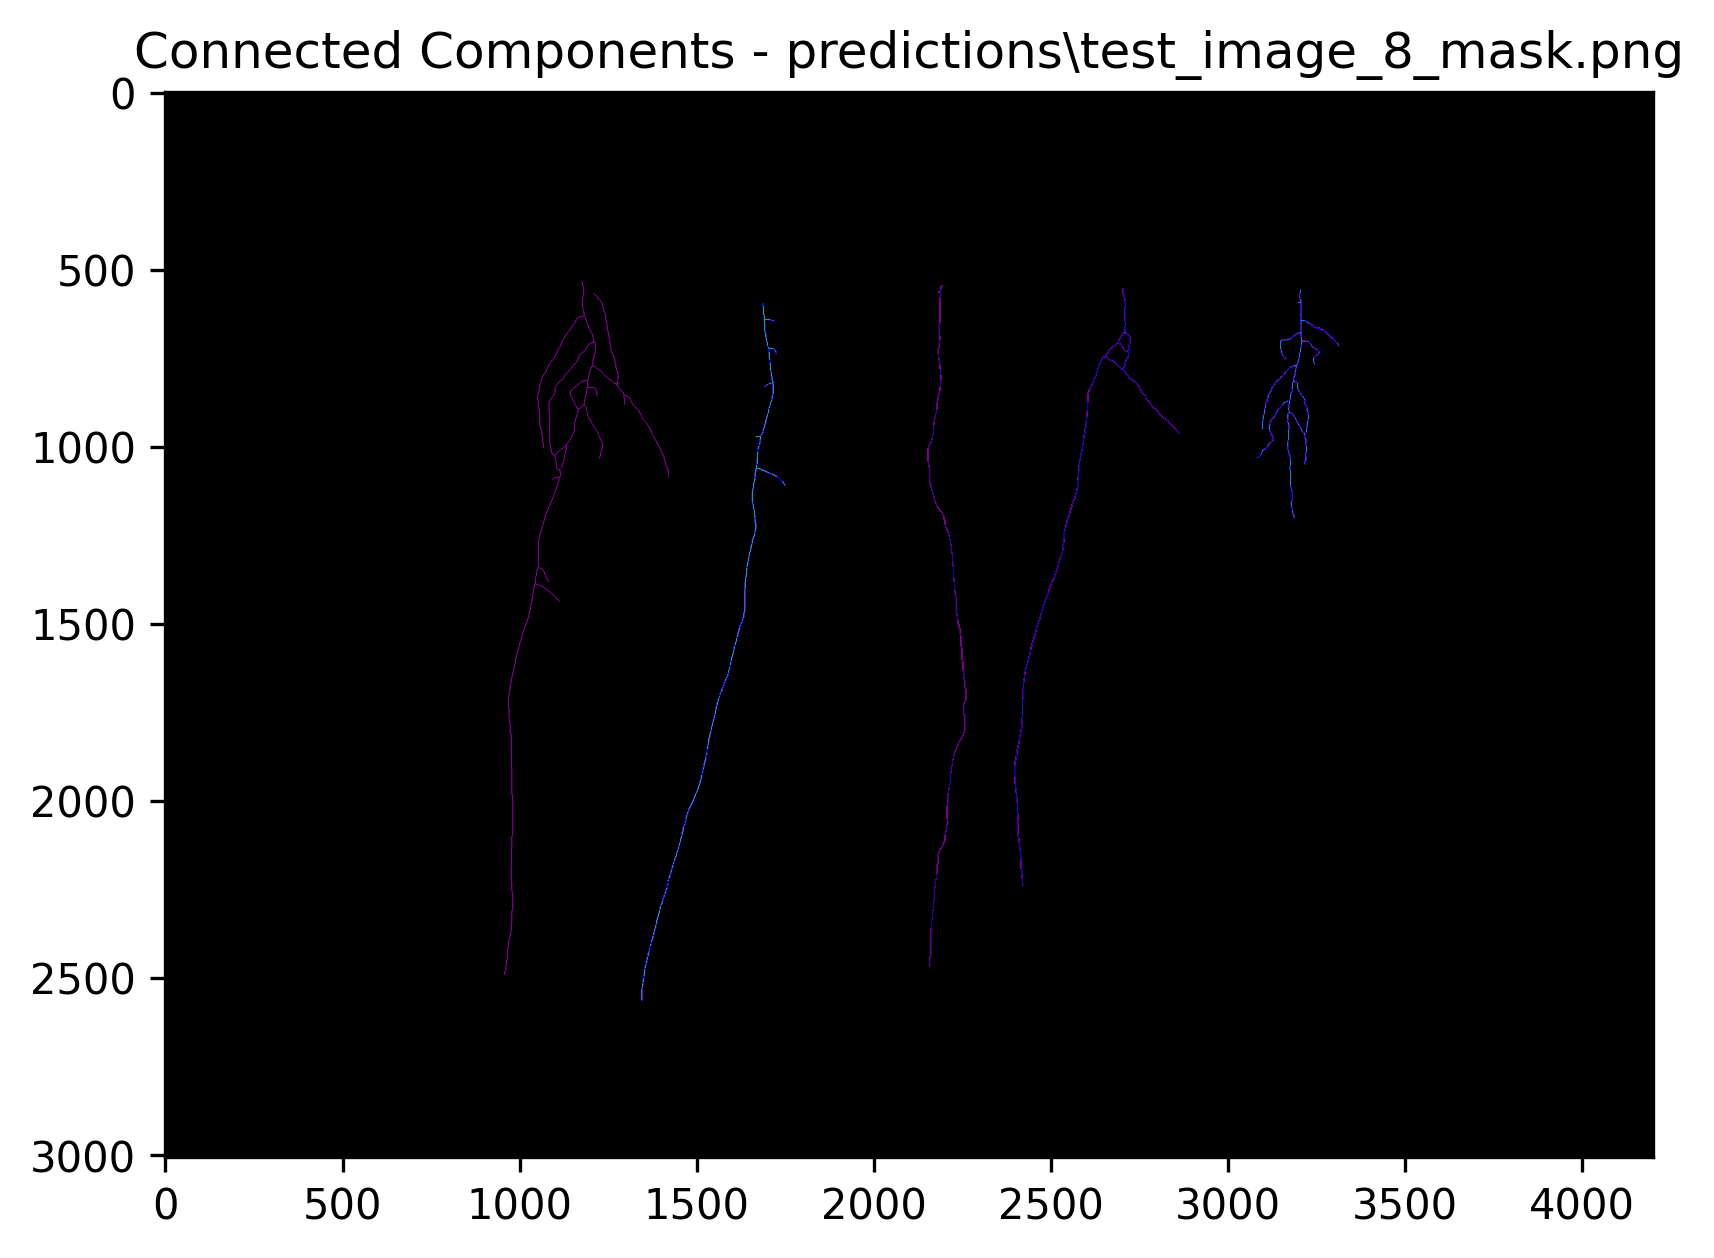

Component 1: Area=3834, BBox=(959,533,463,1959)
Component 2: Area=1931, BBox=(2154,545,109,1923)
Component 3: Area=2077, BBox=(2399,555,467,1684)
Component 4: Area=1643, BBox=(3084,558,230,645)
Component 5: Area=2141, BBox=(1346,596,405,1969)
Seed testing123 [{'root_segment': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False]]), 'root_length': 3834, 'x': 1190, 'y': 1512}, {'root_segment': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False

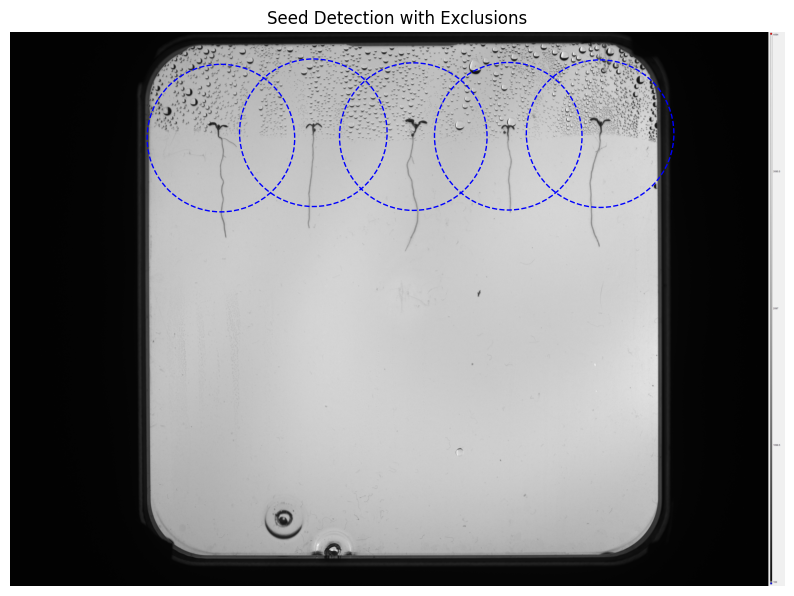

Detected seeds: []
Seeds near roots are excluded. Remaining seed count: 0


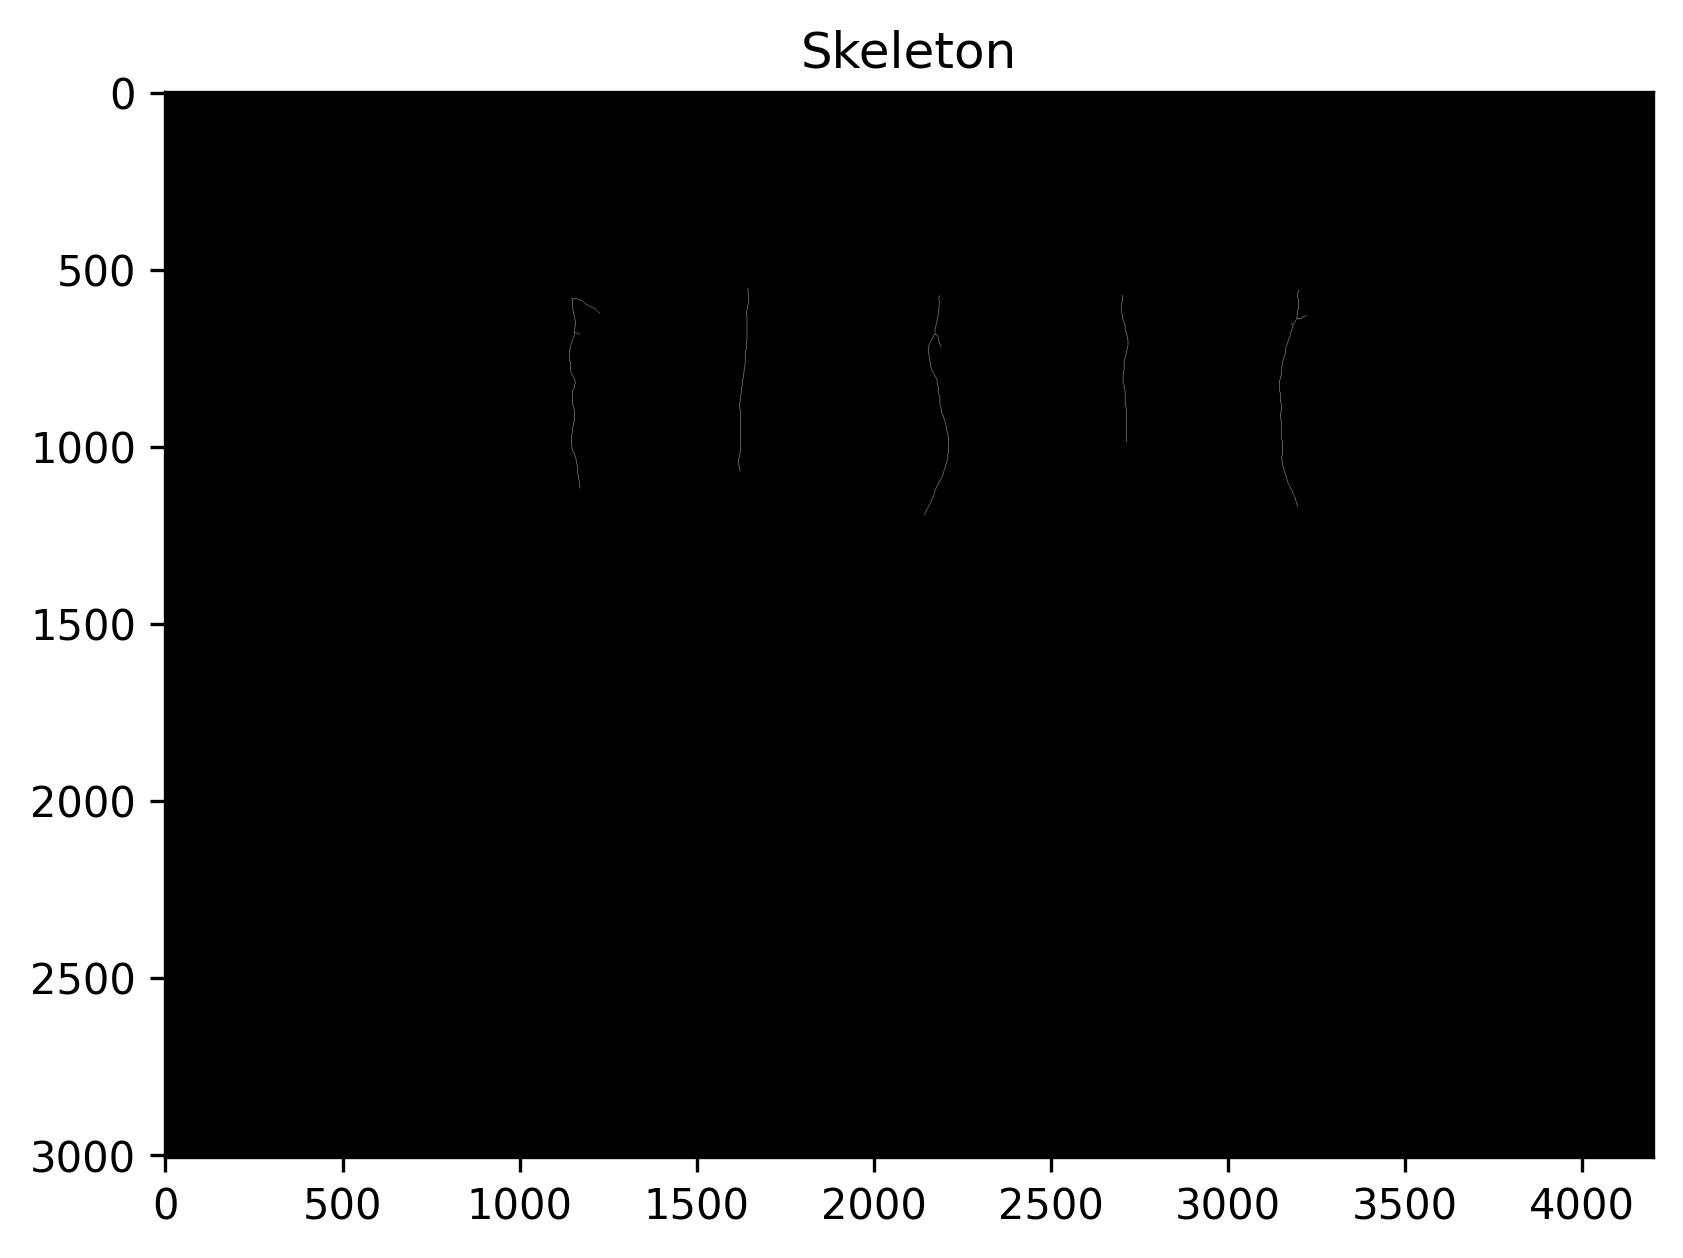

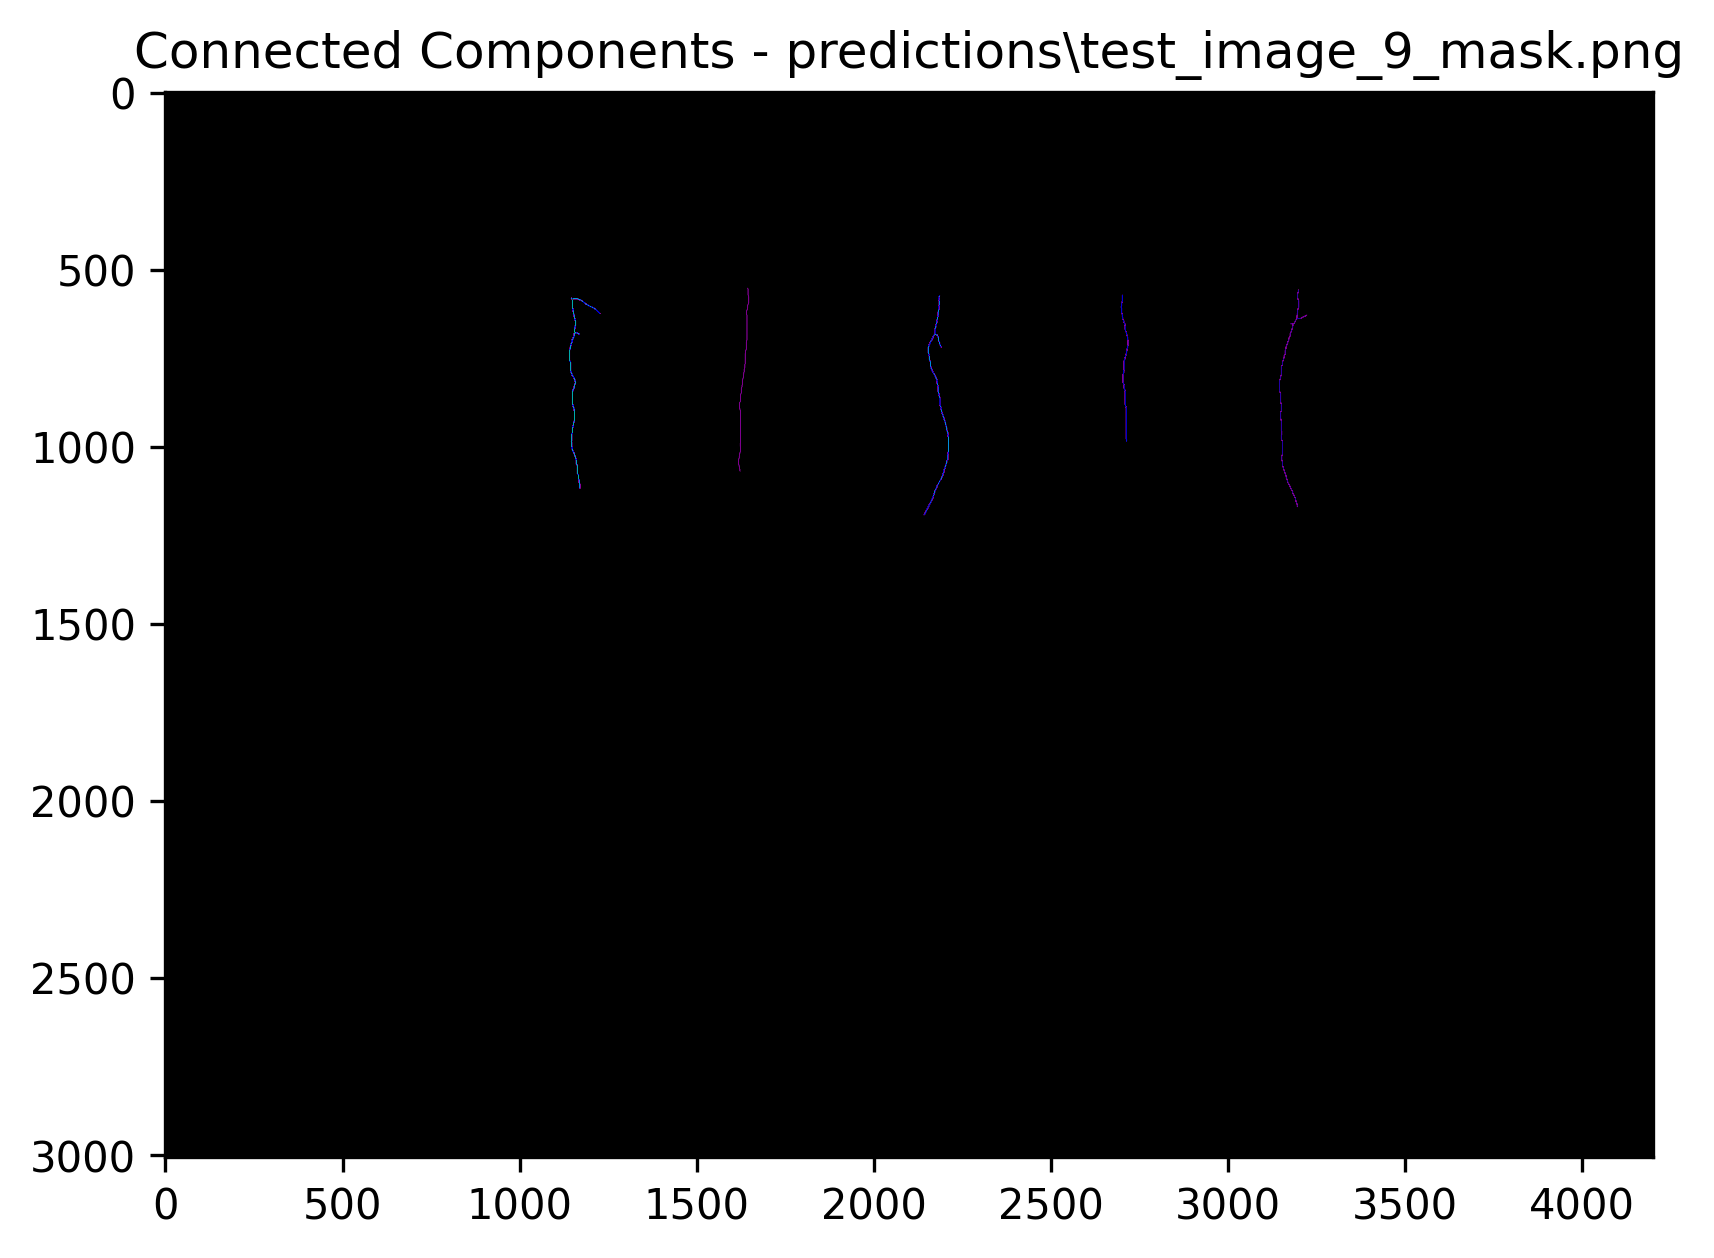

Component 1: Area=518, BBox=(1619,553,30,518)
Component 2: Area=648, BBox=(3147,558,78,613)
Component 3: Area=414, BBox=(2700,573,20,414)
Component 4: Area=662, BBox=(2143,574,70,620)
Component 5: Area=631, BBox=(1142,581,87,538)
Seed testing123 [{'root_segment': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'root_length': 518, 'x': 1634, 'y': 812}, {'root_segment': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., F

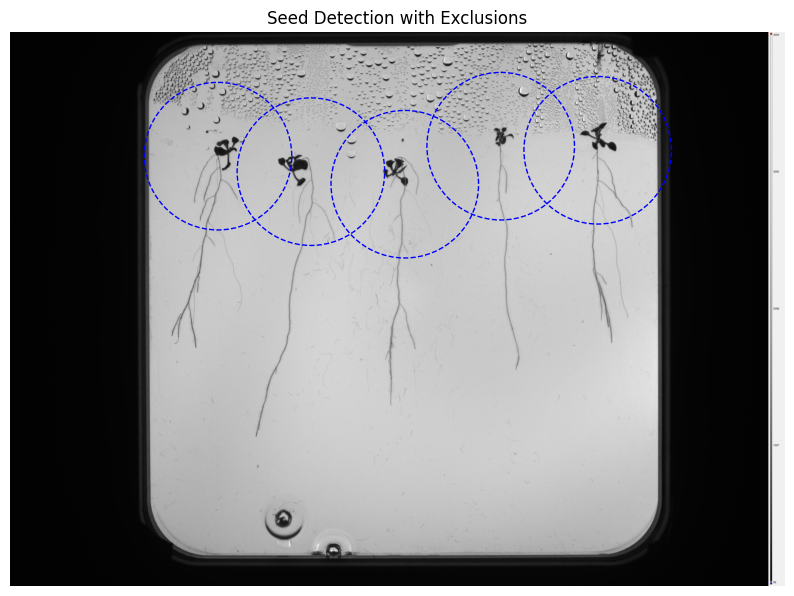

Detected seeds: []
Seeds near roots are excluded. Remaining seed count: 0


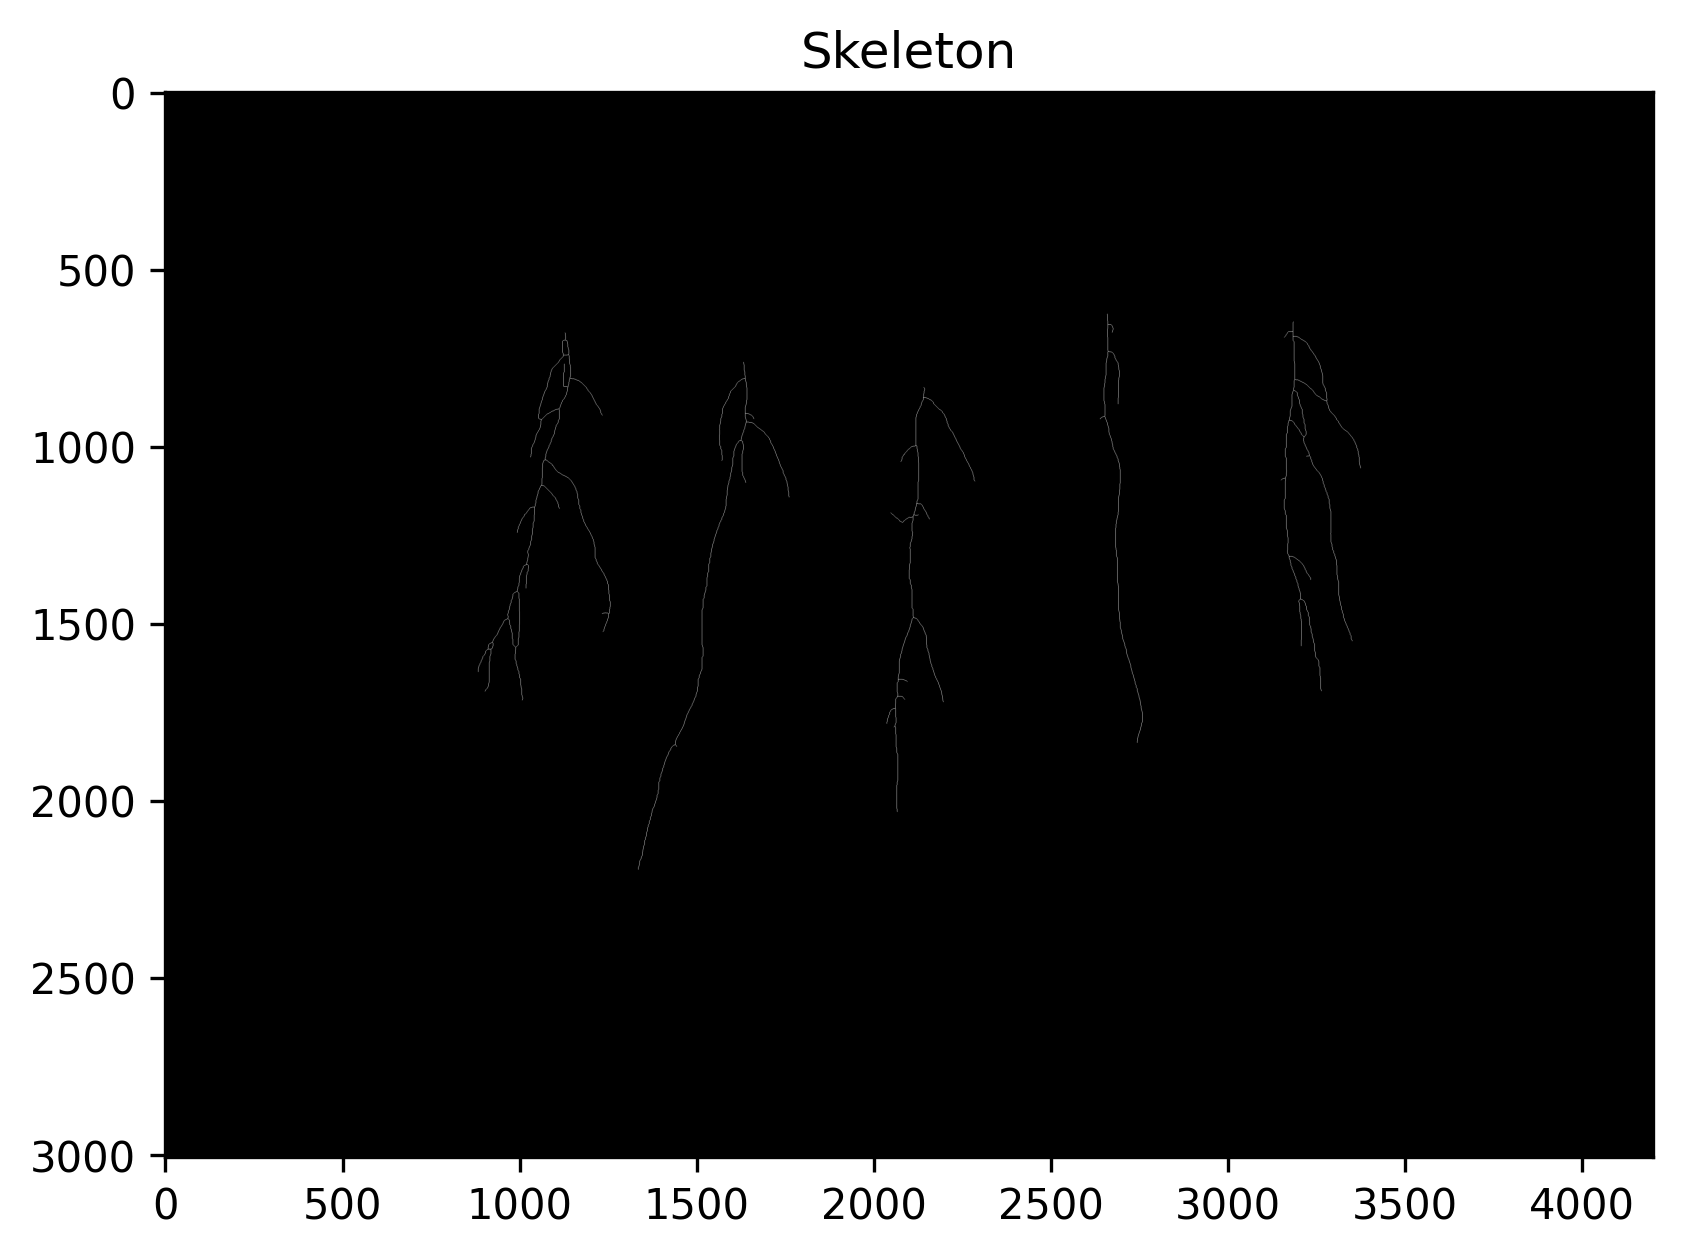

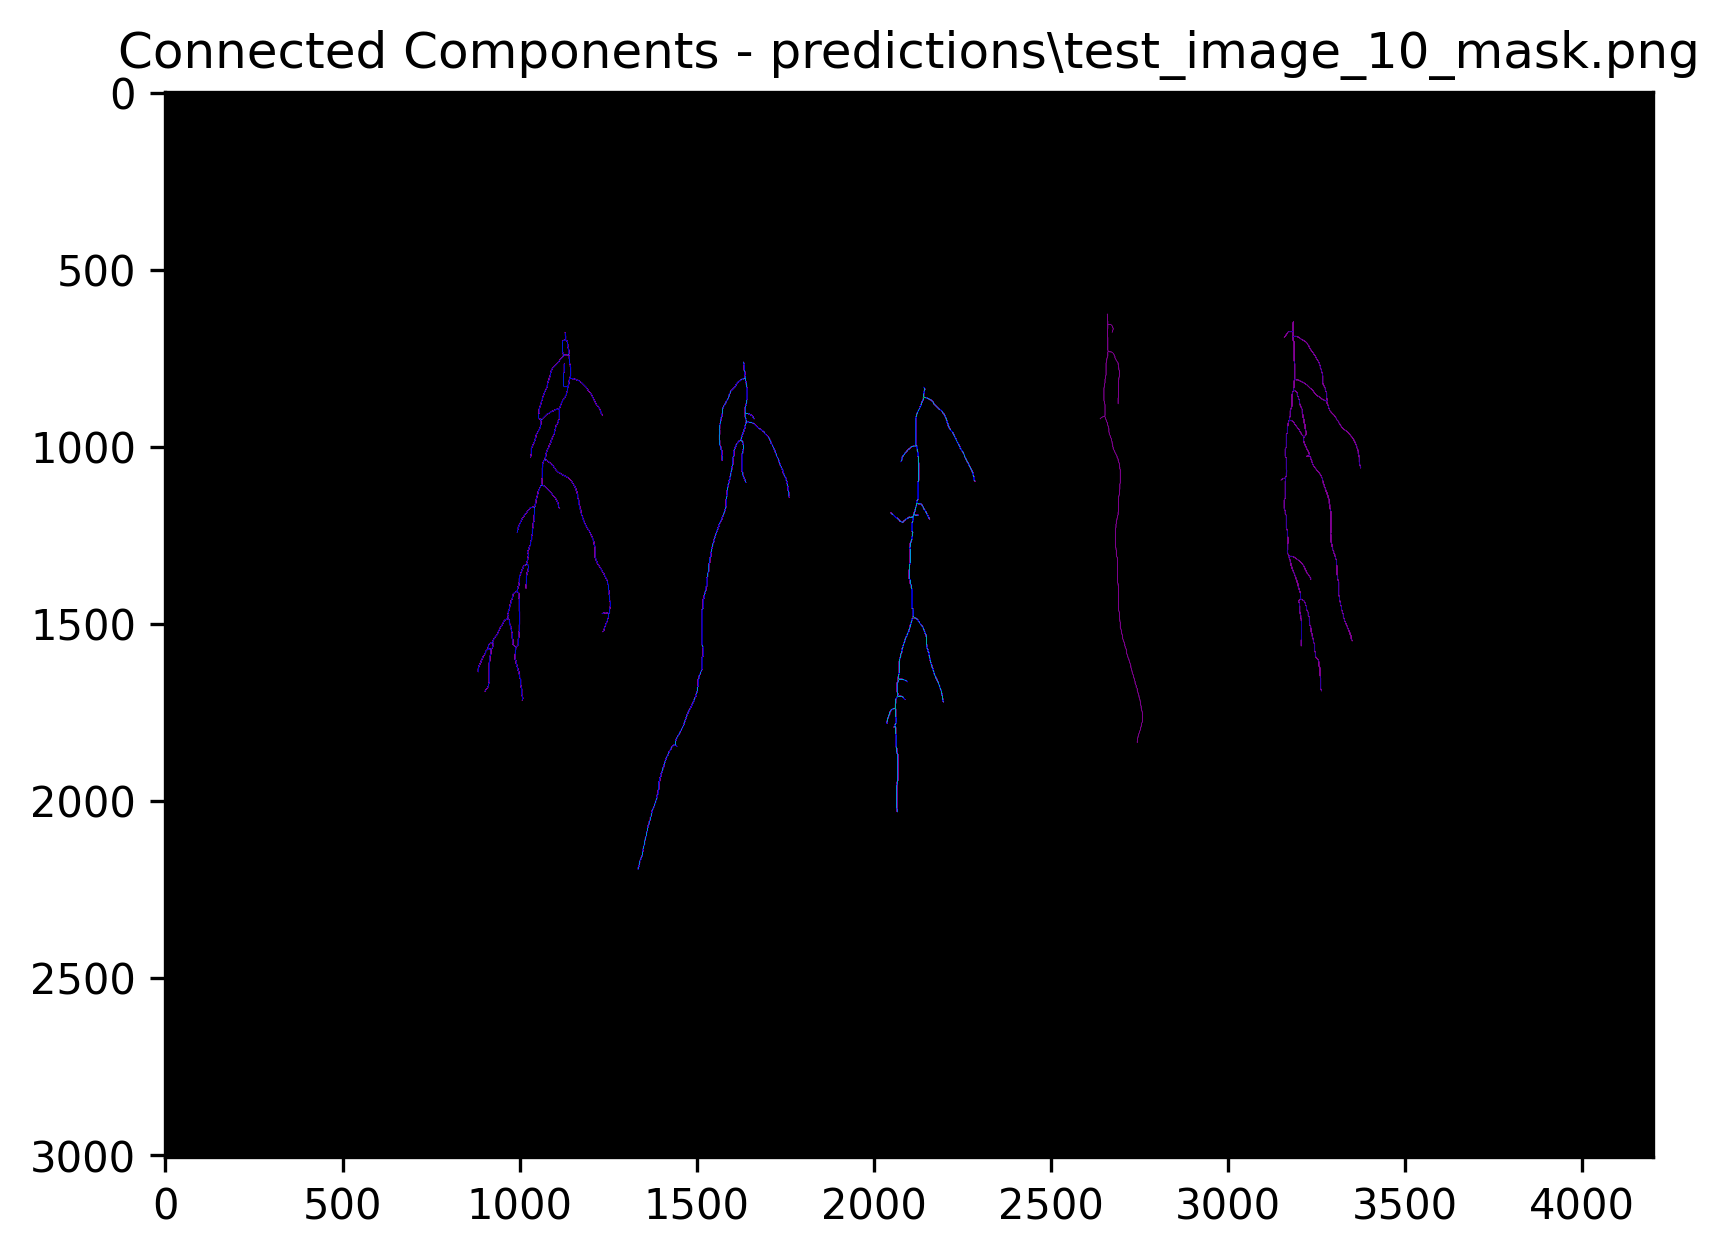

Component 1: Area=1413, BBox=(2640,626,121,1211)
Component 2: Area=2564, BBox=(3151,648,226,1043)
Component 3: Area=2863, BBox=(884,679,374,1038)
Component 4: Area=2071, BBox=(1336,762,427,1433)
Component 5: Area=1989, BBox=(2038,833,250,1199)
Seed testing123 [{'root_segment': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'root_length': 1413, 'x': 2700, 'y': 1231}, {'root_segment': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, Fals

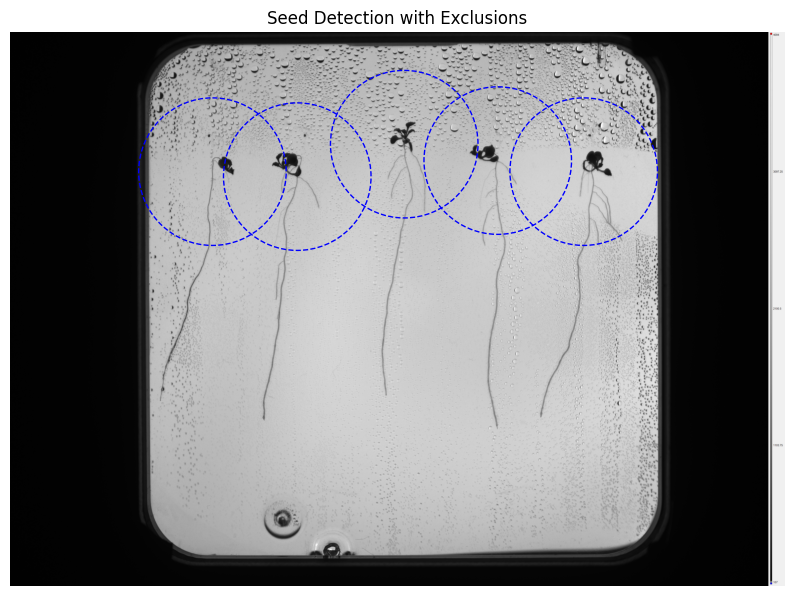

Detected seeds: []
Seeds near roots are excluded. Remaining seed count: 0


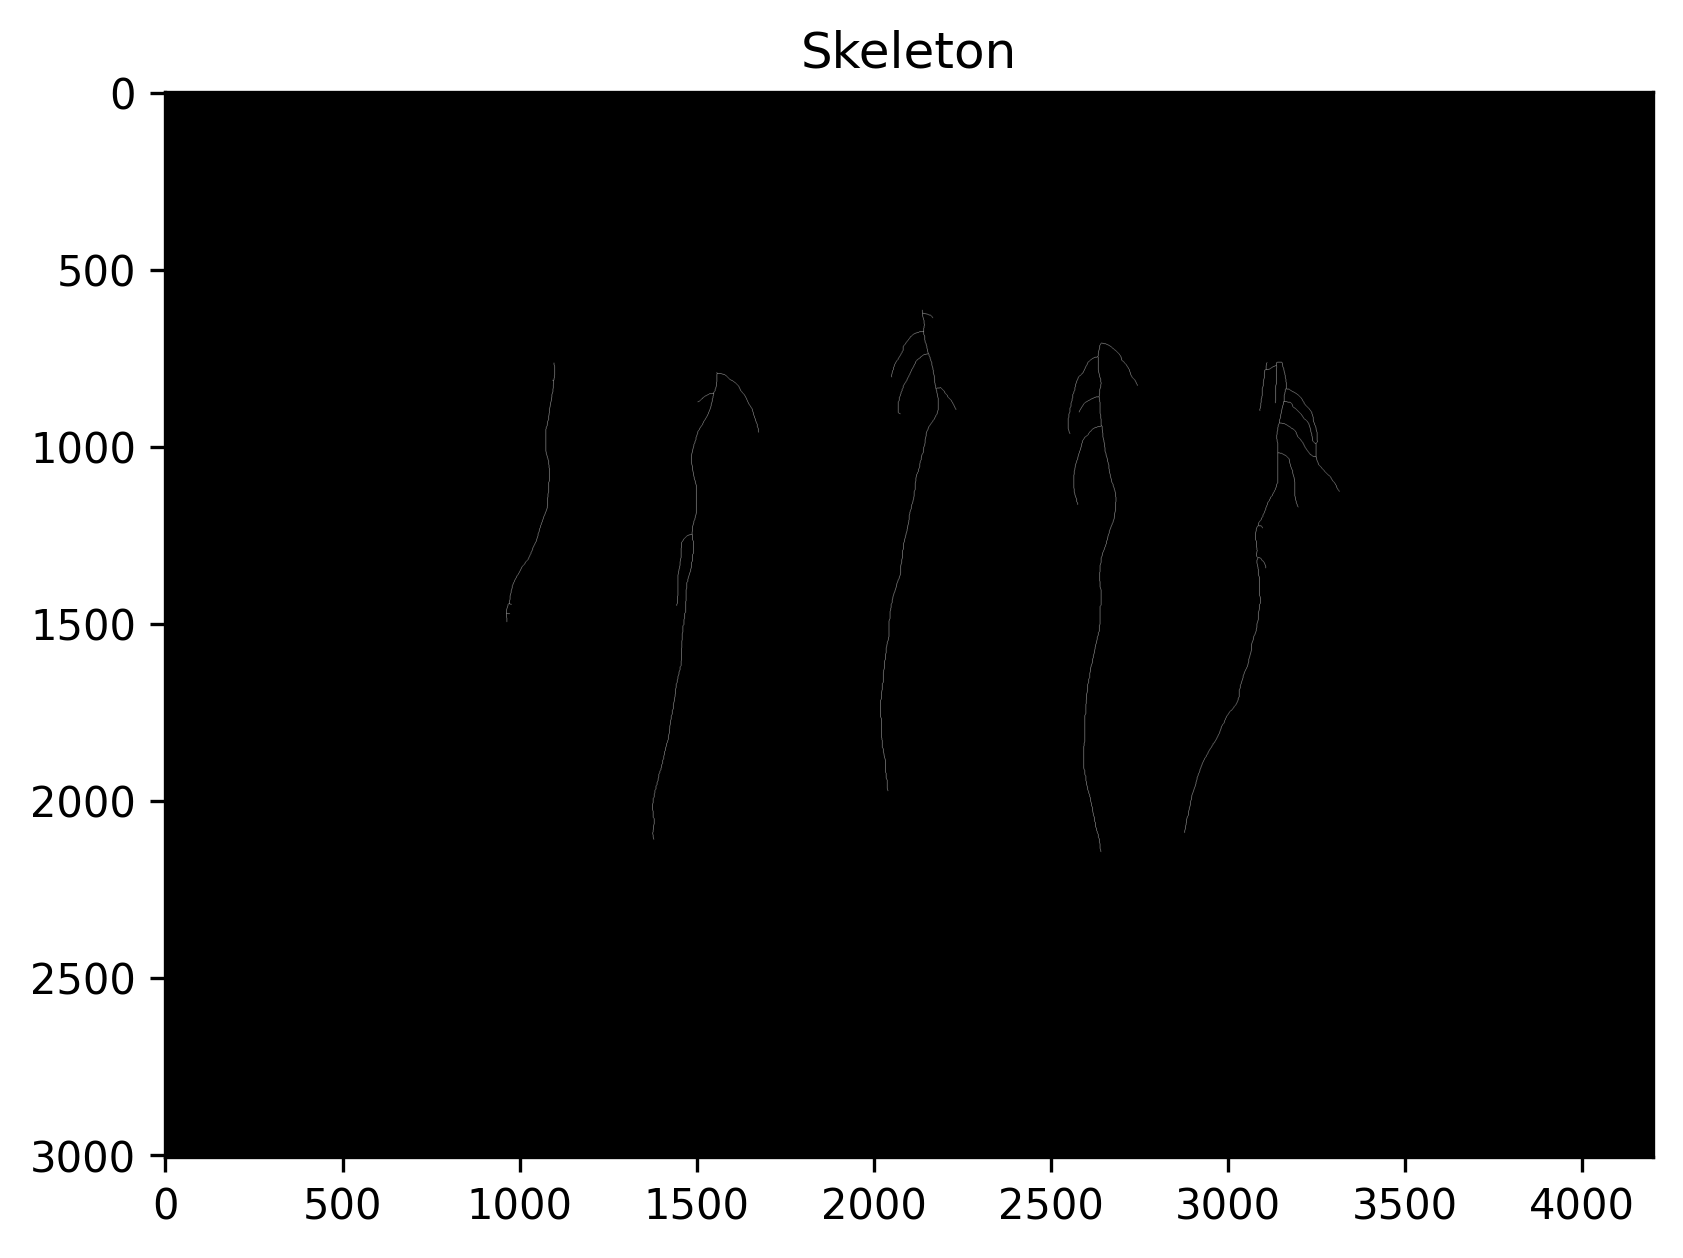

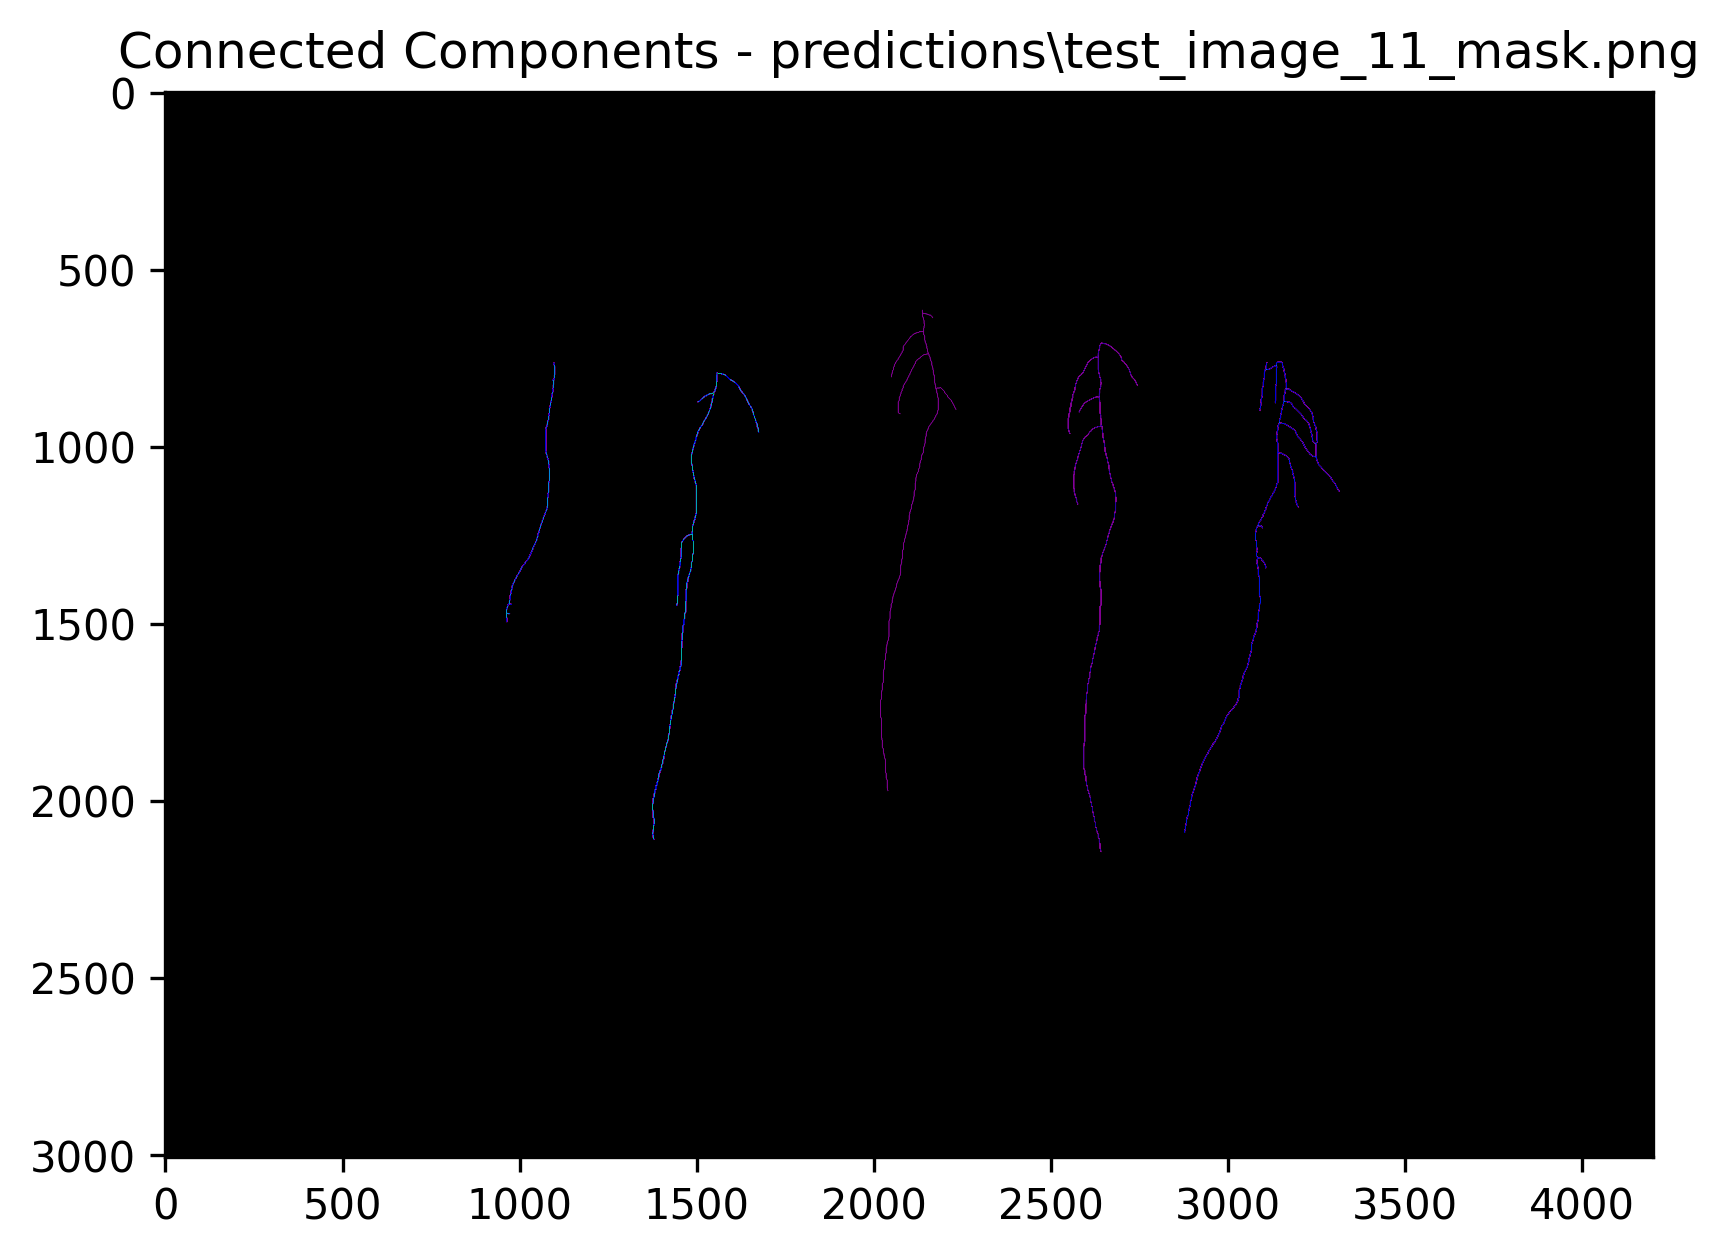

Component 1: Area=1801, BBox=(2020,615,214,1358)
Component 2: Area=2117, BBox=(2550,708,197,1437)
Component 3: Area=2417, BBox=(2879,762,438,1329)
Component 4: Area=752, BBox=(964,764,137,732)
Component 5: Area=1767, BBox=(1376,791,301,1319)
Seed testing123 [{'root_segment': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'root_length': 1801, 'x': 2127, 'y': 1294}, {'root_segment': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False,

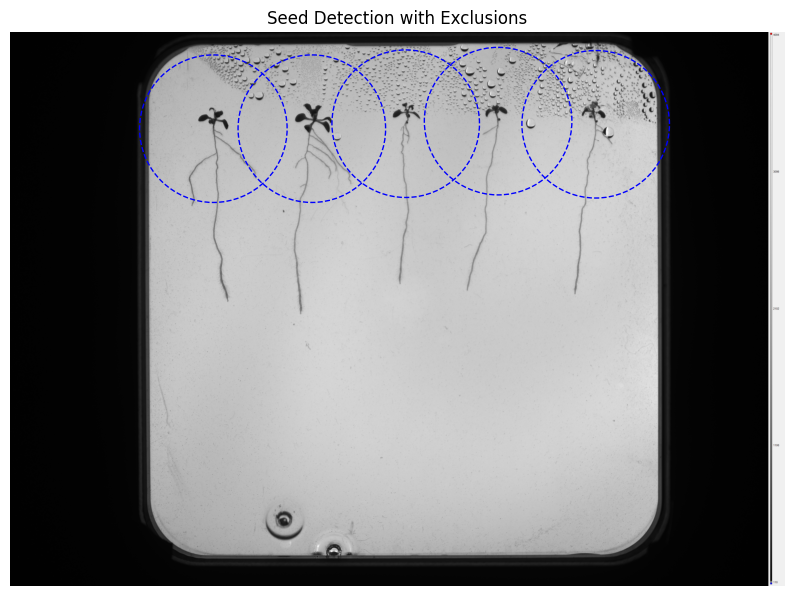

Detected seeds: []
Seeds near roots are excluded. Remaining seed count: 0


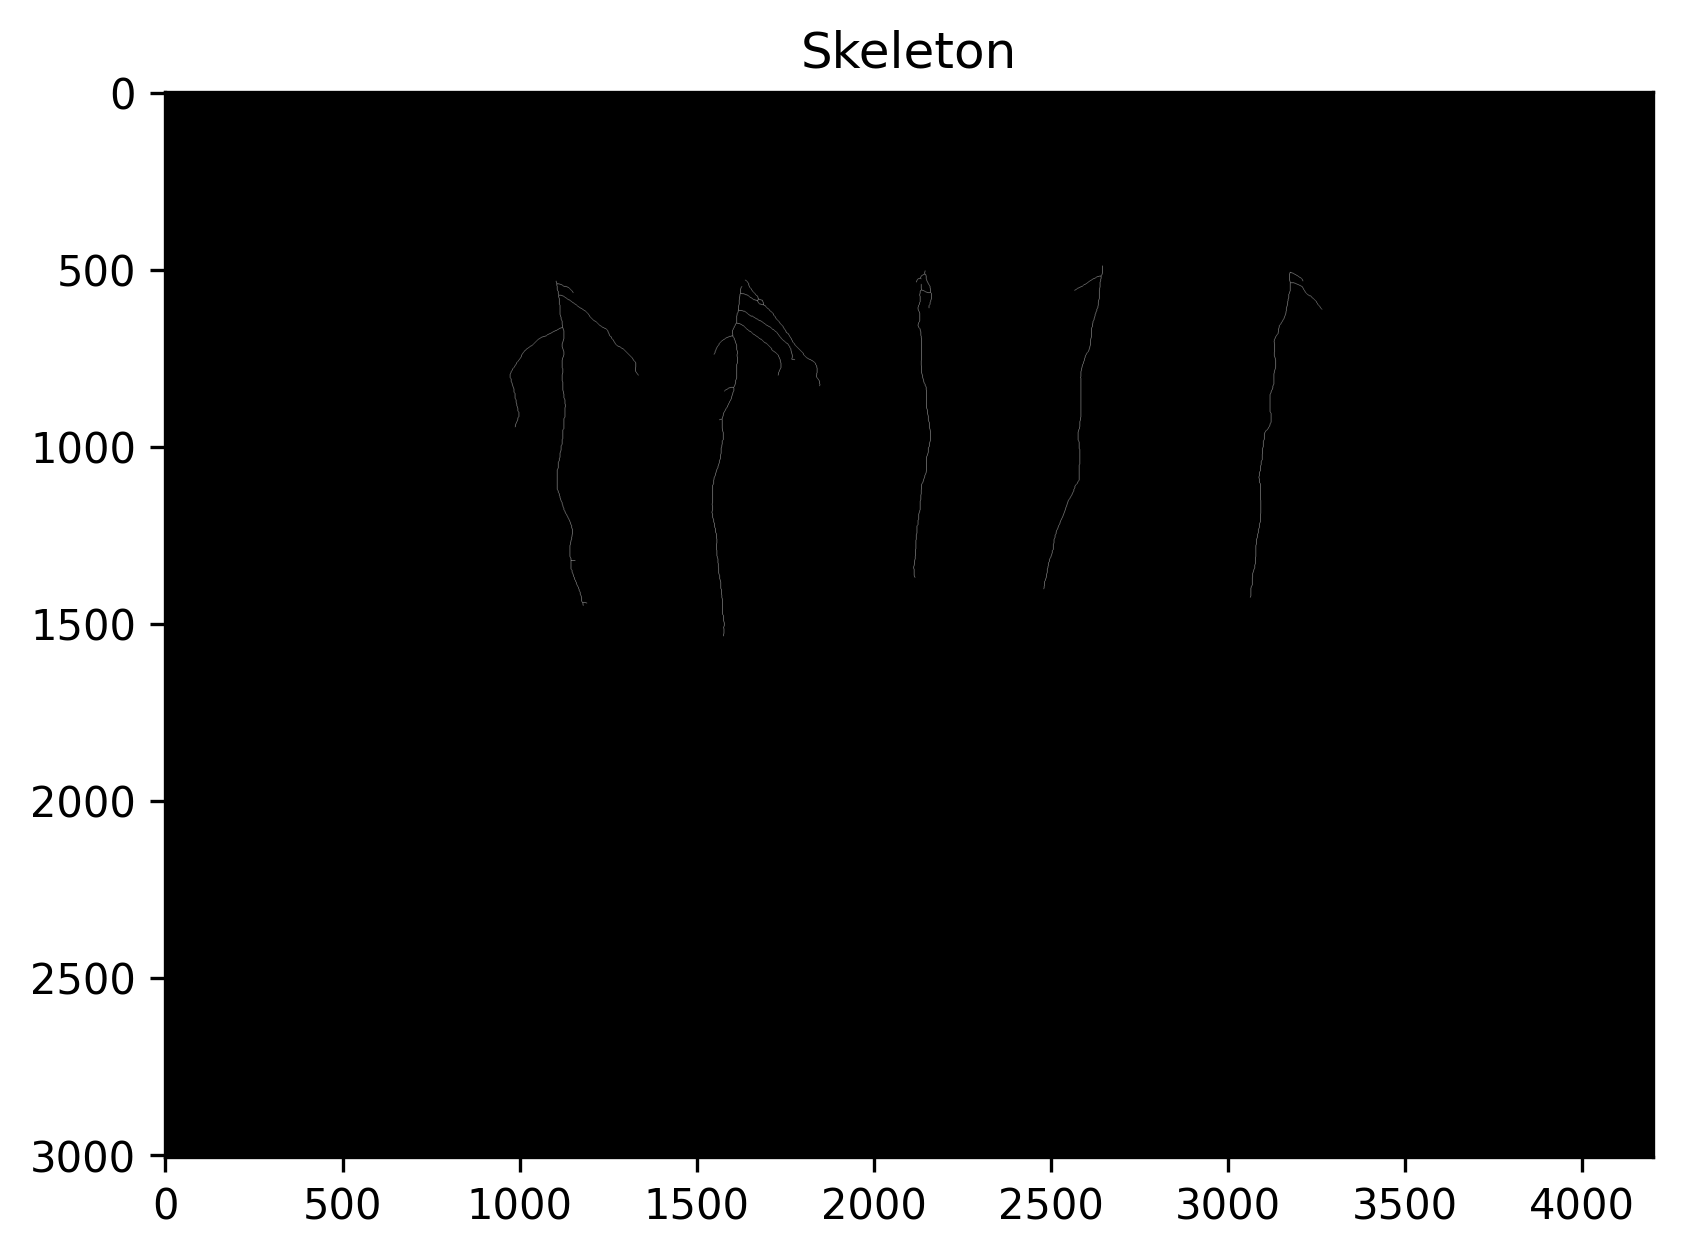

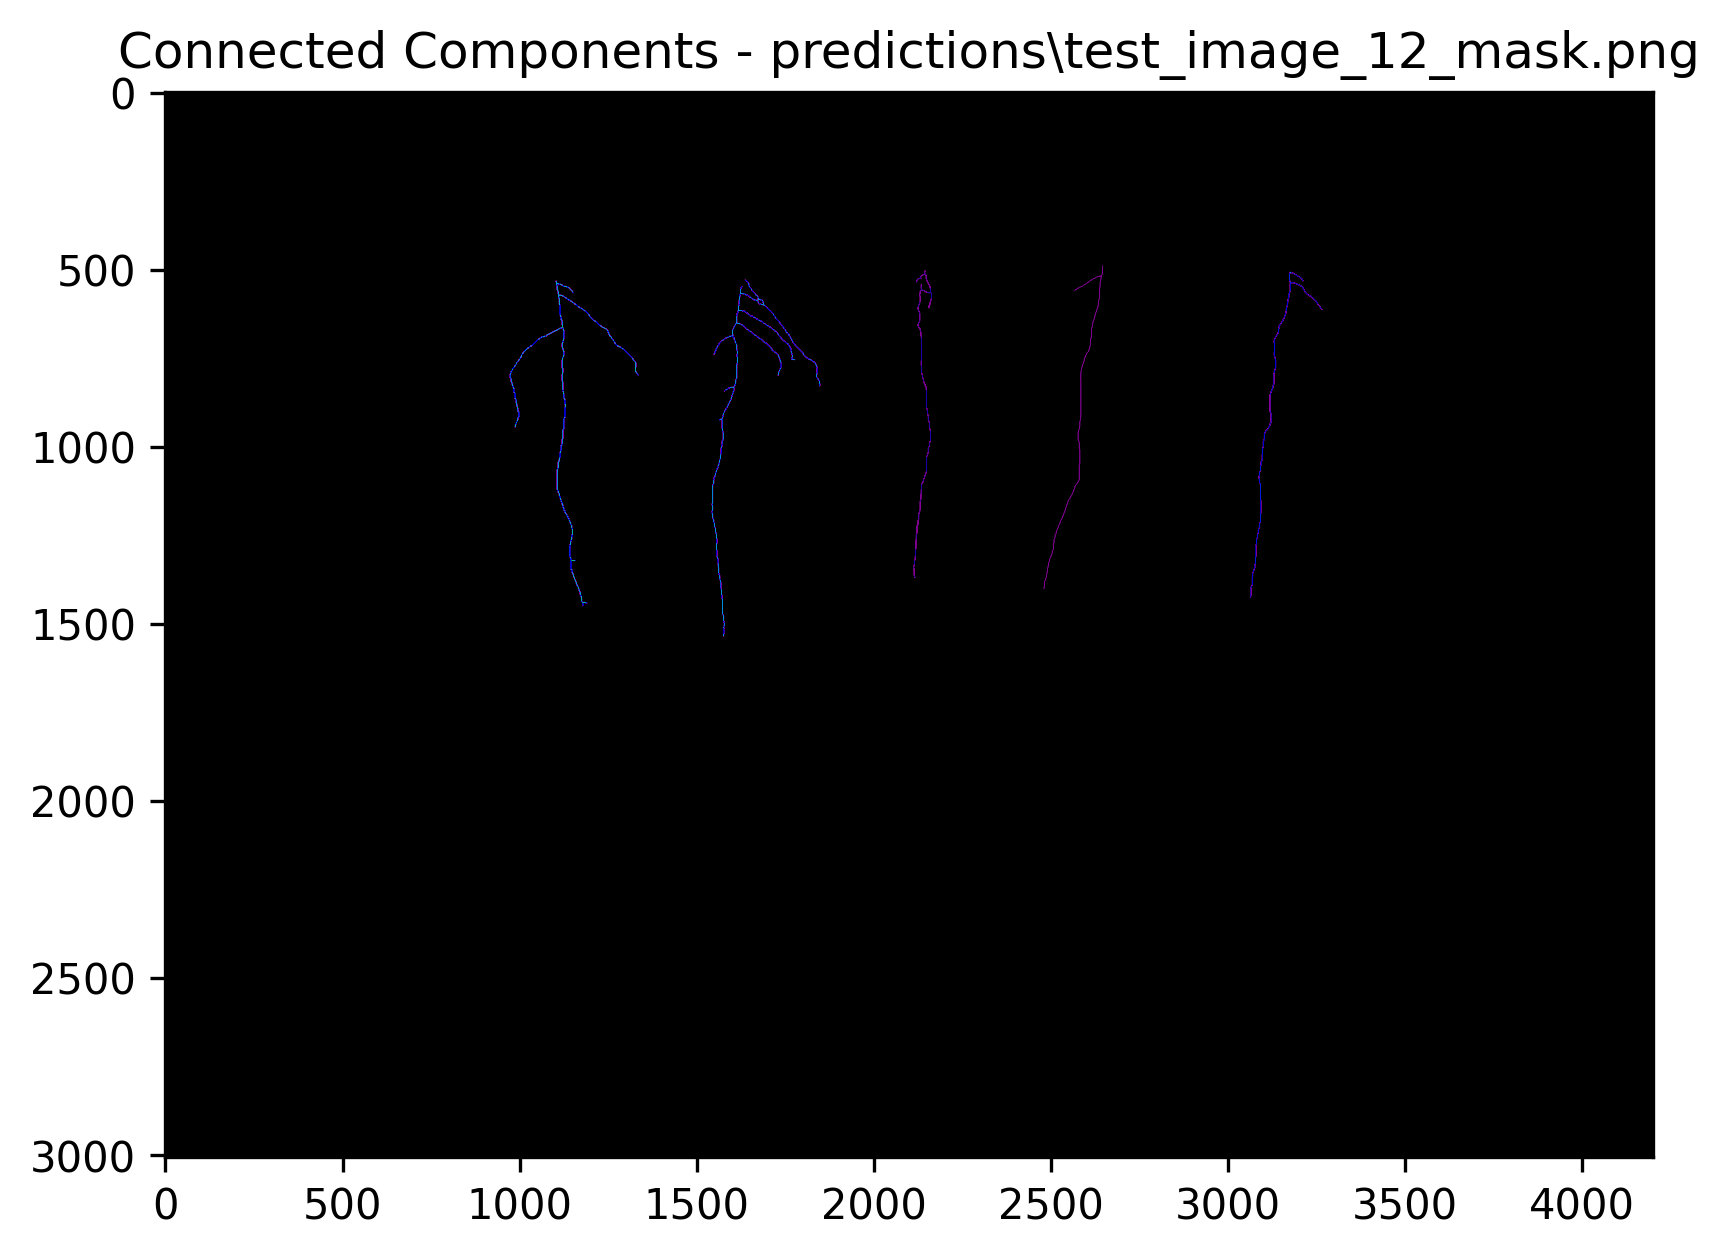

Component 1: Area=988, BBox=(2481,490,167,913)
Component 2: Area=995, BBox=(2113,504,52,866)
Component 3: Area=1062, BBox=(3064,508,204,919)
Component 4: Area=1859, BBox=(1544,530,306,1006)
Component 5: Area=1588, BBox=(974,533,363,917)
Seed testing123 [{'root_segment': array([[False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       ...,
       [False,  True, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False]]), 'root_length': 988, 'x': 2564, 'y': 946}, {'root_segment': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False,

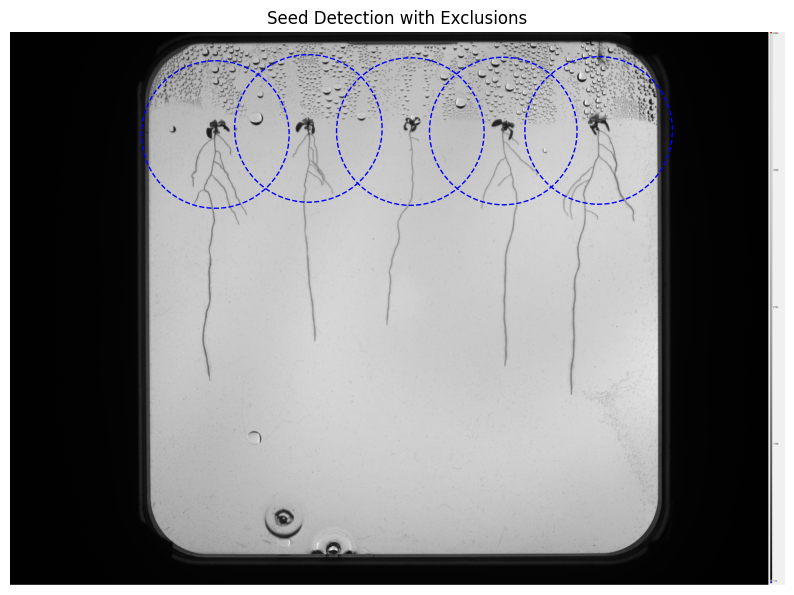

Detected seeds: []
Seeds near roots are excluded. Remaining seed count: 0


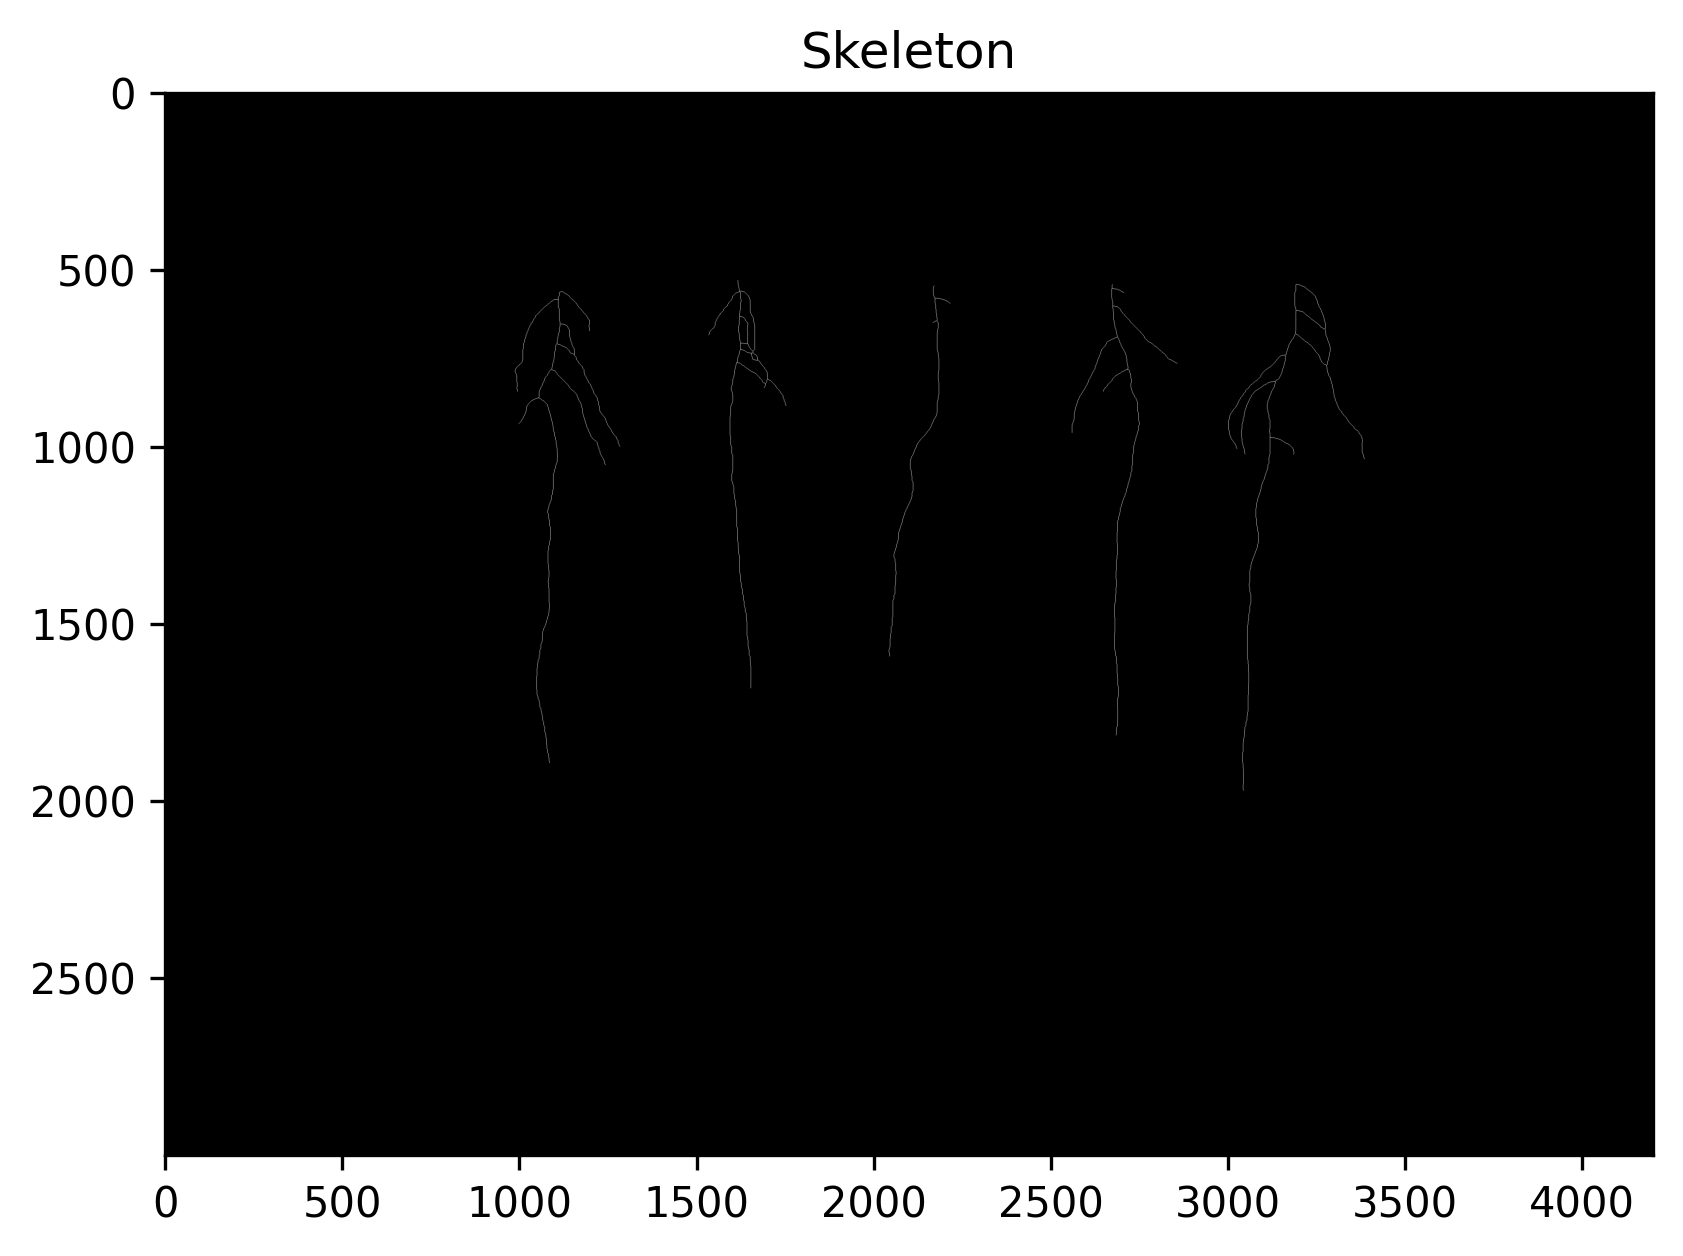

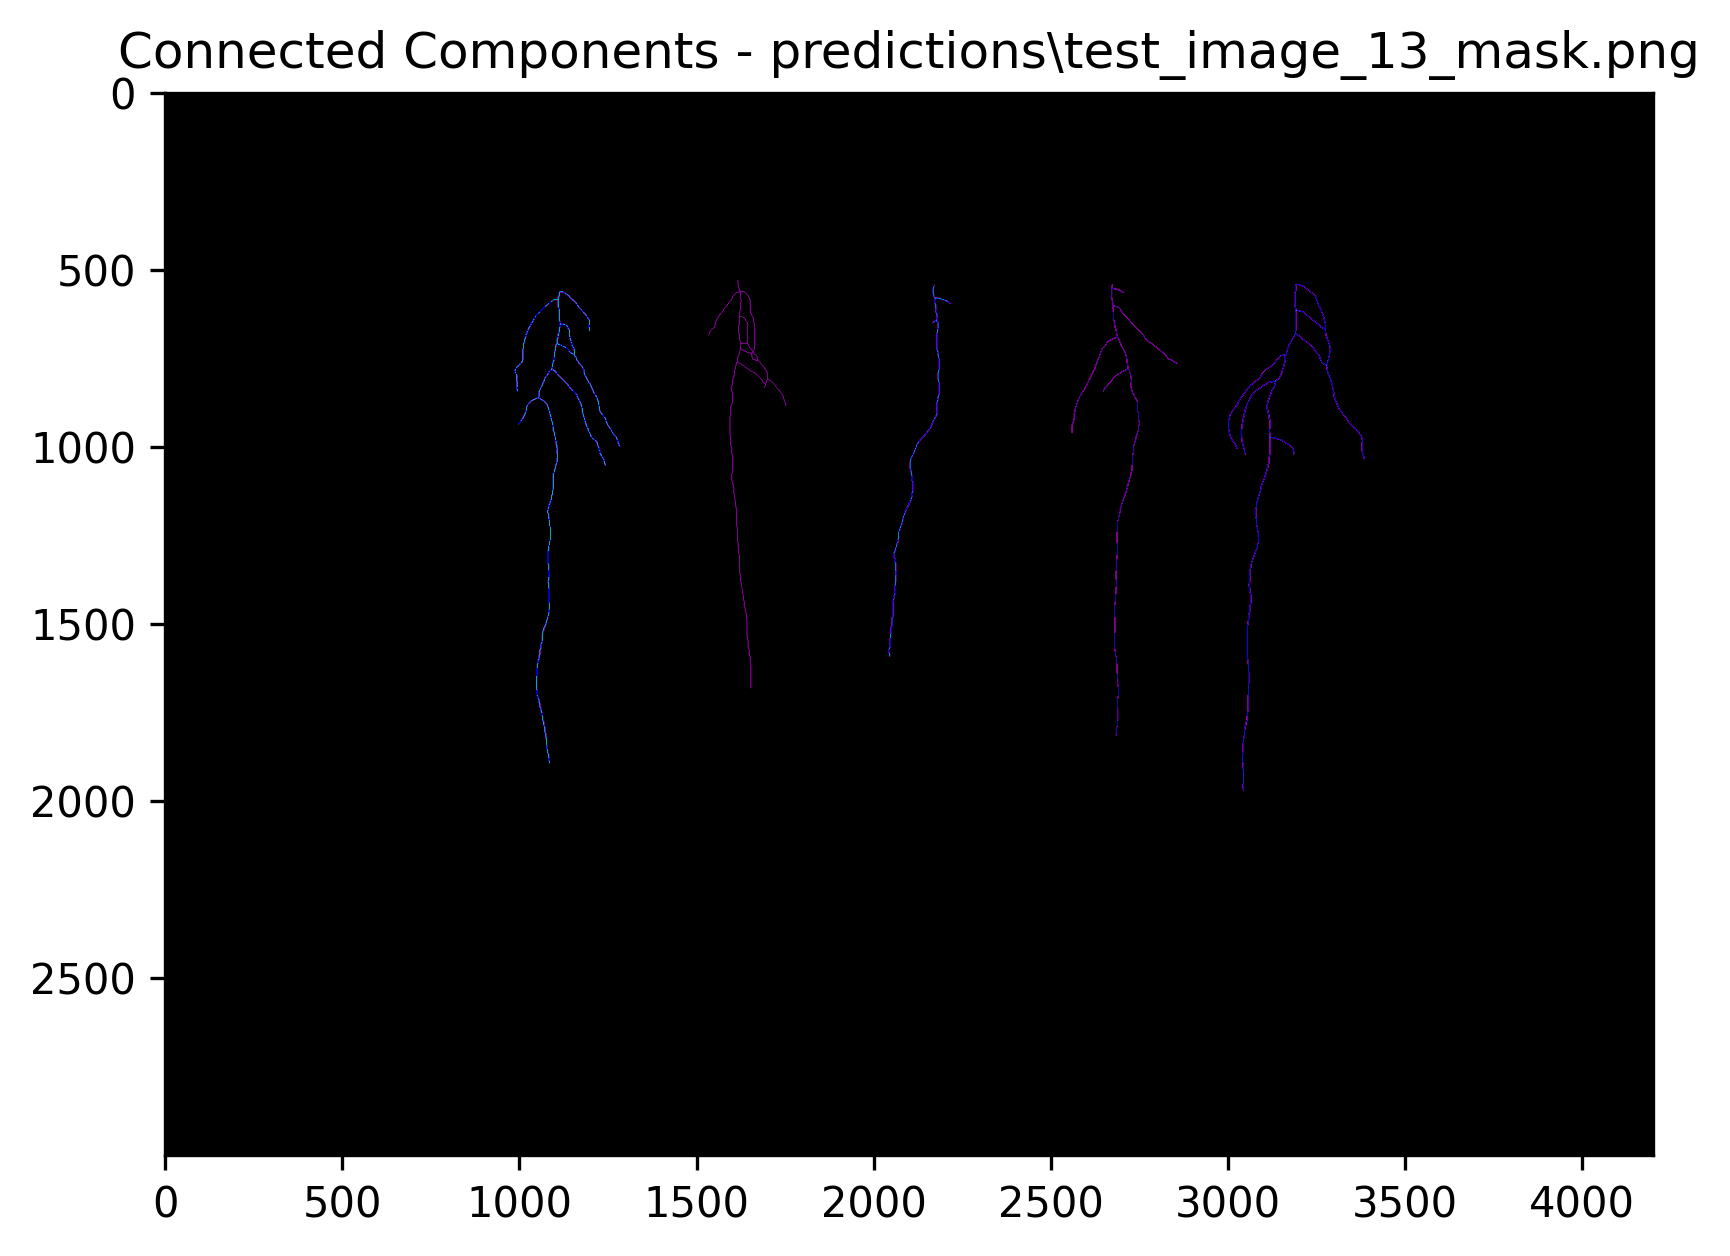

Component 1: Area=1927, BBox=(1534,528,221,1153)
Component 2: Area=1870, BBox=(2561,540,298,1274)
Component 3: Area=2740, BBox=(3003,540,385,1430)
Component 4: Area=1101, BBox=(2044,544,174,1047)
Component 5: Area=2519, BBox=(988,561,298,1331)
Seed testing123 [{'root_segment': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'root_length': 1927, 'x': 1644, 'y': 1104}, {'root_segment': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, Fals

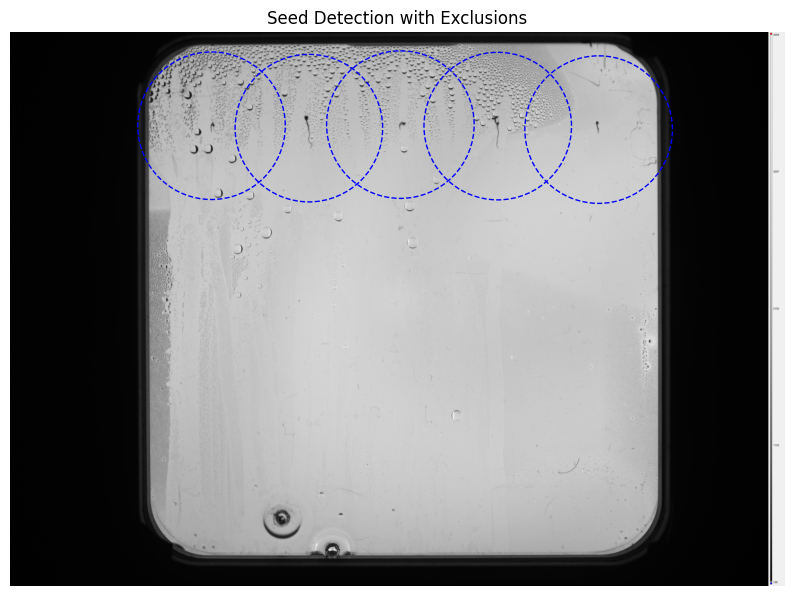

Detected seeds: []
Seeds near roots are excluded. Remaining seed count: 0


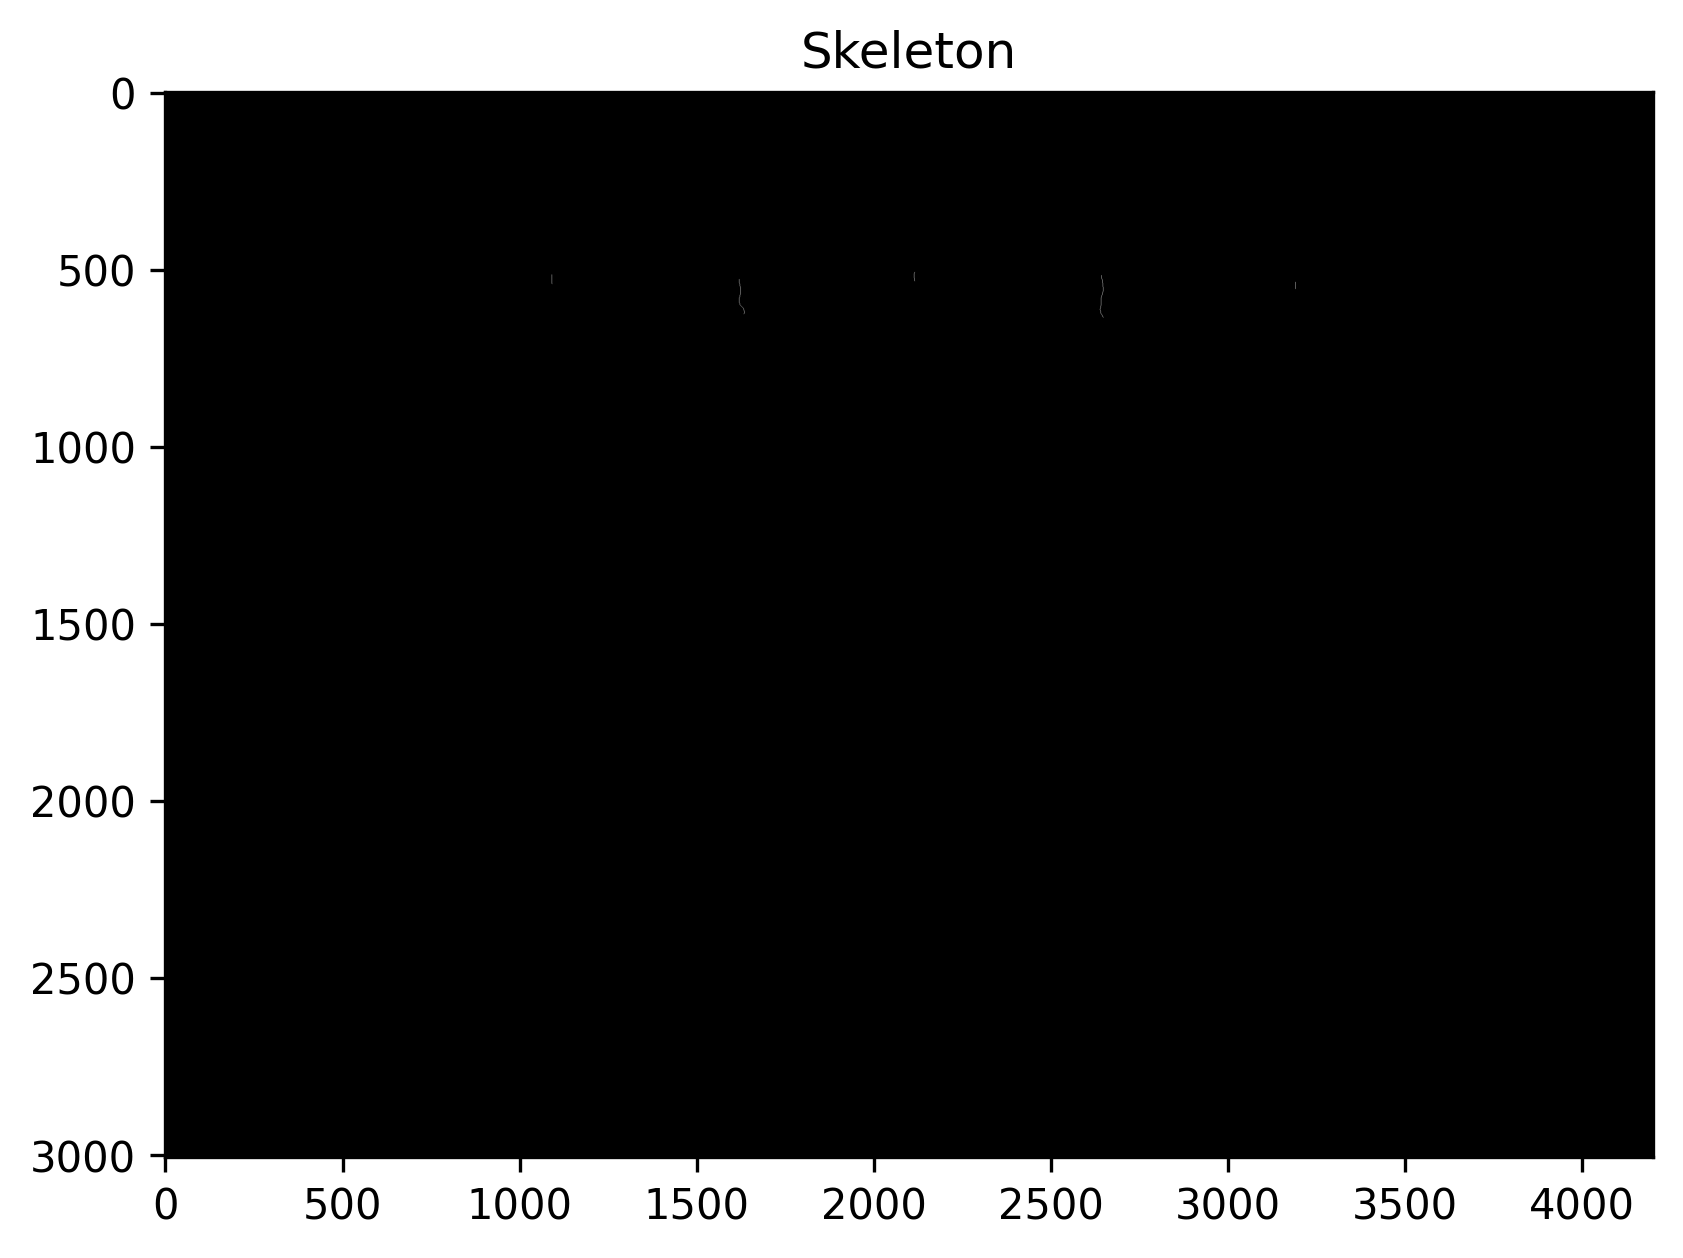

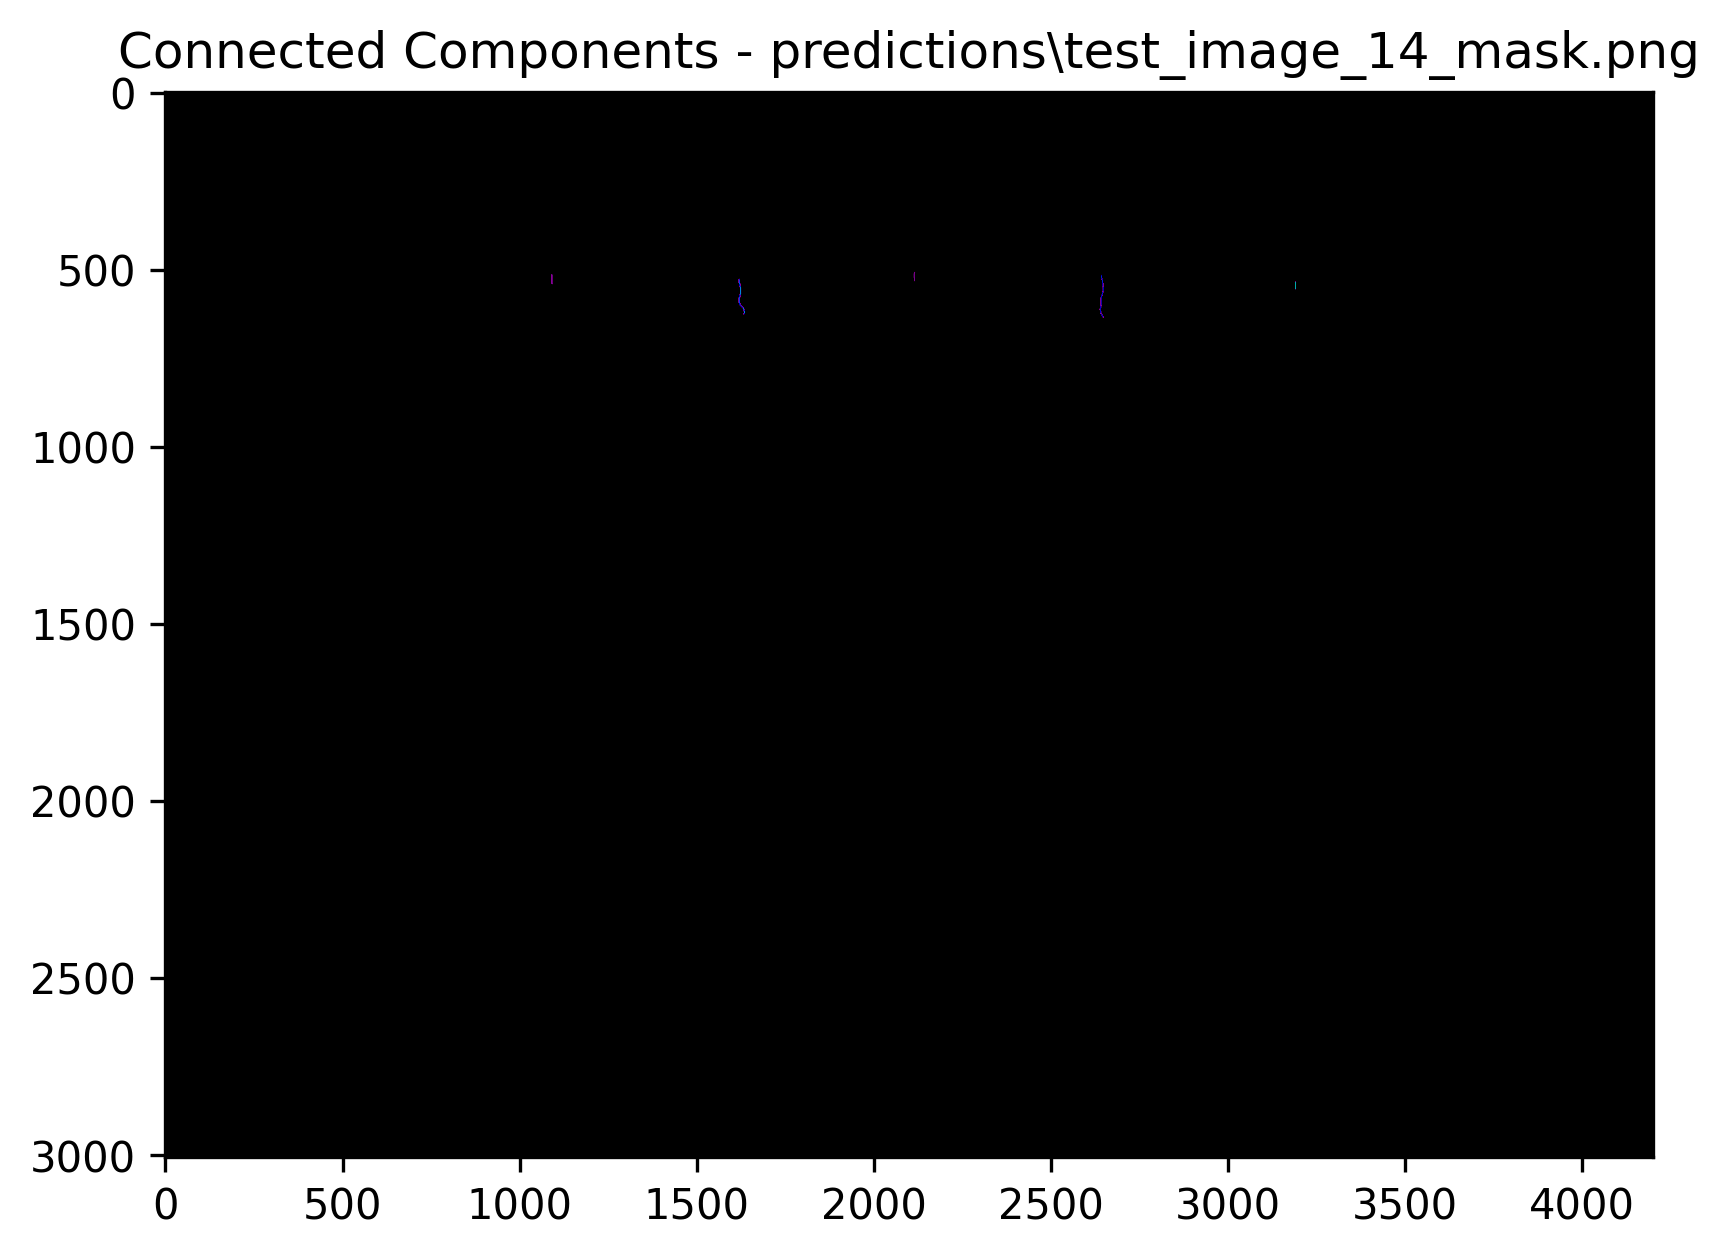

Component 1: Area=26, BBox=(2115,508,3,26)
Component 2: Area=27, BBox=(1092,515,2,27)
Component 3: Area=120, BBox=(2640,517,11,119)
Component 4: Area=99, BBox=(1621,528,16,99)
Component 5: Area=20, BBox=(3192,536,1,20)
Seed testing123 [{'root_segment': array([[False, False,  True],
       [False,  True, False],
       [False,  True, False],
       [False,  True, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [False,  True, False],
       [False,  True, False],
       [False,  True, False],
       [False,  True, False],
       [False,  True, False],
       [False,  True, False],
       [False,  True, False],
       [False,  True, False

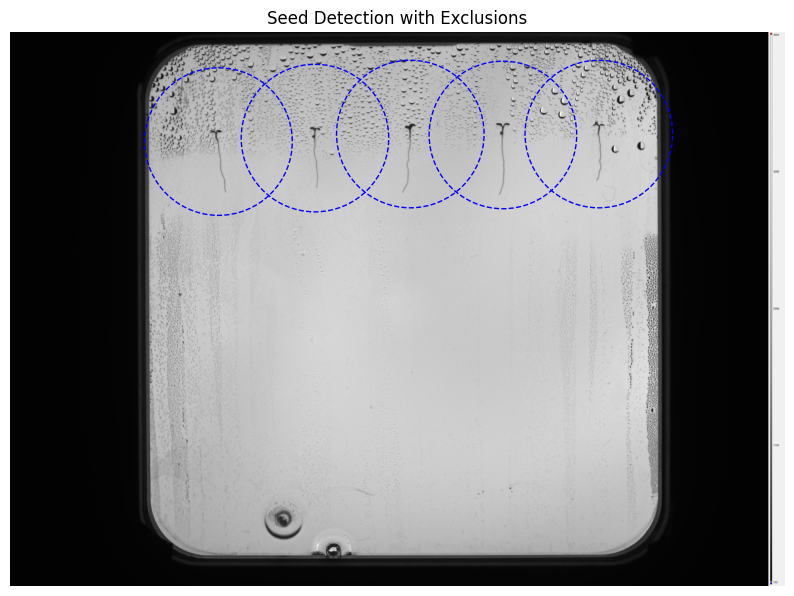

Detected seeds: []
Seeds near roots are excluded. Remaining seed count: 0


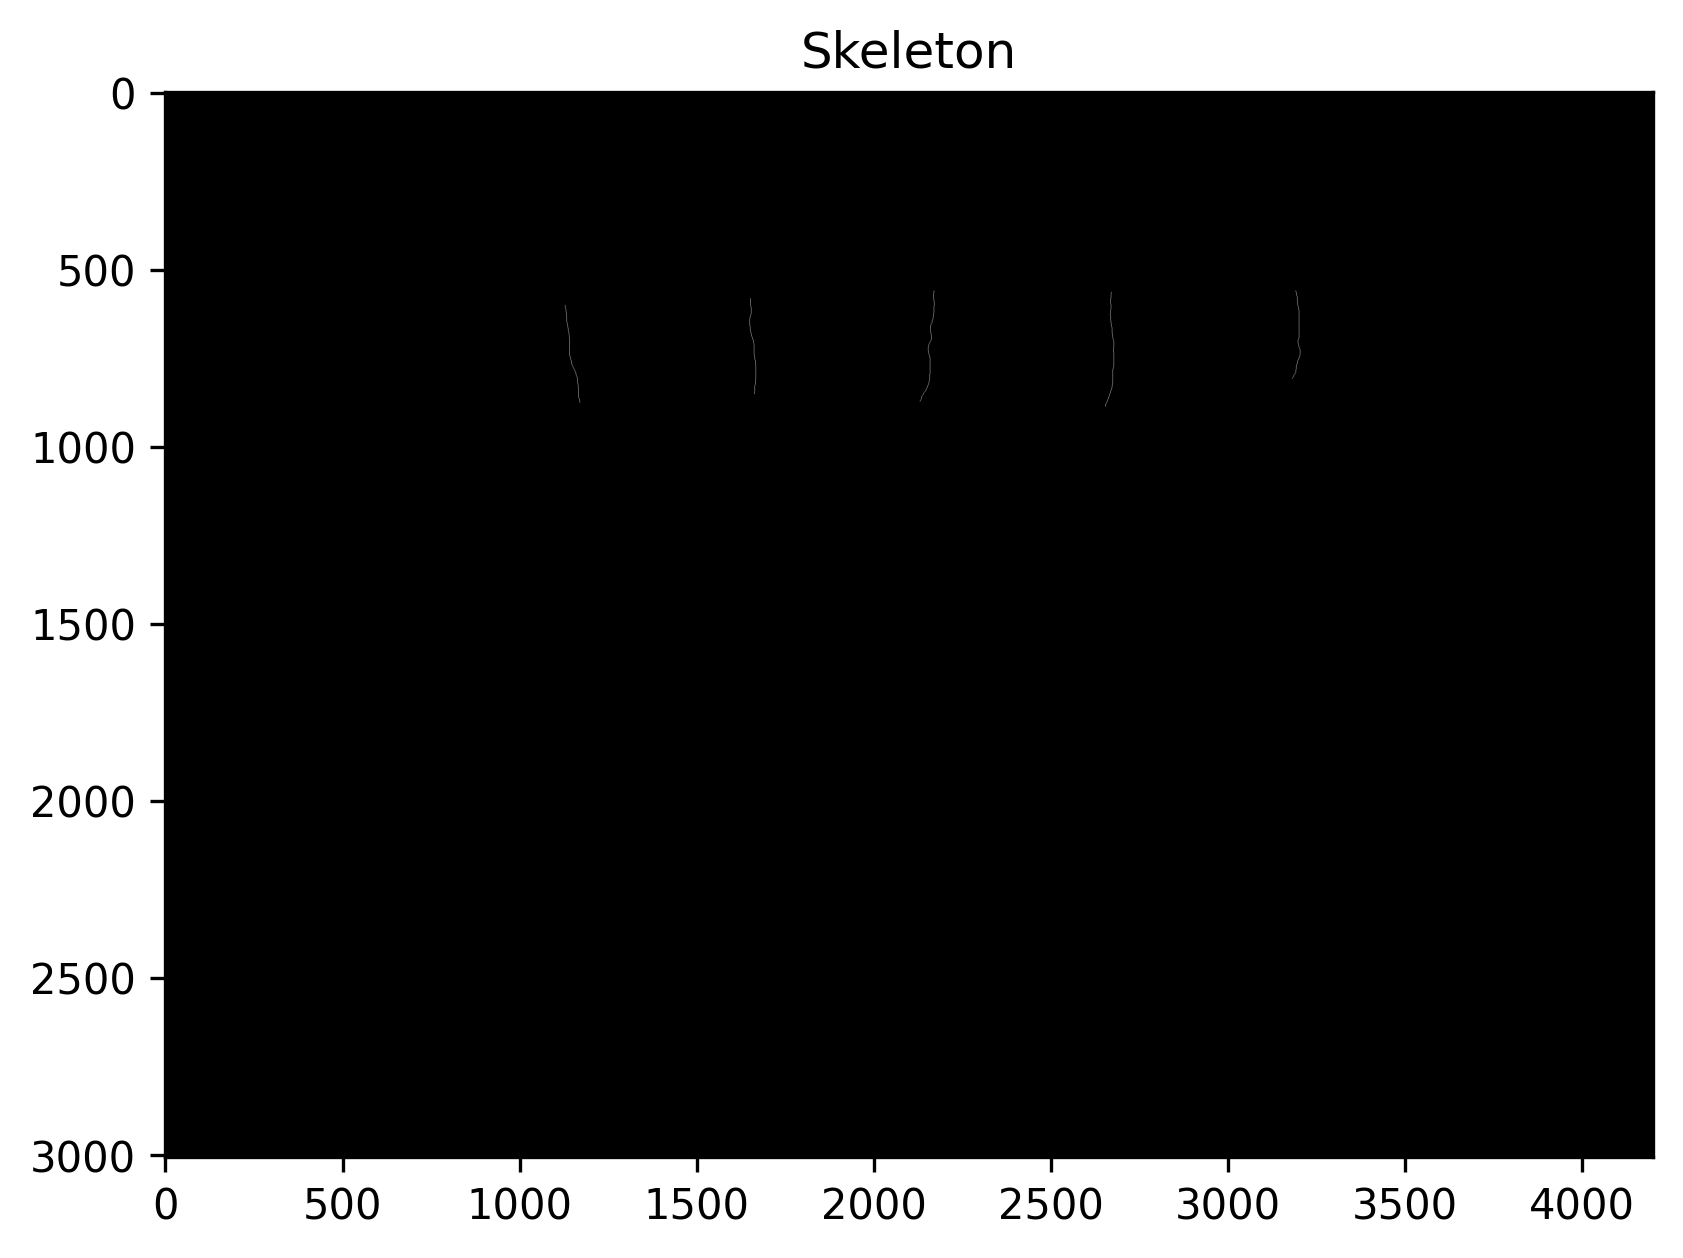

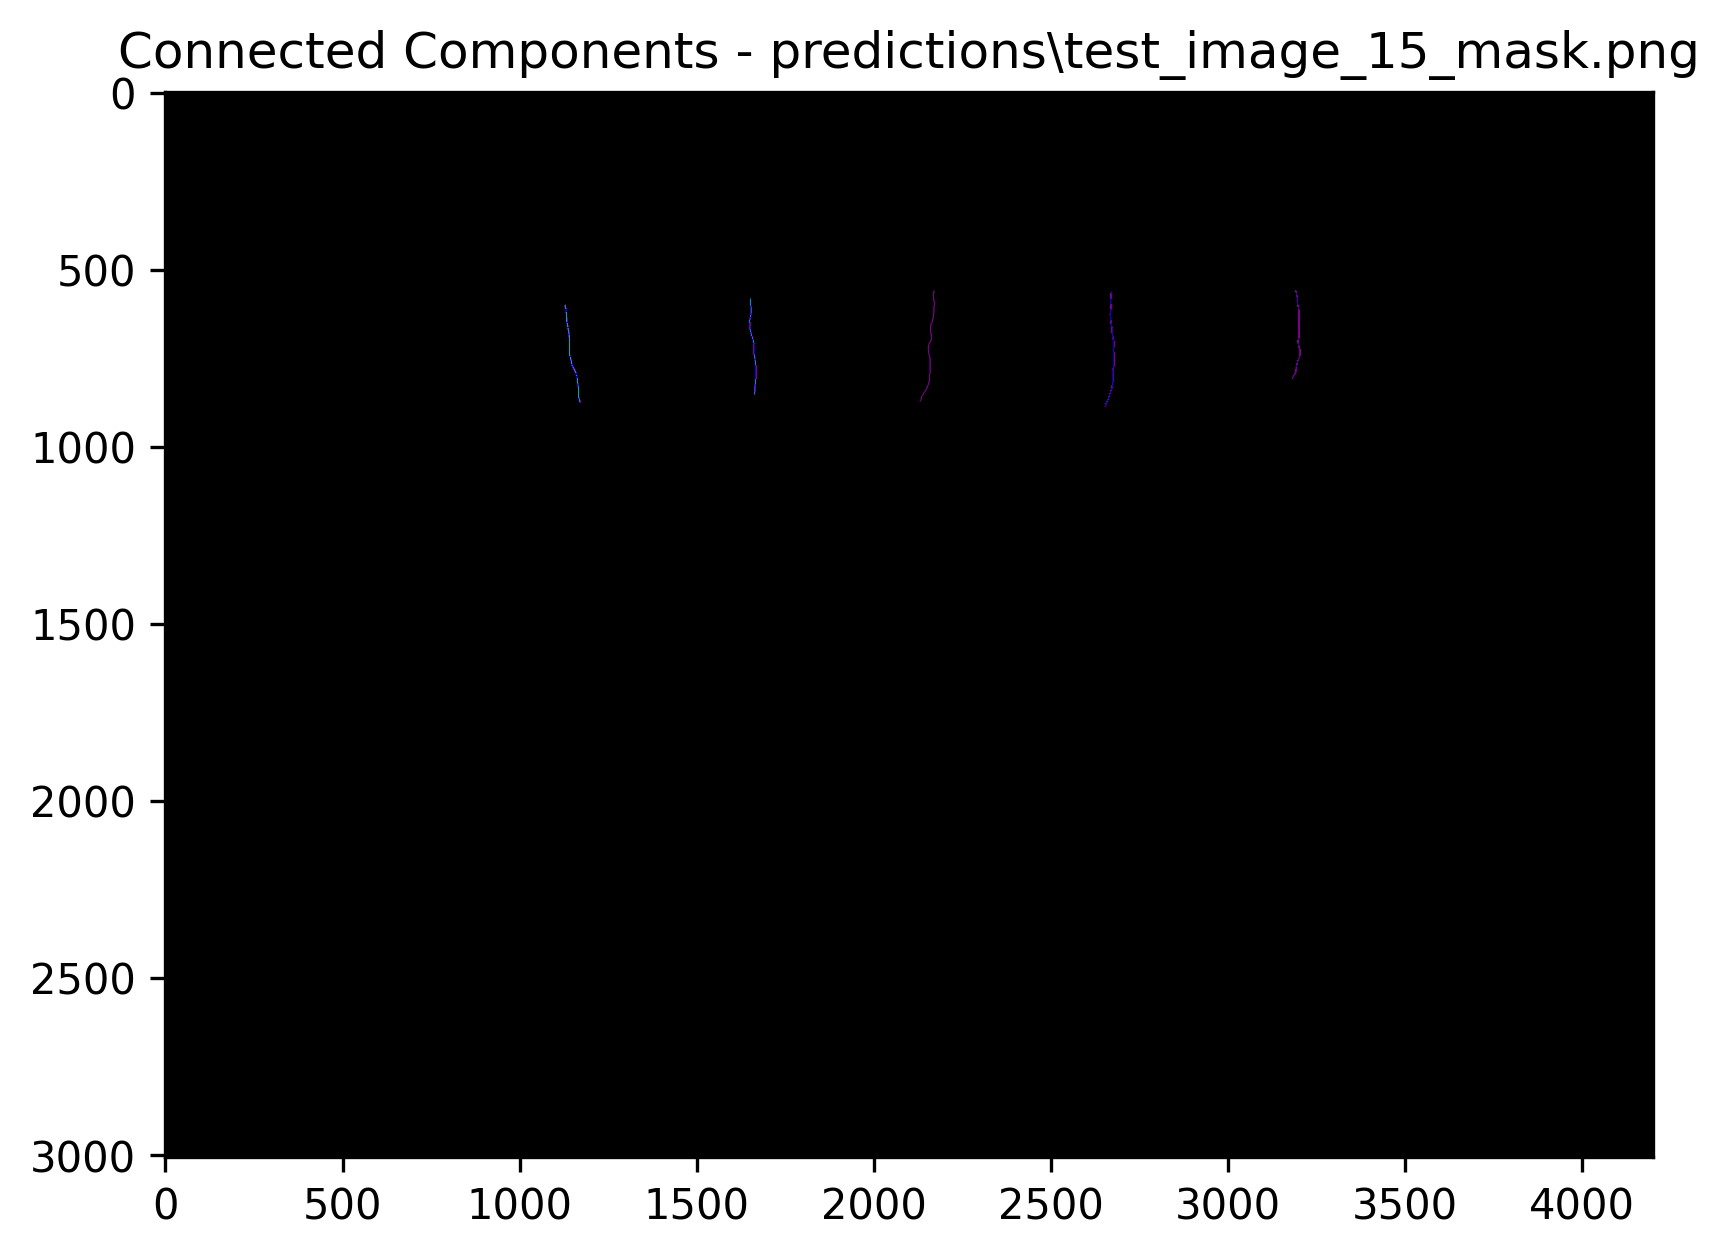

Component 1: Area=314, BBox=(2131,560,42,314)
Component 2: Area=249, BBox=(3183,560,23,249)
Component 3: Area=324, BBox=(2656,564,24,324)
Component 4: Area=271, BBox=(1649,582,20,271)
Component 5: Area=276, BBox=(1129,601,43,276)
Seed testing123 [{'root_segment': array([[False, False, False, ..., False,  True, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False,  True, False],
       ...,
       [False,  True, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False]]), 'root_length': 314, 'x': 2152, 'y': 717}, {'root_segment': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False,  True, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [ True, False, False, ..., F

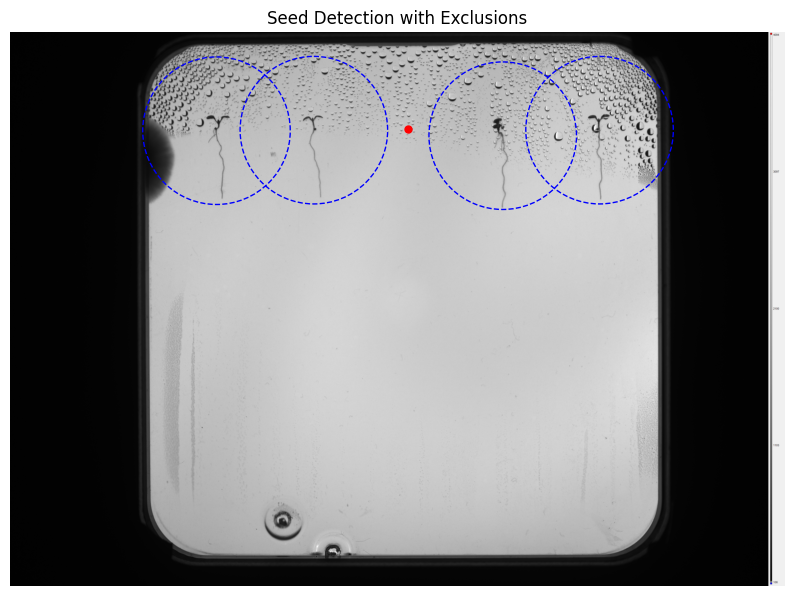

Detected seeds: [{'x': 2158, 'y': 527, 'x_cropped': 1442, 'y_cropped': 491, 'area': 68.0, 'mean_intensity': 55.23529411764706, 'circularity': 1.0354052171764774}]
Seeds near roots are excluded. Remaining seed count: 1


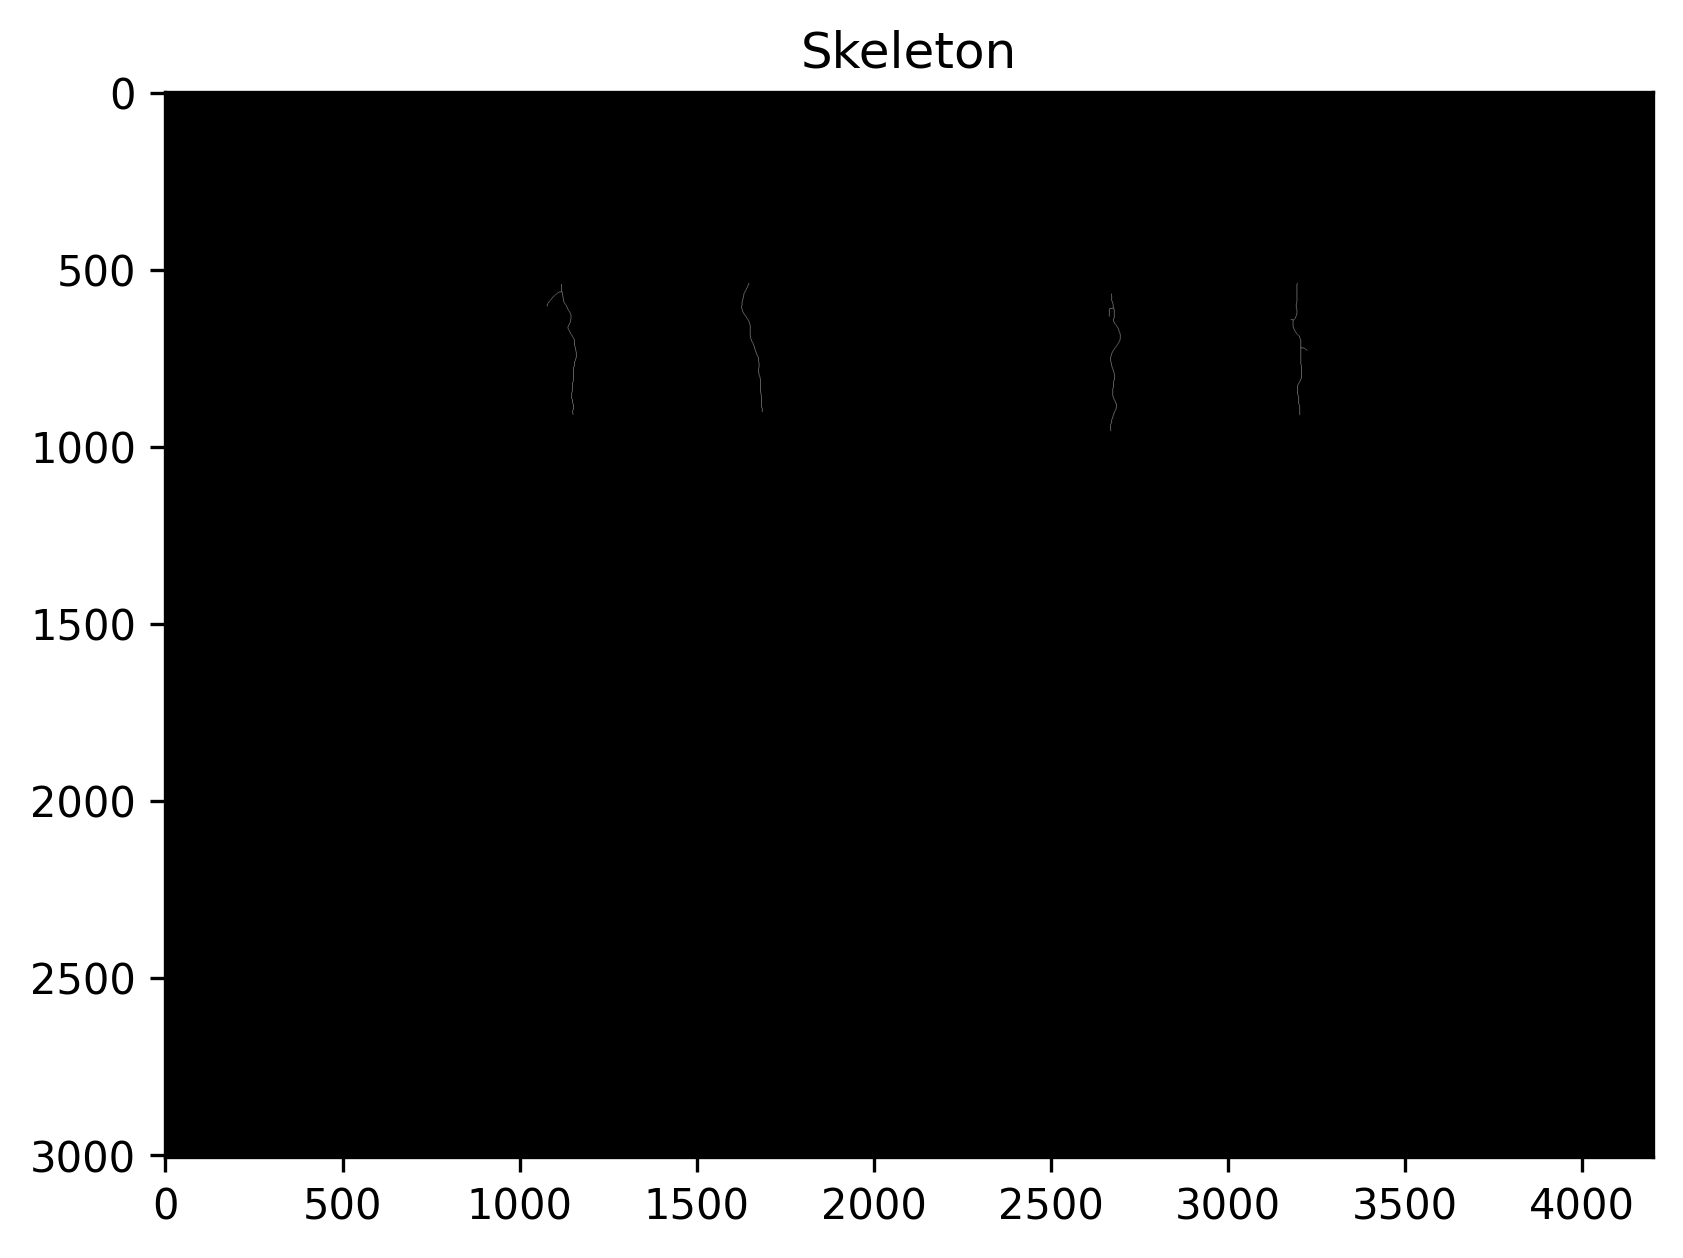

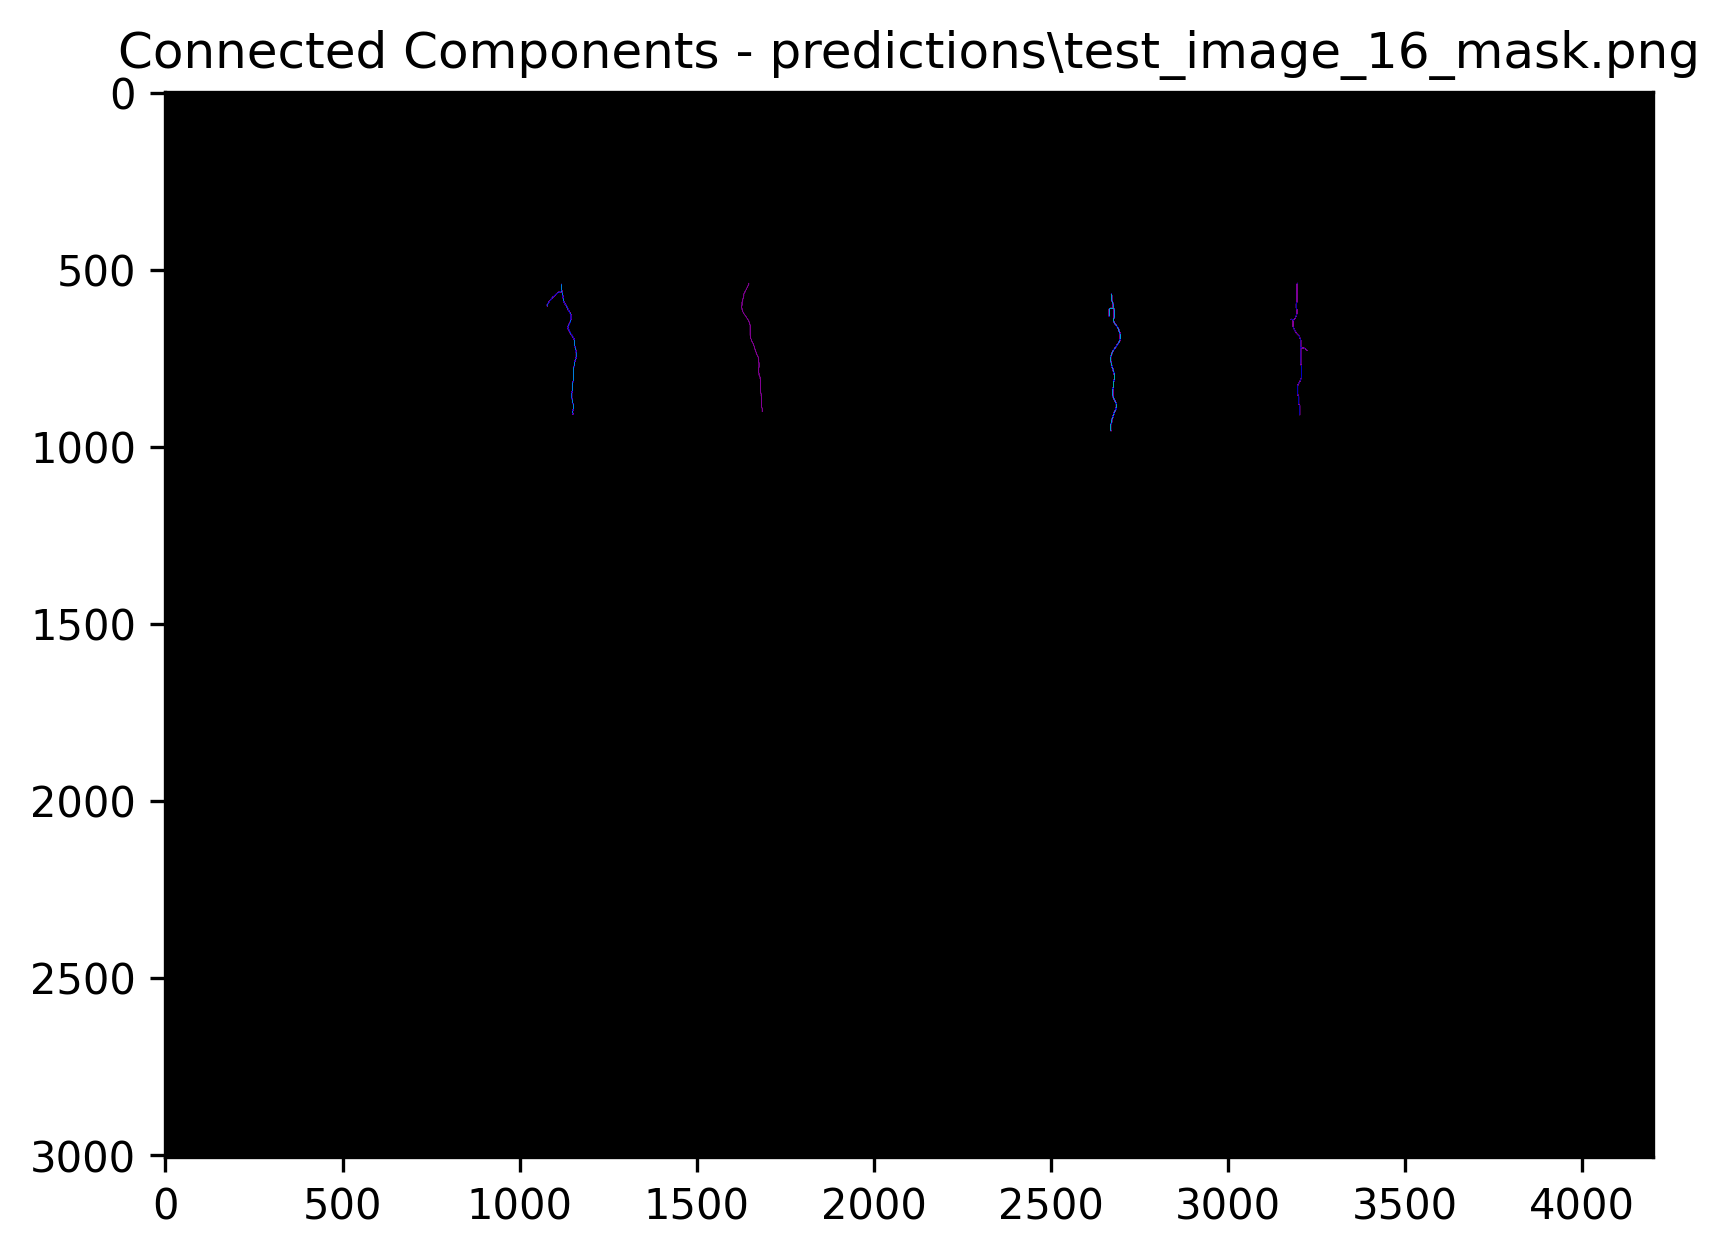

Component 1: Area=364, BBox=(1627,539,60,364)
Component 2: Area=399, BBox=(3179,539,47,373)
Component 3: Area=420, BBox=(1079,542,83,369)
Component 4: Area=421, BBox=(2666,569,32,388)
Seed testing123 [{'root_segment': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True]]), 'root_length': 364, 'x': 1657, 'y': 721}, {'root_segment': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'root_length': 399, 'x'

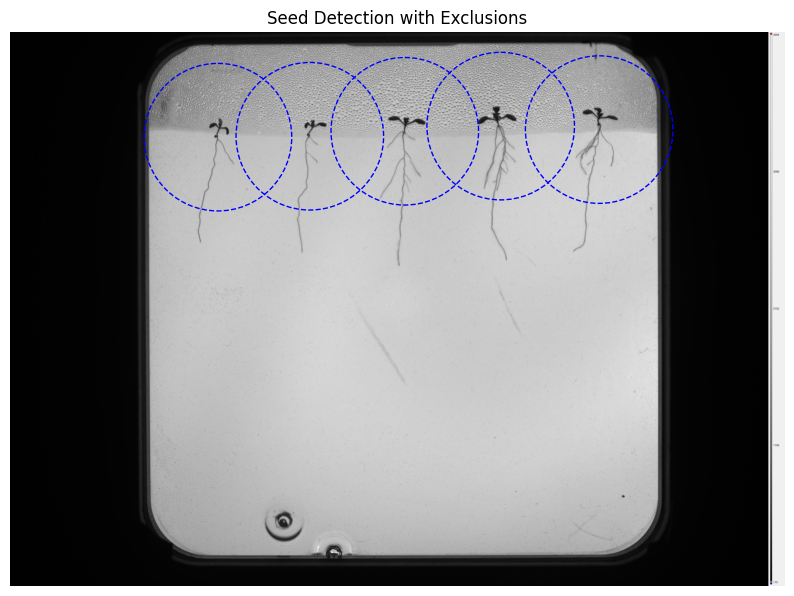

Detected seeds: []
Seeds near roots are excluded. Remaining seed count: 0


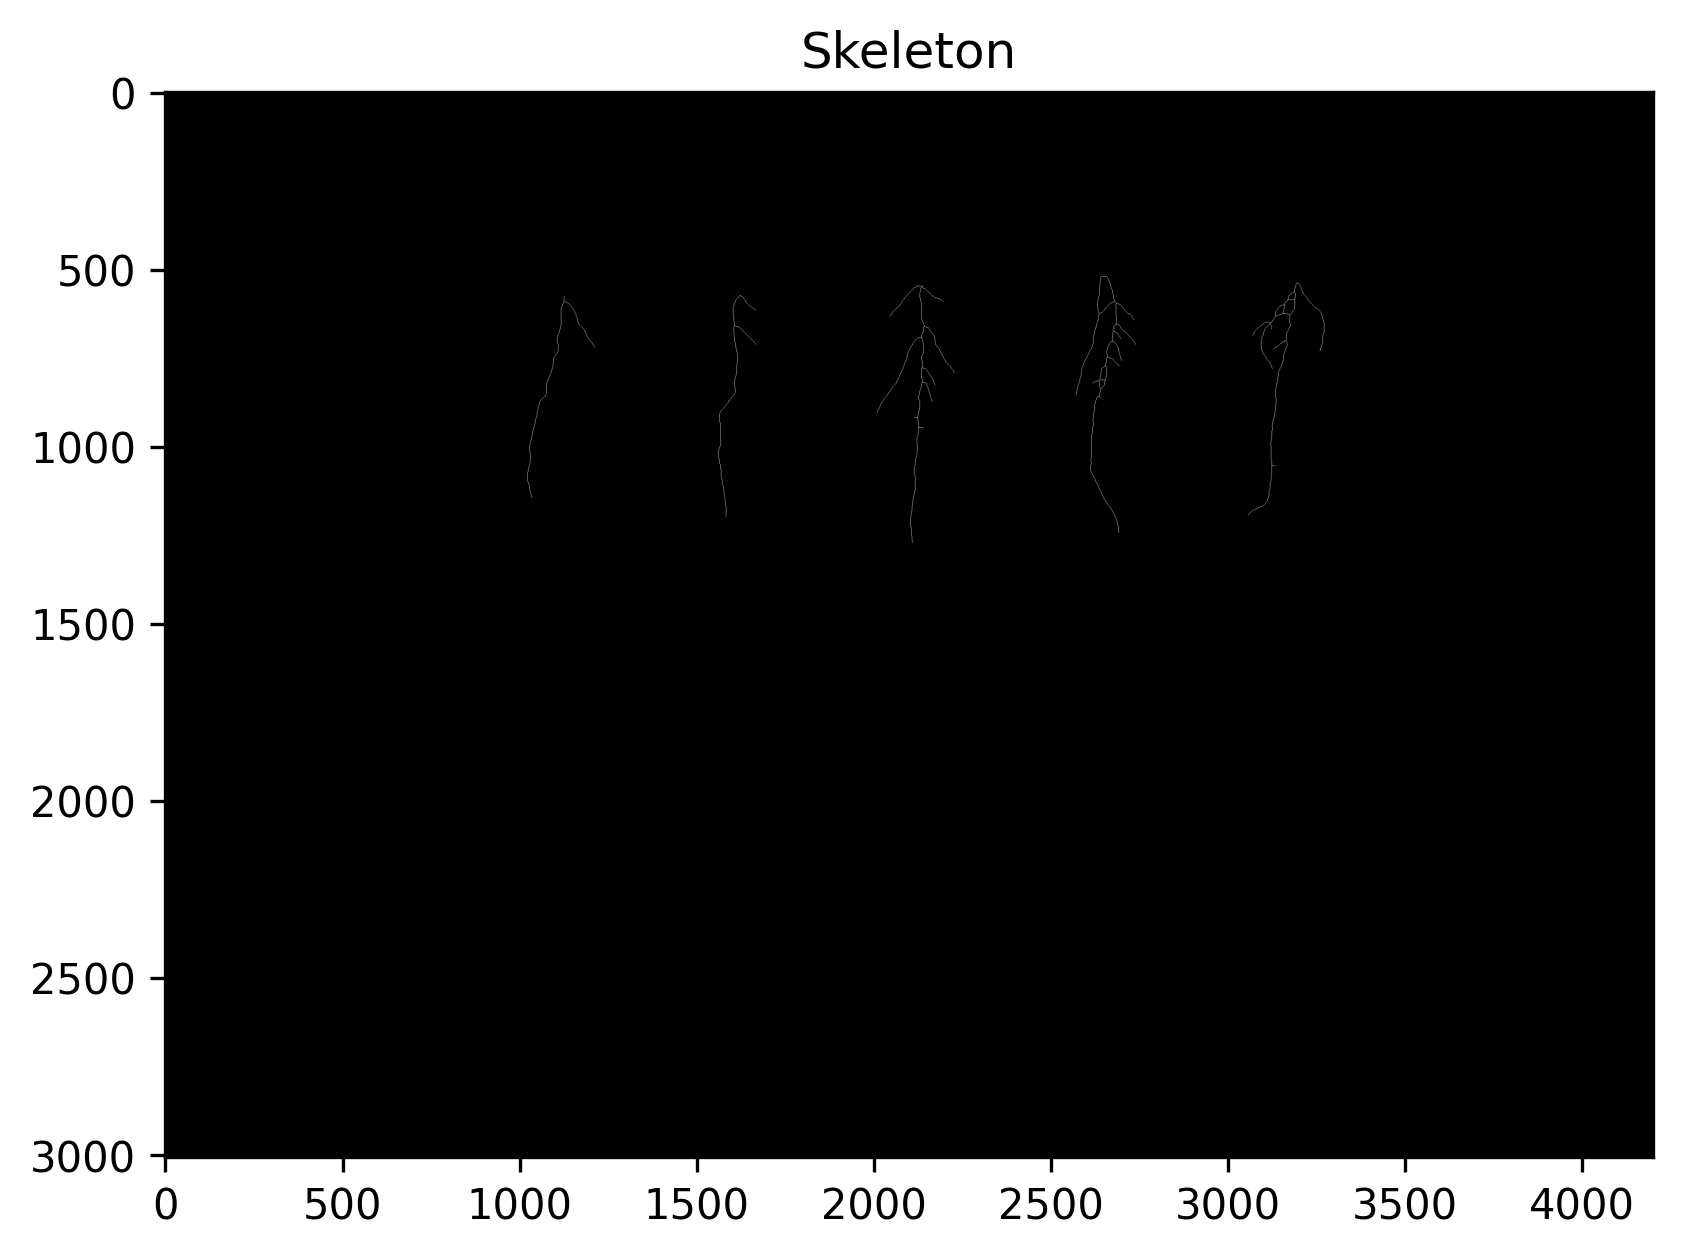

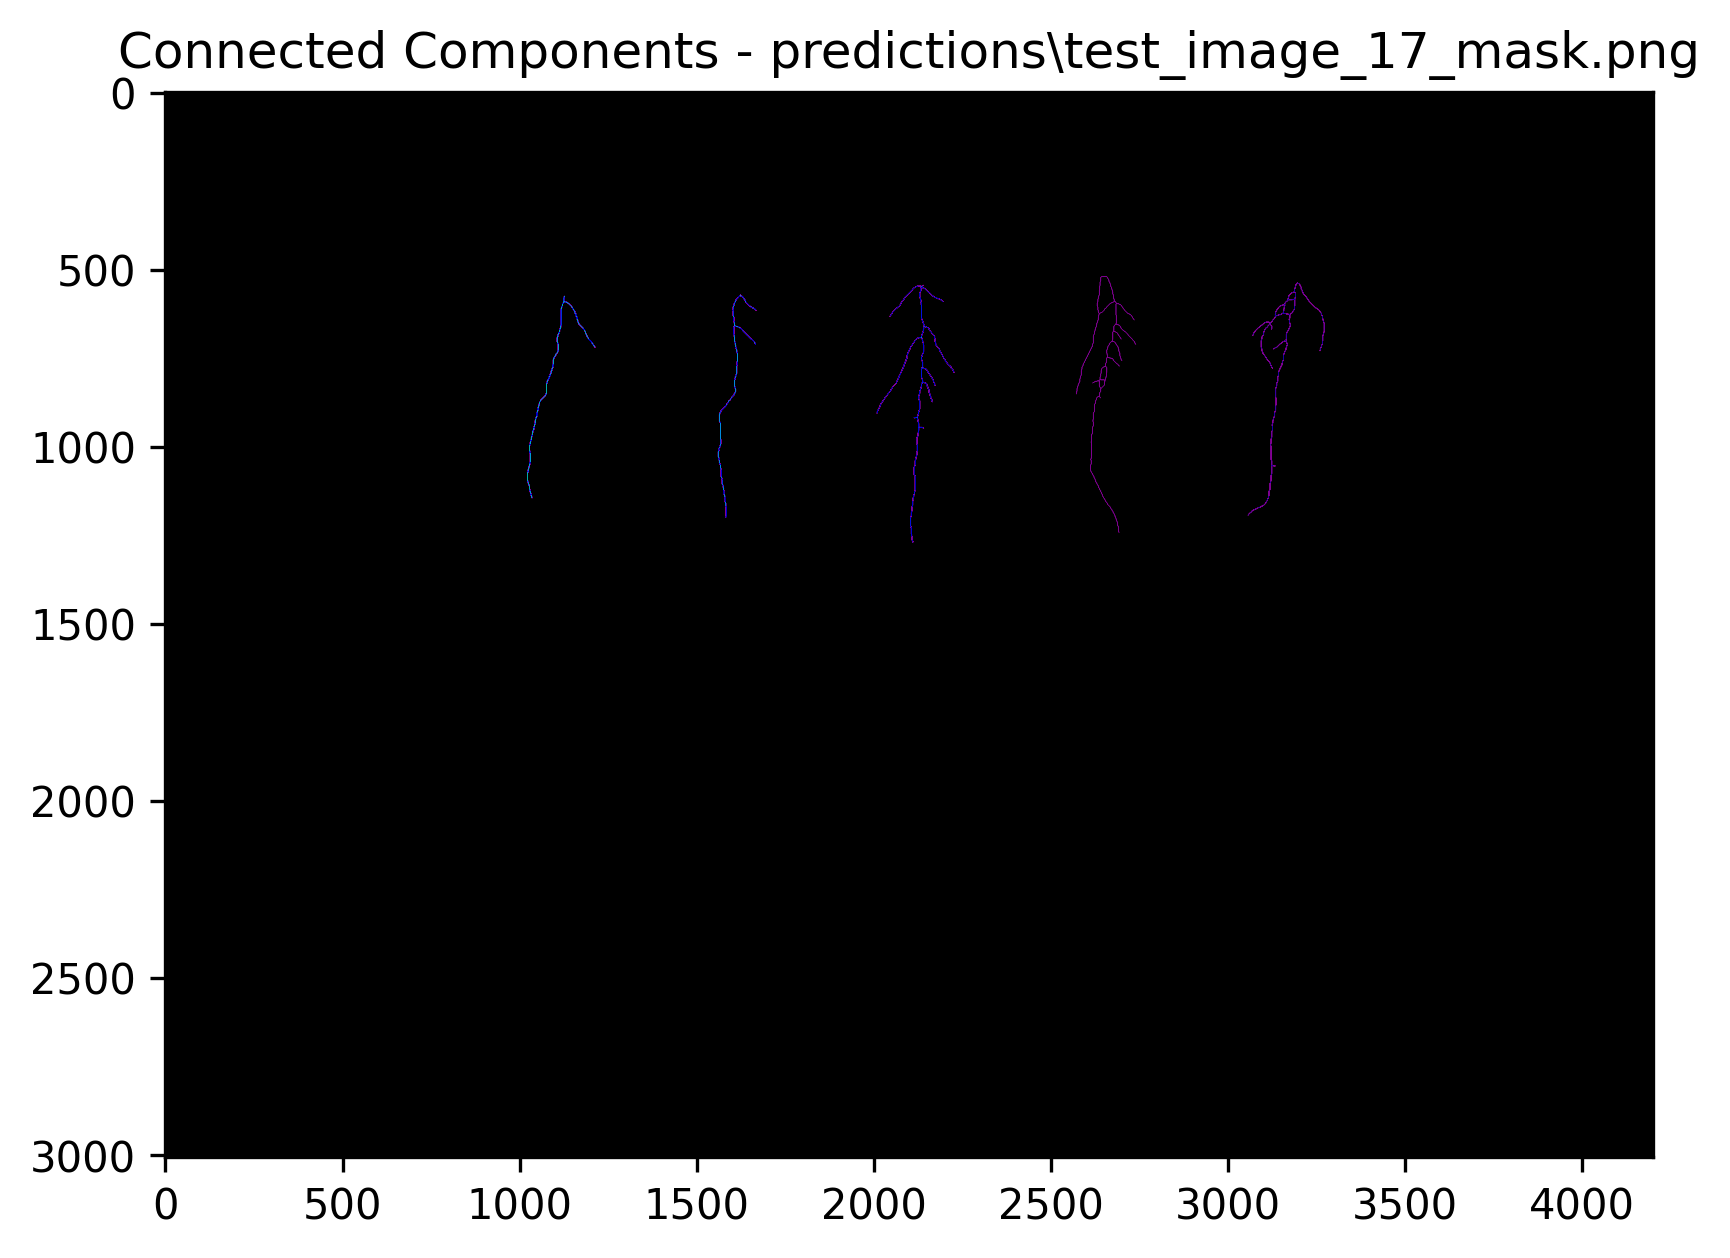

Component 1: Area=1472, BBox=(2573,520,169,724)
Component 2: Area=1305, BBox=(3058,538,216,657)
Component 3: Area=1401, BBox=(2010,545,219,727)
Component 4: Area=746, BBox=(1562,572,108,629)
Component 5: Area=707, BBox=(1023,576,192,570)
Seed testing123 [{'root_segment': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'root_length': 1472, 'x': 2657, 'y': 882}, {'root_segment': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False,  True, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [ True, False, Fals

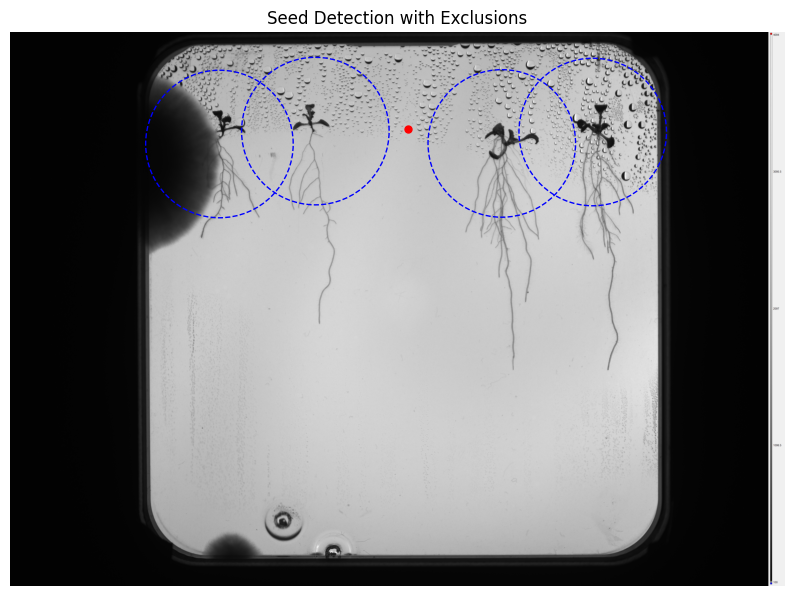

Detected seeds: [{'x': 2157, 'y': 528, 'x_cropped': 1441, 'y_cropped': 492, 'area': 67.0, 'mean_intensity': 54.149253731343286, 'circularity': 1.0201786698650581}]
Seeds near roots are excluded. Remaining seed count: 1


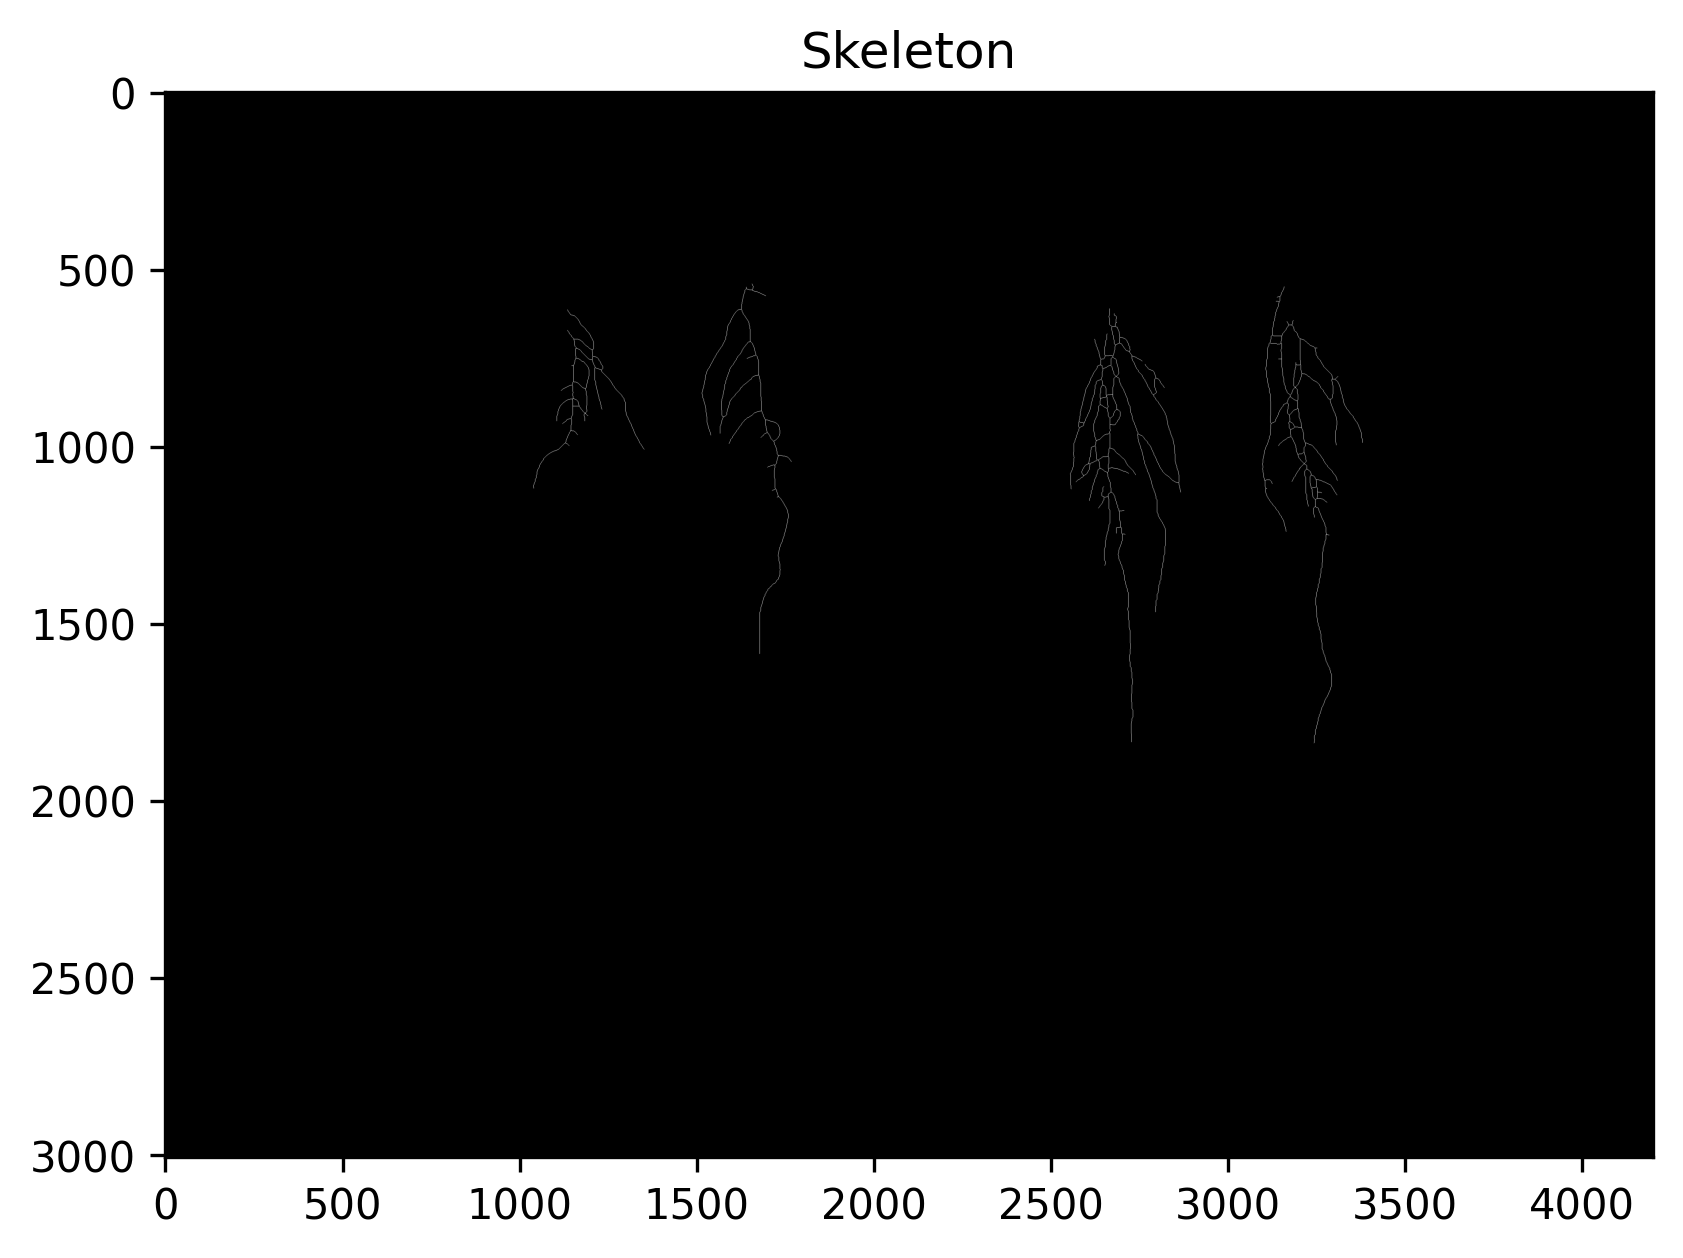

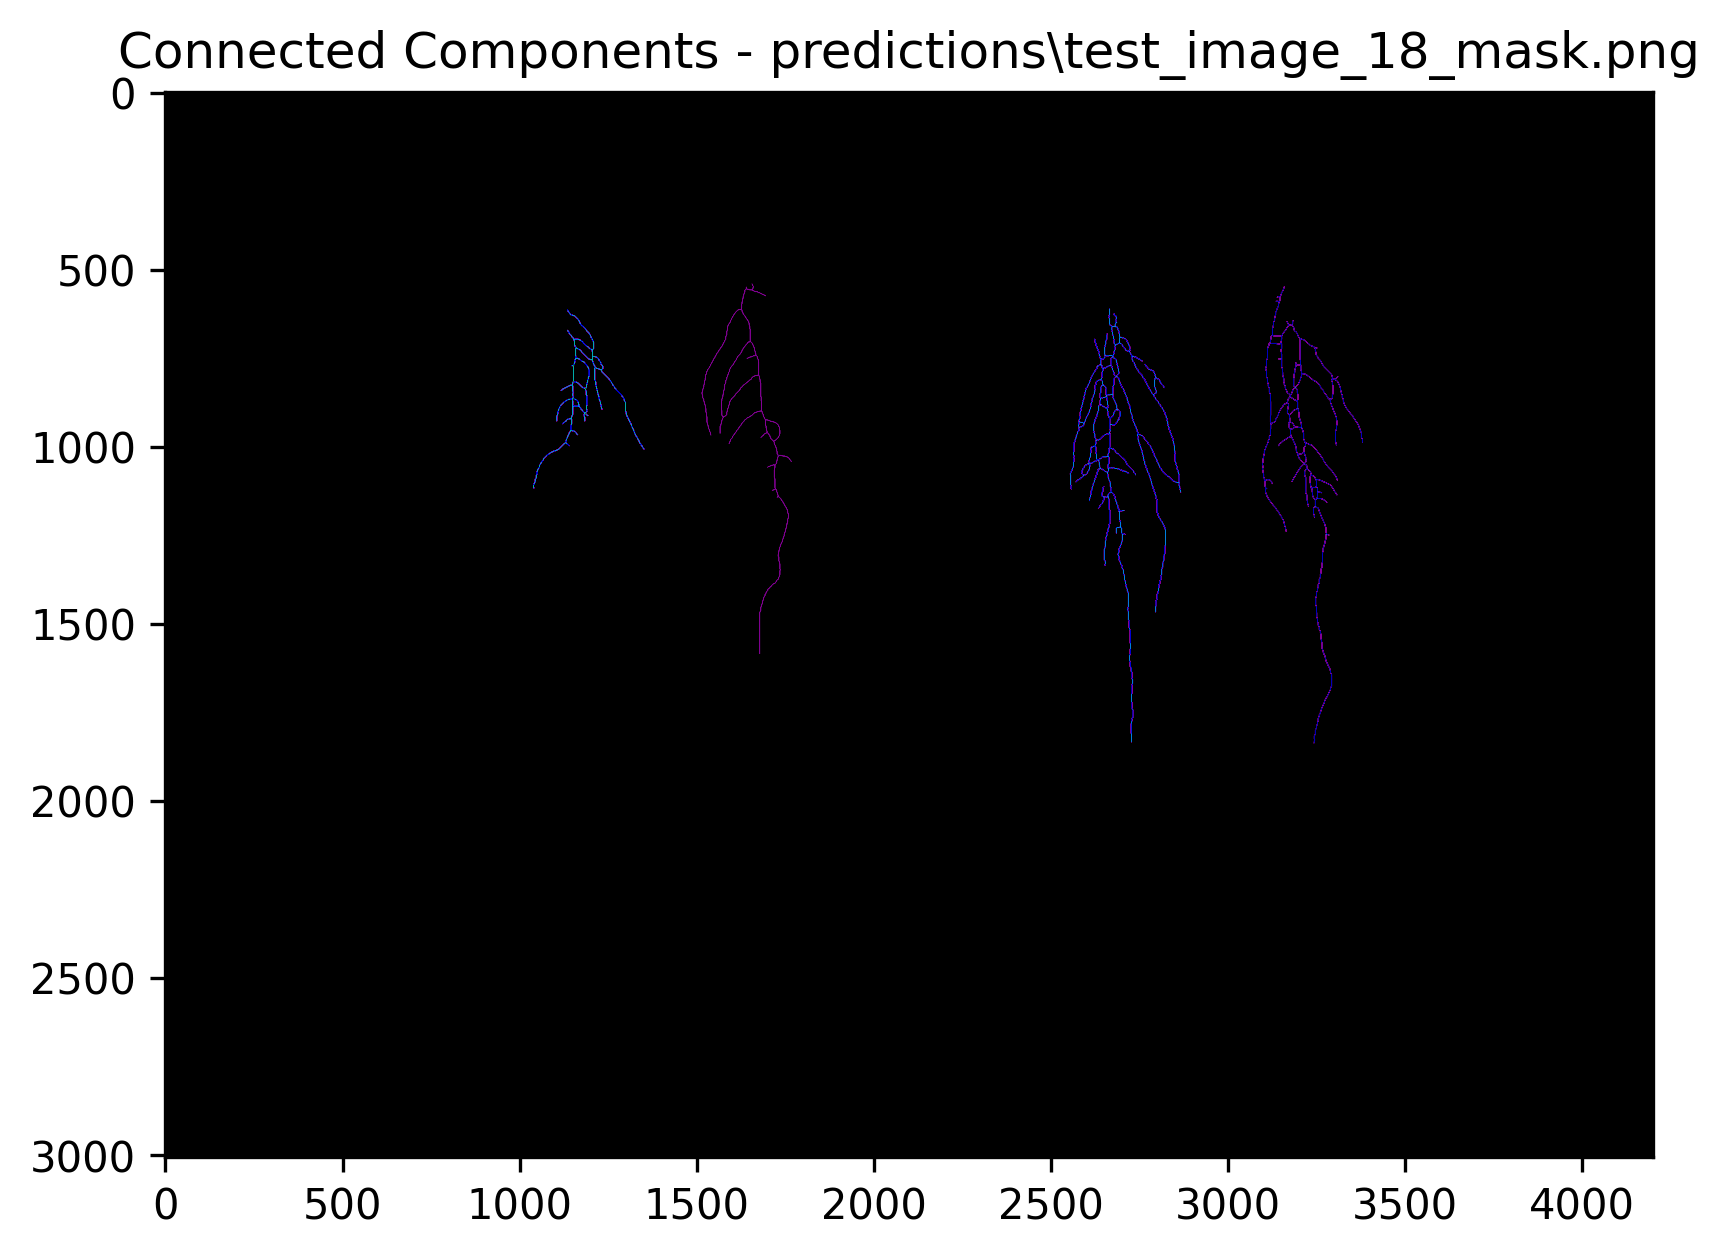

Component 1: Area=2200, BBox=(1516,541,253,1045)
Component 2: Area=3865, BBox=(3099,549,283,1289)
Component 3: Area=4908, BBox=(2556,611,313,1224)
Component 4: Area=1609, BBox=(1040,614,314,505)
Seed testing123 [{'root_segment': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'root_length': 2200, 'x': 1642, 'y': 1063}, {'root_segment': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'root_leng

In [4]:
# INPUT_FOLDER = './predictions'
INPUT_FOLDER = './predictions'
OUTPUT_FOLDER = './skeletonized_predictions'

segment_predictions(output_folder=OUTPUT_FOLDER, predictions_dir=INPUT_FOLDER, )